# ПРОМЫШЛЕННОСТЬ

# Введение

К нам обратился металлургический комбинат «Стальная птица», который решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.
Цель нашей работы - построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса.
Для этого нам нужно решить следующие задачи:
- изучить технологический процесс приготовления сплава;
- выгрузить и осмотреть данные;
- провести исследовательский анализ данных;
- произвести обработку;
- соединить таблицы;
- обучить несколько моделей, среди которых бустинги, решающее дерево или случайный лес, нейронные сети;
- выбрать лучшую модель и применить к тестовым данным;
- Произвести анализ важности признаков, зависимость одного целевой переменной от одного входного.

После каждого этапа работы мы будем делать промежуточные выводы, строить графики по возможности. В конце нам необходимо написать итоговый вывод и рекомендации для заказчика.

### Детали технологического процесса.
У нас есть таблица собранная по партиям сплава.
После изучения процесса плавки сплава нам удалось понять, что замер температуры происходит после каждой итерации, которая меняется каждый раз при загрузке нового сырья, нагрева или естественного охлаждения. Кроме того, нам известно что во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался. Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак.

# Загрузка и осмотр данных

Осуществим загрузку и первичный осмотр предоставленных данных. Подгрузим нужные модули и библиотеки.

In [1]:
#!pip install sqlalchemy
#!pip install lightgbm
#!pip install skorch

In [2]:
import os
import pandas as pd
import math
import numpy as np
import sqlite3
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from catboost import CatBoostRegressor, Pool, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
import torch
import torch.nn as nn
from skorch import NeuralNetRegressor
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.dummy import DummyRegressor

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import StandardScaler


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:18: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Таблицы находятся на сервере, который используется СУБД Sqlite. Подключимся к нему.

In [3]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

Убедимся что данные присутствуют на сервере.

In [4]:
required_tables = [
    'steel.data_arc', 
    'steel.data_bulk', 
    'steel.data_bulk_time', 
    'steel.data_gas', 
    'steel.data_temp', 
    'steel.data_wire', 
    'steel.data_wire_time'
]

def check_tables_exist(tables_list, engine):
    existing_tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", engine)['name'].tolist()

    results = {}
    for table in tables_list:
        short_name = table.split('.')[-1]
        results[table] = short_name in existing_tables
    
    return results
table_status = check_tables_exist(required_tables, engine)
display(table_status)


{'steel.data_arc': True,
 'steel.data_bulk': True,
 'steel.data_bulk_time': True,
 'steel.data_gas': True,
 'steel.data_temp': True,
 'steel.data_wire': True,
 'steel.data_wire_time': True}

Осмотрим их не подгружая. Выведем первые 8 строк каждого датафрейма.

In [5]:
def table(table_name, limit=8):
    query = f"SELECT * FROM {table_name} LIMIT {limit}"
    df = pd.read_sql(query, engine)
    display(table_name, df)
    return df

data_arc = table('data_arc')
data_bulk = table('data_bulk')
data_bulk_time = table('data_bulk_time')
data_gas = table('data_gas')
data_temp = table('data_temp')
data_wire = table('data_wire')
data_wire_time = table('data_wire_time')


'data_arc'

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50  2019-05-03 11:44:28           0.261665   
7    2  2019-05-03 11:46:19  2019-05-03 11:48:25           0.710297   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527  
7             0.484962

'data_bulk'

key Bulk 1 Bulk 2 Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1   None   None   None    43.0   None   None   None   None   None   
1    2   None   None   None    73.0   None   None   None   None   None   
2    3   None   None   None    34.0   None   None   None   None   None   
3    4   None   None   None    81.0   None   None   None   None   None   
4    5   None   None   None    78.0   None   None   None   None   None   
5    6   None   None   None   117.0   None   None   None   None   None   
6    7   None   None   None   117.0   None   None   None   None   None   
7    8   None   None   None    99.0   None   None   None   None   None   

  Bulk 10 Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15  
0    None    None   206.0    None   150.0   154.0  
1    None    None   206.0    None   149.0   154.0  
2    None    None   205.0    None   152.0   153.0  
3    None    None   207.0    None   153.0   154.0  
4    None    None   203.0    None   151.0   152.0  
5    None    None   204.0    None   201.0   154.0  
6    None    None   204.0    None   152.0   154.0  
7    None    None   410.0    None   252.0   153.0

'data_bulk_time'

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1   None   None   None  2019-05-03 11:28:48   None   None   None   None   
1    2   None   None   None  2019-05-03 11:36:50   None   None   None   None   
2    3   None   None   None  2019-05-03 12:32:39   None   None   None   None   
3    4   None   None   None  2019-05-03 12:43:22   None   None   None   None   
4    5   None   None   None  2019-05-03 13:30:47   None   None   None   None   
5    6   None   None   None  2019-05-03 13:57:27   None   None   None   None   
6    7   None   None   None  2019-05-03 14:18:58   None   None   None   None   
7    8   None   None   None  2019-05-03 15:17:58   None   None   None   None   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0   None    None    None  2019-05-03 11:24:31    None  2019-05-03 11:14:50   
1   None    None    None  2019-05-03 11:53:30    None  2019-05-03 11:48:37   
2   None    None    None  2019-05-03 12:27:13    None  2019-05-03 12:21:01   
3   None    None    None  2019-05-03 12:58:00    None  2019-05-03 12:51:11   
4   None    None    None  2019-05-03 13:30:47    None  2019-05-03 13:34:12   
5   None    None    None  2019-05-03 13:48:52    None  2019-05-03 14:09:42   
6   None    None    None  2019-05-03 14:41:26    None  2019-05-03 14:30:50   
7   None    None    None  2019-05-03 15:17:58    None  2019-05-03 15:13:18   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47  
5  2019-05-03 14:03:15  
6  2019-05-03 14:27:16  
7  2019-05-03 15:05:33

'data_gas'

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267
7    8  15.171553

'data_temp'

key         Время замера Температура
0    1  2019-05-03 11:02:04      1571.0
1    1  2019-05-03 11:07:18      1604.0
2    1  2019-05-03 11:11:34      1618.0
3    1  2019-05-03 11:18:04      1601.0
4    1  2019-05-03 11:25:59      1606.0
5    1  2019-05-03 11:30:38      1613.0
6    2  2019-05-03 11:34:04      1581.0
7    2  2019-05-03 11:38:40      1577.0

'data_wire'

key      Wire 1   Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1   60.059998     None   None   None   None   None   None   None   None
1    2   96.052315     None   None   None   None   None   None   None   None
2    3   91.160157     None   None   None   None   None   None   None   None
3    4   89.063515     None   None   None   None   None   None   None   None
4    5   89.238236  9.11456   None   None   None   None   None   None   None
5    6   99.109917  9.11456   None   None   None   None   None   None   None
6    7   98.061600     None   None   None   None   None   None   None   None
7    8  155.282394     None   None   None   None   None   None   None   None

'data_wire_time'

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                 None   None   None   None   None   
1    2  2019-05-03 11:36:50                 None   None   None   None   None   
2    3  2019-05-03 12:11:46                 None   None   None   None   None   
3    4  2019-05-03 12:43:22                 None   None   None   None   None   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34   None   None   None   None   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52   None   None   None   None   
6    7  2019-05-03 14:18:58                 None   None   None   None   None   
7    8  2019-05-03 15:01:30                 None   None   None   None   None   

  Wire 7 Wire 8 Wire 9  
0   None   None   None  
1   None   None   None  
2   None   None   None  
3   None   None   None  
4   None   None   None  
5   None   None   None  
6   None   None   None  
7   None   None   None

Теперь выгрузим таблицы.

In [6]:
path_to_db = 'ds-plus-final.db'

def upload(df_name, path_to_db):
    conn = sqlite3.connect(path_to_db)
    query = f"SELECT * FROM {df_name}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

data_arc = upload('data_arc', path_to_db)
data_bulk = upload('data_bulk', path_to_db)
data_bulk_time = upload('data_bulk_time', path_to_db)
data_gas = upload('data_gas', path_to_db)
data_temp = upload('data_temp', path_to_db)
data_wire = upload('data_wire', path_to_db)
data_wire_time = upload('data_wire_time', path_to_db)

Общая информация о таблицах.

In [7]:
def informing(table):
    print('\n')
    table.info()

informing(data_arc)
informing(data_bulk)
informing(data_bulk_time)
informing(data_gas)
informing(data_temp)
informing(data_wire)
informing(data_wire_time)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 n

Приведем даты и времена к datetime а так же числовые значения к float64 для корректных вычислений. Номер партии мы не трогаем.

In [8]:
for col in ['Начало нагрева дугой', 'Конец нагрева дугой']:
    data_arc[col] = pd.to_datetime(data_arc[col])

cols_to_convert = [col for col in data_bulk_time.columns if col != 'key']
for col in cols_to_convert:
    data_bulk_time[col] = pd.to_datetime(data_bulk_time[col])

data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp['Температура'] = data_temp['Температура'].astype('float64')

cols_to_convert = [col for col in data_wire_time.columns if col != 'key']
for col in cols_to_convert:
    data_wire_time[col] = pd.to_datetime(data_wire_time[col])

cols_to_convert = [col for col in data_bulk.columns if col != 'key']
data_bulk[cols_to_convert] = data_bulk[cols_to_convert].astype('float64')
cols_to_convert = [col for col in data_wire.columns if col != 'key']
data_wire[cols_to_convert] = data_wire[cols_to_convert].astype('float64')

Сразу переименуем с русского на английский для лучшего восприятия системой.

In [9]:
data_arc = data_arc.rename(columns={
    'Начало нагрева дугой': 'start_heating',
    'Конец нагрева дугой': 'end_heating', 
    'Активная мощность': 'active_power', 
    'Реактивная мощность': 'reactive_power'
})

data_gas = data_gas.rename(columns={
    'Газ 1': 'gas'
})

data_temp = data_temp.rename(columns={
    'Время замера': 'time_meas',
    'Температура': 'temperature', 
})

In [10]:
def informing(table):
    print('\n')
    table.info()

informing(data_arc)
informing(data_bulk)
informing(data_bulk_time)
informing(data_temp)
informing(data_wire)
informing(data_wire_time)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   end_heating     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7  

### Вывод по выгрузке

Данных не очень много, они раскиданы по партиям. Всего же на старте у нас 3129 партий и 14876 строк из которых они состоят. Есть некоторые ошибки выгрузок, вроде ненужных нам форматов признаков.

# Исследовательский анализ

По каждой таблице проведем исследование, в конце изучим визуализации признаков.

### Таблица data_arc

In [11]:
data_arc.describe()

key                  start_heating  \
count  14876.000000                          14876   
mean    1615.220422  2019-07-05 12:25:51.921081088   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000  2019-06-03 23:18:23.249999872   
50%     1617.000000     2019-07-03 01:31:26.500000   
75%     2429.000000  2019-08-07 22:52:20.750000128   
max     3241.000000            2019-09-06 17:24:54   
std      934.571502                            NaN   

                         end_heating  active_power  reactive_power  
count                          14876  14876.000000    14876.000000  
mean   2019-07-05 12:28:43.592027392      0.662752        0.438986  
min              2019-05-03 11:06:02      0.223120     -715.479924  
25%              2019-06-03 23:21:35      0.467115        0.337175  
50%              2019-07-03 01:35:13      0.599587        0.441639  
75%              2019-08-07 22:56:47      0.830070        0.608201  
max              2019-09-06 17:26:15      1.463773        1.270284  
std                              NaN      0.258885        5.873485

Имеется ненормальное значение реактивной мощности в минус 715.

In [12]:
data_arc.query('reactive_power < 0')

key       start_heating         end_heating  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479924

И хотя в физике это нормальное явление - отрицательное значение данного показателя, для нас оно является аномальным, так как является единственным. Заполним средним по средним значениям.

In [13]:
mean_value = data_arc.query('0.69 < active_power < 0.71 and index != 9780')['reactive_power'].mean()
data_arc.loc[9780, 'reactive_power'] = mean_value

In [14]:
data_arc.describe()

key                  start_heating  \
count  14876.000000                          14876   
mean    1615.220422  2019-07-05 12:25:51.921081088   
min        1.000000            2019-05-03 11:02:14   
25%      806.000000  2019-06-03 23:18:23.249999872   
50%     1617.000000     2019-07-03 01:31:26.500000   
75%     2429.000000  2019-08-07 22:52:20.750000128   
max     3241.000000            2019-09-06 17:24:54   
std      934.571502                            NaN   

                         end_heating  active_power  reactive_power  
count                          14876  14876.000000    14876.000000  
mean   2019-07-05 12:28:43.592027392      0.662752        0.487117  
min              2019-05-03 11:06:02      0.223120        0.153777  
25%              2019-06-03 23:21:35      0.467115        0.337192  
50%              2019-07-03 01:35:13      0.599587        0.441667  
75%              2019-08-07 22:56:47      0.830070        0.608201  
max              2019-09-06 17:26:15      1.463773        1.270284  
std                              NaN      0.258885        0.197606

Больше выявленных артефактов нет. Построим графики нормального распределения для мощностей.

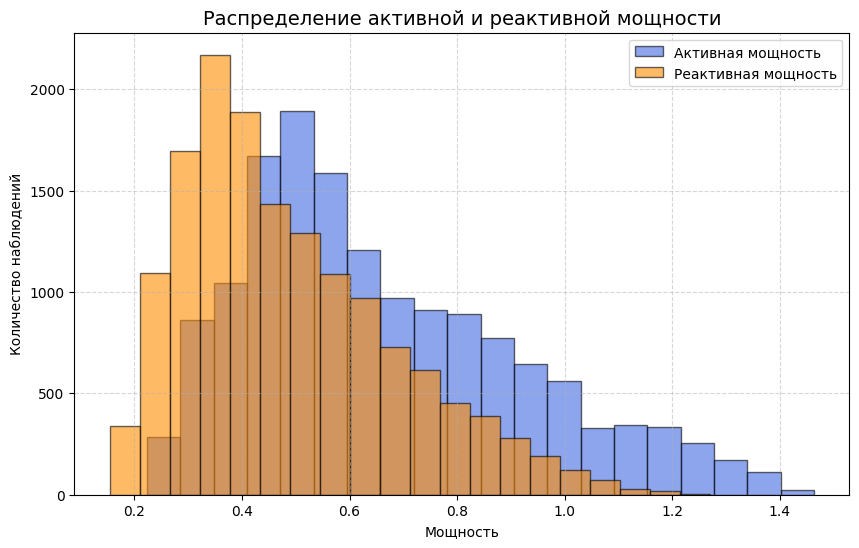

In [15]:
plt.figure(figsize=(10, 6))

plt.hist(data_arc['active_power'], bins=20, color='royalblue', alpha=0.6, edgecolor='black', label='Активная мощность')
plt.hist(data_arc['reactive_power'], bins=20, color='darkorange', alpha=0.6, edgecolor='black', label='Реактивная мощность')

plt.title('Распределение активной и реактивной мощности', fontsize=14)
plt.xlabel('Мощность')
plt.ylabel('Количество наблюдений')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

Обе мощности распределены в хороших значениях и практически одинаковы что является хорошим знаком. Создадим сразу новый признак - общая мощность. Будем соблюдать законы выведенные наукой физикой и посчитаем по нужной нам формуле. Просто складывать эти две мощности нельзя.

In [16]:
p = data_arc['active_power']
q = data_arc['reactive_power']
data_arc['full_power'] = np.sqrt(p**2 + q**2).round(6)

In [17]:
data_arc.head(5)

key       start_heating         end_heating  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   full_power  
0    0.371123  
1    0.902319  
2    0.722536  
3    0.642824  
4    1.079934

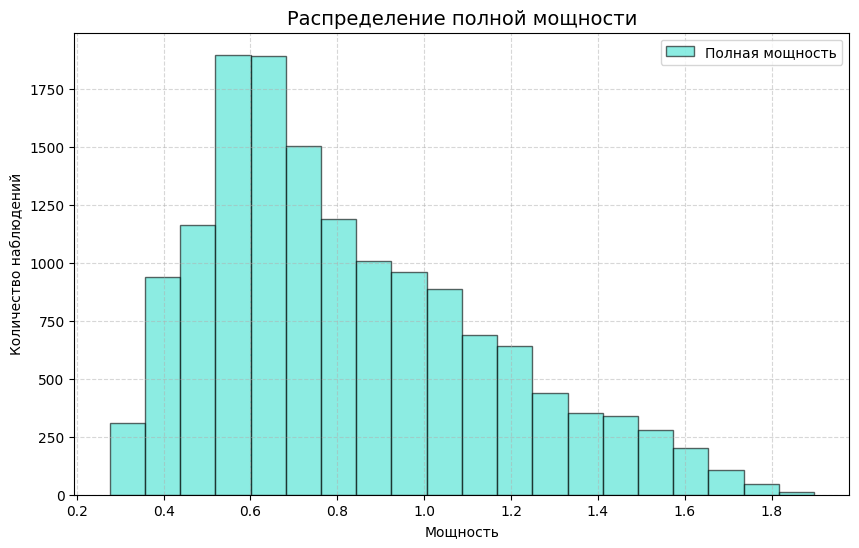

In [18]:
plt.figure(figsize=(10, 6))

plt.hist(data_arc['full_power'], bins=20, color='#40E0D0', alpha=0.6, edgecolor='black', label='Полная мощность')
plt.title('Распределение полной мощности', fontsize=14)
plt.xlabel('Мощность')
plt.ylabel('Количество наблюдений')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

График полной мощности почти дублирует первые два графика. Создадим еще один новый признак - общее время каждого нагрева каждой партии в секундах.

In [19]:
data_arc['total_heat'] = (data_arc['end_heating'] - data_arc['start_heating']).dt.total_seconds()

In [20]:
data_arc.head(3)

key       start_heating         end_heating  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   

   full_power  total_heat  
0    0.371123       228.0  
1    0.902319       185.0  
2    0.722536       172.0

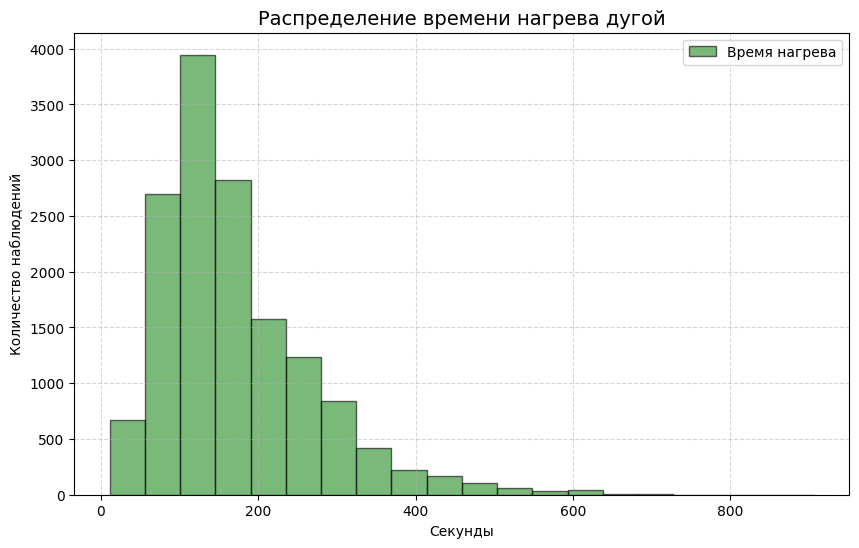

In [21]:
plt.figure(figsize=(10, 6))

plt.hist(data_arc['total_heat'], bins=20, color='#228B22', alpha=0.6, edgecolor='black', label='Время нагрева')
plt.title('Распределение времени нагрева дугой', fontsize=14)
plt.xlabel('Секунды')
plt.ylabel('Количество наблюдений')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

График оказался более сдвинут влево. Взглянем на боксплоты.

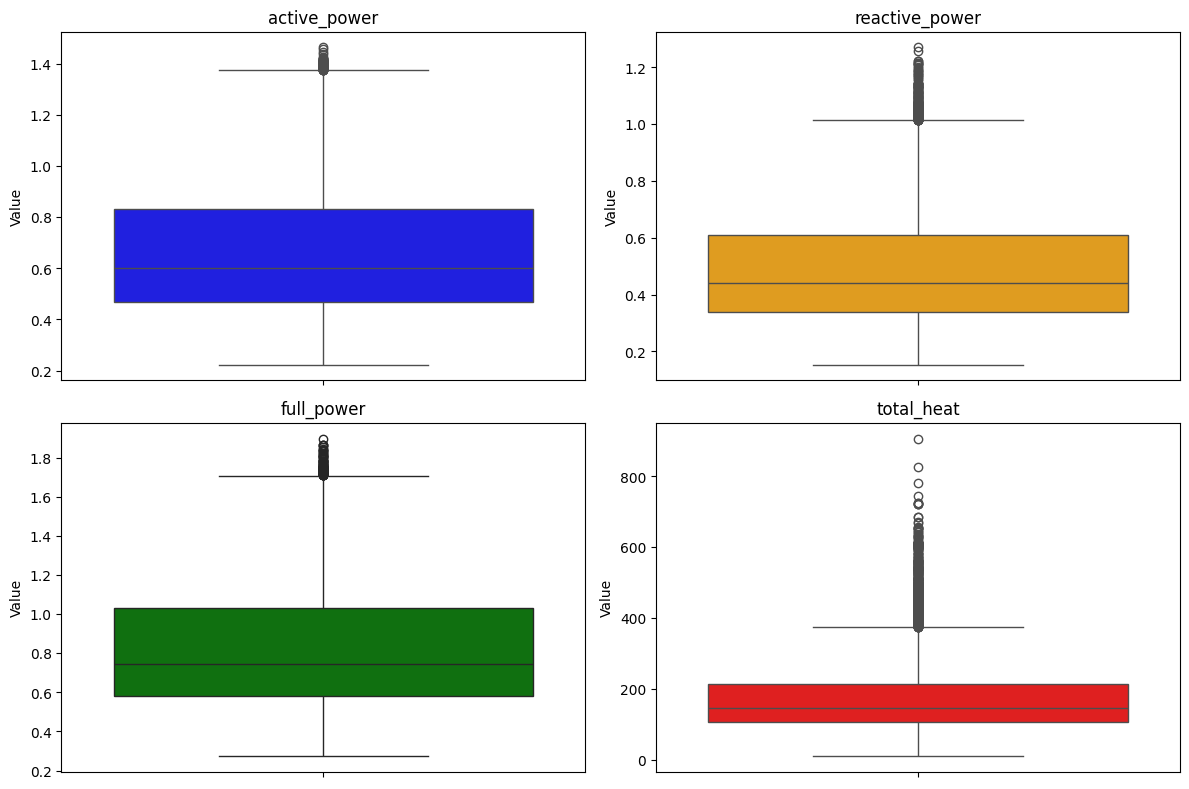

In [22]:
cols = ['active_power', 'reactive_power', 'full_power', 'total_heat']
colors = ['blue', 'orange', 'green', 'red']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, (col, clr) in enumerate(zip(cols, colors)):
    sns.boxplot(y=data_arc[col], ax=axes[i], color=clr)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value')

plt.tight_layout()
plt.show()


В каждом имеющимся признаке имеются выбросы. Скорее всего, выбросы в total_heat связаны с большим количеством засыпанного материала в бункер, так как для большего количества сырья требуется больший нагрев.

### Таблица data_bulk

In [23]:
data_bulk.head(3)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0

In [24]:
data_bulk.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

Здесь нас беспокоят два признака - Bulk 8 и Bulk 12. У первого, судя по всему, только одно значение, у второго слишком большой диапазон значений.

In [25]:
display('Подсчет уникальных значений в столбце Bulk 8:', data_bulk['Bulk 8'].value_counts())

'Подсчет уникальных значений в столбце Bulk 8:'

Bulk 8
49.0    1
Name: count, dtype: int64

Так и есть, восьмая загрузка имеет аномалию. Для работы с query временно переименуем признаки (мне так удобнее, *прим. исследователя*)

In [26]:
data_bulk_anom = data_bulk.rename(columns={'Bulk 12':'Bulk_12', 'Bulk 8':'Bulk_8'})
data_bulk_anom.query('Bulk_12 > 100')

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk_8  \
0        1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1        2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2        3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3        4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4        5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
...    ...     ...     ...     ...     ...     ...     ...     ...     ...   
3122  3235     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3123  3236     NaN     NaN    42.0     NaN     NaN     NaN     NaN     NaN   
3124  3237     NaN     NaN   170.0     NaN     NaN     NaN     NaN     NaN   
3125  3238     NaN     NaN   126.0     NaN     NaN     NaN     NaN     NaN   
3126  3239     NaN     NaN     NaN     NaN     NaN   114.0     NaN     NaN   

      Bulk 9  Bulk 10  Bulk 11  Bulk_12  Bulk 13  Bulk 14  Bulk 15  
0        NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1        NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2        NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3        NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4        NaN      NaN      NaN    203.0      NaN    151.0    152.0  
...      ...      ...      ...      ...      ...      ...      ...  
3122     NaN      NaN      NaN    204.0      NaN    118.0    206.0  
3123     NaN      NaN      NaN    258.0      NaN    132.0    208.0  
3124     NaN      NaN      NaN    252.0      NaN    130.0    206.0  
3125     NaN      NaN      NaN    254.0      NaN    108.0    106.0  
3126     NaN      NaN      NaN    158.0      NaN    270.0     88.0  

[2438 rows x 16 columns]

Для 12 загрузки очень больше значения в целом из всего датасета. Учитывя средние показатели времени нагрева и затраченной мощности (эти два признака связаны напрямую) - у нас неправильный объем указанного при загрузке сырья. Нам нужно найти среднее значение затраченного времени для нагрева партии Создадим более наглядную таблицу для поиска примерного значения.

In [27]:
data_arc_anom = data_arc[['key', 'total_heat']]
data_bulk_anom = data_bulk_anom[['key', 'Bulk_12']]
data_temp_anom = data_temp[['key', 'temperature']]

bulk = data_bulk_anom.copy()
arc = data_arc_anom.copy()
temp = data_temp_anom.copy()

bulk = bulk.sort_values('key').reset_index(drop=True)
arc = arc.sort_values('key').reset_index(drop=True)
temp = temp.sort_values('key').reset_index(drop=True)

result_parts = []

for key in sorted(set(bulk['key']).union(arc['key'], temp['key'])):
    bulk_part = bulk[bulk['key'] == key].reset_index(drop=True)
    arc_part = arc[arc['key'] == key].reset_index(drop=True)
    temp_part = temp[temp['key'] == key].reset_index(drop=True)
    combined = pd.concat([bulk_part, arc_part, temp_part], axis=1)
    result_parts.append(combined)

search_material = pd.concat(result_parts, ignore_index=True)
search_material = search_material.loc[:, ~search_material.columns.duplicated()]

In [28]:
search_material

key  Bulk_12  total_heat  temperature
0      1.0    206.0       228.0       1571.0
1      NaN      NaN       185.0       1604.0
2      NaN      NaN       172.0       1618.0
3      NaN      NaN       365.0       1601.0
4      NaN      NaN       148.0       1606.0
...    ...      ...         ...          ...
18087  NaN      NaN        57.0          NaN
18088  NaN      NaN       157.0          NaN
18089  NaN      NaN       180.0       1586.0
18090  NaN      NaN        81.0          NaN
18091  NaN      NaN         NaN          NaN

[18092 rows x 4 columns]

Для 12ой загрузки температура для каждой партии колеблется в пределах технологической нормы. А значит время нагрева должно быть тоже в пределах этой нормы. Из датасета data_arc мы знаем что 12 итерацию плавили 365.0 секунд.

Чтобы узнать объем засыпаемого материала в этой итерации нужно узнать сколько материала засыпается в среднем в секунду на остальных итерациях.

In [29]:
data_arc_anom = data_arc.copy()
data_bulk_anom = data_bulk.copy()
data_arc_anom['heat_sum_by_key'] = data_arc_anom.groupby('key')['total_heat'].transform('sum')

cols_to_mean = [col for col in data_bulk_anom.columns if col not in ['key', 'Bulk_8', 'Bulk_12']]

data_bulk_anom['Bulk_mean'] = data_bulk_anom[cols_to_mean].mean(axis=1)

data_bulk_anom['Bulk_mean_ratio'] = data_bulk_anom['Bulk_mean'] / data_arc_anom['heat_sum_by_key']

print(data_bulk_anom[['Bulk_mean', 'Bulk_mean_ratio']].head())
print(data_bulk_anom.shape)
print(data_bulk.shape)

   Bulk_mean  Bulk_mean_ratio
0     138.25         0.125911
1     145.50         0.132514
2     136.00         0.123862
3     148.75         0.135474
4     146.00         0.132969
(3129, 18)
(3129, 16)


Средний коофицент умножения равен 3.46. Теперь умножим его на время каждой итерации и получим значения засыпанного материала.

In [30]:
data_bulk['Bulk 12'] = data_arc['total_heat'] * data_bulk_anom['Bulk_mean_ratio']
data_bulk['Bulk 12'] = data_bulk['Bulk 12'].round(1)

In [31]:
data_bulk.head(3)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN     28.7      NaN    150.0    154.0  
1     NaN      NaN      NaN     24.5      NaN    149.0    154.0  
2     NaN      NaN      NaN     21.3      NaN    152.0    153.0

Теперь значения 12ой загрузки приведены в норму в соответсвиий с временем, температурой и мощностью.

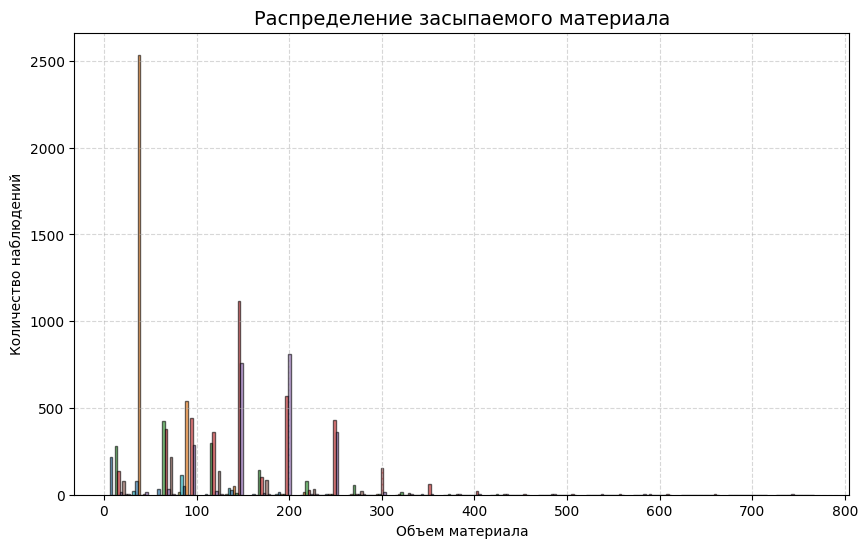

In [32]:
data_bulk_graph = data_bulk.drop('key', axis=1)

plt.figure(figsize=(10, 6))

plt.hist(data_bulk_graph, bins=15, alpha=0.6, edgecolor='black', label='Объем материала')
plt.title('Распределение засыпаемого материала', fontsize=14)
plt.xlabel('Объем материала')
plt.ylabel('Количество наблюдений')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Мы видим что количество засыпаемеого сырья обычно не выше 300. Хотя имеются выбросы.

### Таблица data_bulk_time

In [33]:
display('Количество непустых значений:', data_bulk_time.count())
print('\n')
display('Количество NaN значений:', data_bulk_time.isna().sum())

'Количество непустых значений:'

key        3129
Bulk 1      252
Bulk 2       22
Bulk 3     1298
Bulk 4     1014
Bulk 5       77
Bulk 6      576
Bulk 7       25
Bulk 8        1
Bulk 9       19
Bulk 10     176
Bulk 11     177
Bulk 12    2450
Bulk 13      18
Bulk 14    2806
Bulk 15    2248
dtype: int64

'Количество NaN значений:'

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Очень много пустых значений, значит в эти моменты сырье, судя по всему, не подавалось. Посмотрим на диапазоны временных рамок, чтобы не попасть в ловушку когда диапазоны равны месяцам или неделям.

In [34]:
time_cols = [col for col in data_bulk_time.columns if col != 'key']
data_bulk_time_1 = data_bulk_time.copy()

for col in time_cols:
    data_bulk_time_1[col] = pd.to_datetime(data_bulk_time_1[col], errors='coerce')

data_bulk_time_1['min_time'] = data_bulk_time_1[time_cols].min(axis=1, skipna=True)
data_bulk_time_1['max_time'] = data_bulk_time_1[time_cols].max(axis=1, skipna=True)
data_bulk_time_1['time_range'] = data_bulk_time_1['max_time'] - data_bulk_time_1['min_time']
data_bulk_time_1[['key', 'time_range']].sort_values('time_range', ascending=False).head()


key      time_range
1895  1958 0 days 03:48:03
1819  1881 0 days 03:12:32
1818  1880 0 days 02:35:36
2859  2965 0 days 02:00:38
2470  2562 0 days 01:51:11

Построим график временных промежутков.

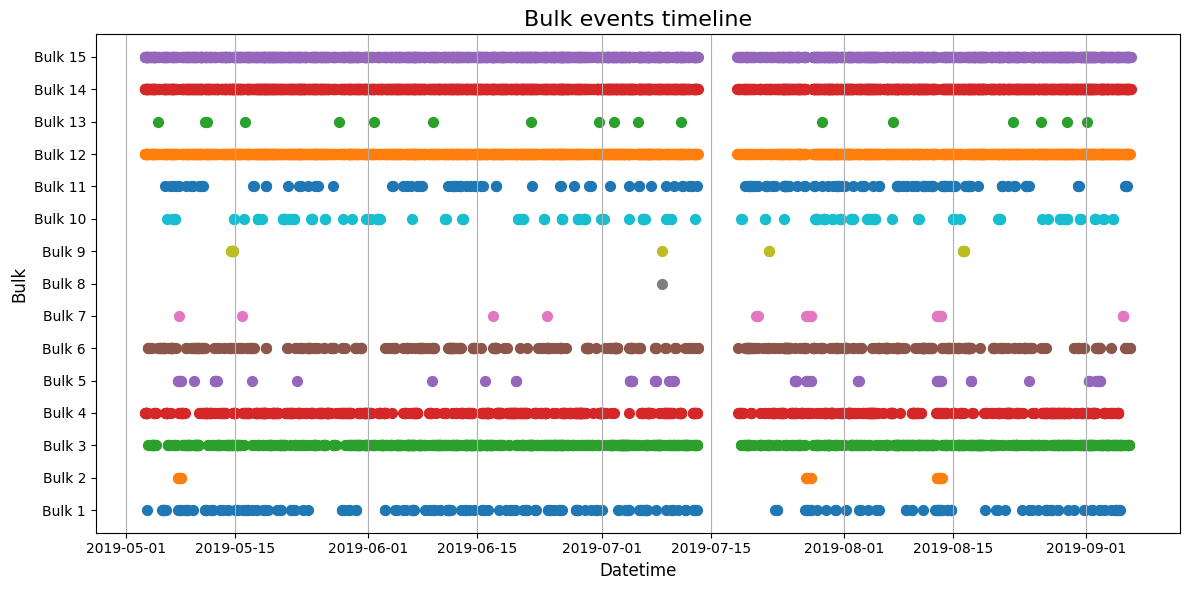

In [35]:
data_bulk_time_graph = data_bulk_time.drop('key', axis=1)

plt.figure(figsize=(12, 6))

for i, col in enumerate(data_bulk_time_graph.columns):
    plt.scatter(
        data_bulk_time_graph[col], 
        [col]*len(data_bulk_time_graph),  # каждая серия на своей "строке"
        label=col,
        s=50
    )

plt.title('Bulk events timeline', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Bulk', fontsize=12)
plt.yticks(rotation=0)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


### Таблица data_gas

In [36]:
data_gas.describe()

key          gas
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Значения подаваемого газа, в целом, корректны.

In [37]:
data_gas.isna().sum()

key    0
gas    0
dtype: int64

In [38]:
data_gas.dtypes

key      int64
gas    float64
dtype: object

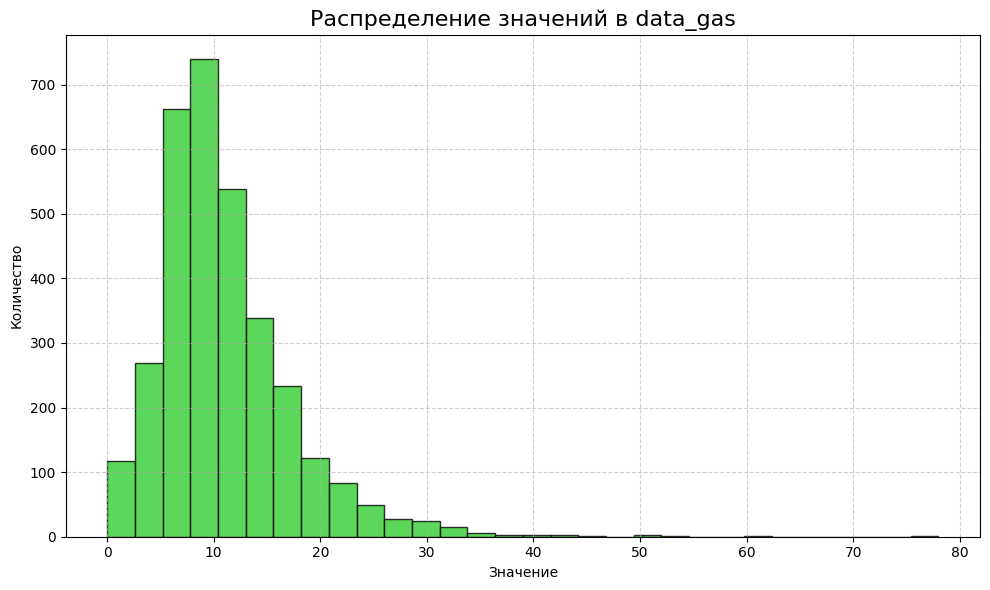

In [39]:
data_gas_graph = data_gas.drop('key', axis=1)

plt.figure(figsize=(10, 6))
plt.hist(data_gas_graph.dropna().values.flatten(), bins=30, color='#32CD32', edgecolor='black', alpha=0.8)

plt.title('Распределение значений в data_gas', fontsize=16)
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


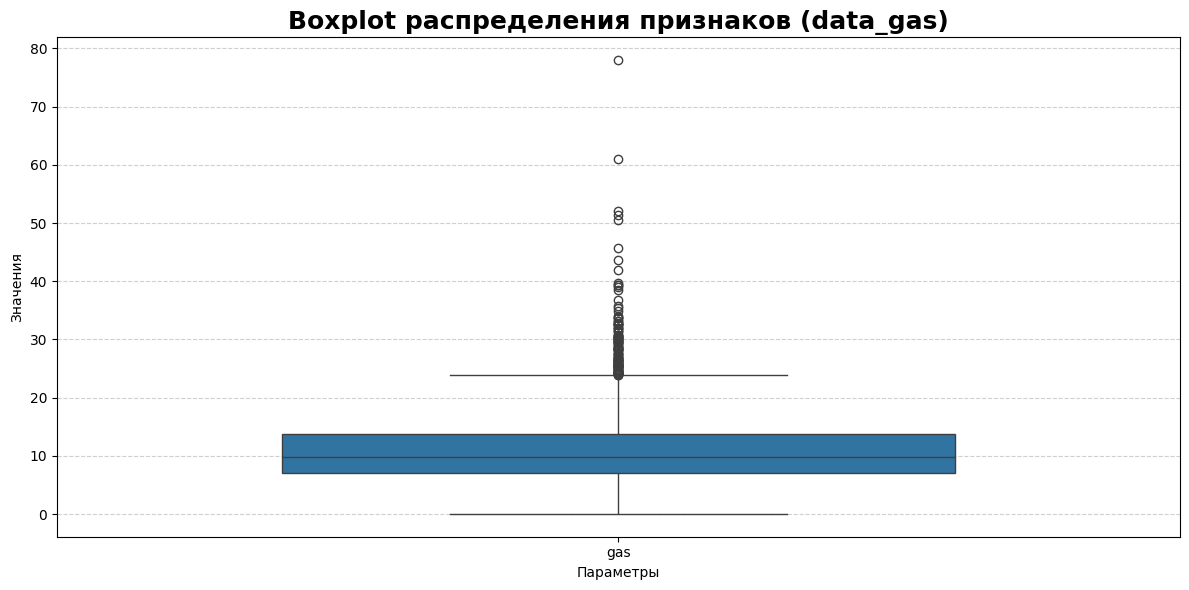

In [40]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_gas_graph, width=0.6)

plt.title('Boxplot распределения признаков (data_gas)', fontsize=18, fontweight='bold')
plt.xlabel('Параметры')
plt.ylabel('Значения')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [41]:
data_gas.query('gas > 20')

key        gas
0        1  29.749986
2        3  28.554793
43      44  21.265271
100    101  20.514189
105    106  33.213990
...    ...        ...
3117  3120  22.804901
3172  3175  21.468200
3174  3177  23.592403
3182  3185  23.013479
3186  3189  21.486542

[254 rows x 2 columns]

Подаваемый газ для продувки имеет хорошее нормальное распределение, небольшие выбросы в пределах 254 строк, что не является критичным, тем более что они небольшие.

### Таблица data_temp

Самый важный для нас столбец.

In [42]:
data_temp.head(5)

key           time_meas  temperature
0    1 2019-05-03 11:02:04       1571.0
1    1 2019-05-03 11:07:18       1604.0
2    1 2019-05-03 11:11:34       1618.0
3    1 2019-05-03 11:18:04       1601.0
4    1 2019-05-03 11:25:59       1606.0

In [43]:
data_temp.isna().sum()

key               0
time_meas         0
temperature    3427
dtype: int64

Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.

In [44]:
display(data_temp.query('temperature < 1500').sort_values(by='temperature', ascending=False))

key           time_meas  temperature
11495  2052 2019-07-25 08:49:15       1227.0
9050   1619 2019-07-03 02:34:41       1218.0
6784   1214 2019-06-18 08:01:03       1208.0
14283  2561 2019-08-12 18:49:29       1204.0
4883    867 2019-06-06 08:03:39       1191.0

Целых 5 строчек. Чуть позже решим, что с ними делать.

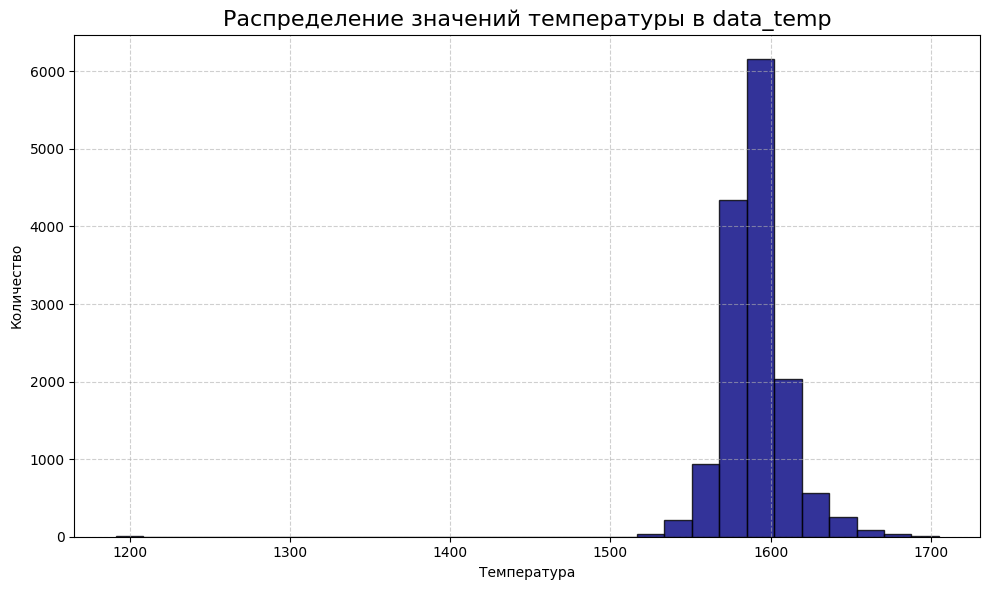

In [45]:
data_temp_graph = data_temp.drop(['key', 'time_meas'], axis=1)

plt.figure(figsize=(10, 6))
plt.hist(data_temp_graph.dropna().values.flatten(), bins=30, color='#000080', edgecolor='black', alpha=0.8)

plt.title('Распределение значений температуры в data_temp', fontsize=16)
plt.xlabel('Температура')
plt.ylabel('Количество')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Поддерживаемая температура сплава в пределах нормы.

### Таблица data_wire

In [46]:
data_wire.head(2)

key     Wire 1  Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN

In [47]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [48]:
data_wire.loc[:, data_wire.columns != 'key'] = data_wire.loc[:, data_wire.columns != 'key'].fillna(0)
data_wire.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

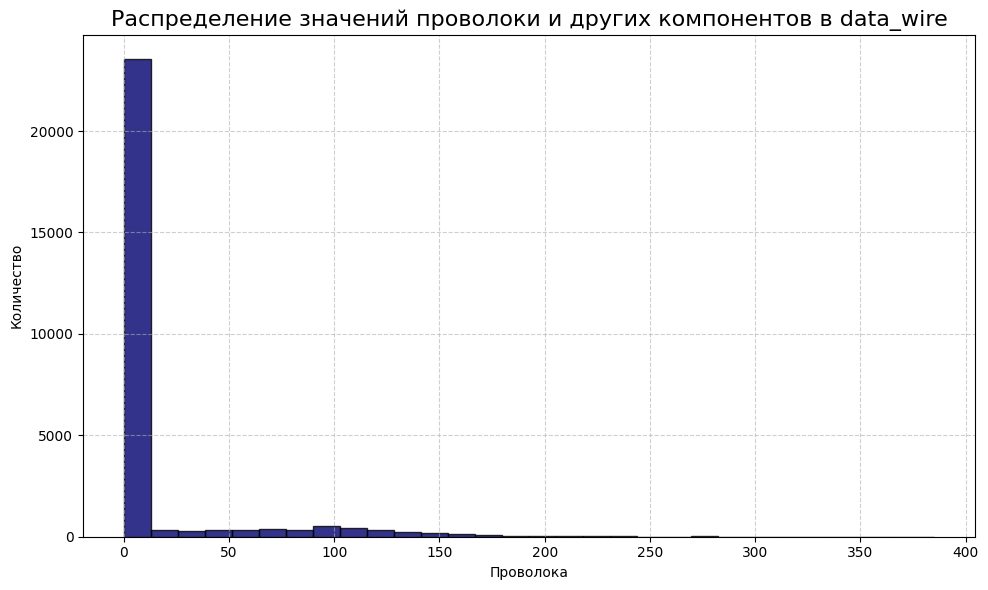

In [49]:
data_wire_graph = data_wire.drop(['key'], axis=1)

plt.figure(figsize=(10, 6))
plt.hist(data_wire_graph.dropna().values.flatten(), bins=30, color='#000070', edgecolor='black', alpha=0.8)

plt.title('Распределение значений проволоки и других компонентов в data_wire', fontsize=16)
plt.xlabel('Проволока')
plt.ylabel('Количество')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Основная часть добавок осуществляется в первые минуты плавки.

### Таблица data_wire_time

In [50]:
data_wire_time.head()

key              Wire 1              Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1 2019-05-03 11:06:19                 NaT    NaT    NaT    NaT    NaT   
1    2 2019-05-03 11:36:50                 NaT    NaT    NaT    NaT    NaT   
2    3 2019-05-03 12:11:46                 NaT    NaT    NaT    NaT    NaT   
3    4 2019-05-03 12:43:22                 NaT    NaT    NaT    NaT    NaT   
4    5 2019-05-03 13:20:44 2019-05-03 13:15:34    NaT    NaT    NaT    NaT   

  Wire 7 Wire 8 Wire 9  
0    NaT    NaT    NaT  
1    NaT    NaT    NaT  
2    NaT    NaT    NaT  
3    NaT    NaT    NaT  
4    NaT    NaT    NaT

In [51]:
display('Количество непустых значений:', data_wire_time.count())
print('\n')
display('Количество NaN значений:', data_wire_time.isna().sum())

'Количество непустых значений:'

key       3081
Wire 1    3055
Wire 2    1079
Wire 3      63
Wire 4      14
Wire 5       1
Wire 6      73
Wire 7      11
Wire 8      19
Wire 9      29
dtype: int64

'Количество NaN значений:'

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Так же посмотрим на временные диапазоны.

In [52]:
time_cols = [col for col in data_wire_time.columns if col != 'key']
data_wire_time_1 = data_wire_time.copy()

for col in time_cols:
    data_wire_time_1[col] = pd.to_datetime(data_wire_time_1[col], format='%d.%m.%Y %H:%M:%S', errors='coerce')

data_wire_time_1['min_time'] = data_wire_time_1[time_cols].min(axis=1, skipna=True)
data_wire_time_1['max_time'] = data_wire_time_1[time_cols].max(axis=1, skipna=True)
data_wire_time_1['time_range'] = data_wire_time_1['max_time'] - data_wire_time_1['min_time']
data_wire_time_1[['key', 'time_range']].sort_values('time_range', ascending=False).head()

key      time_range
2012  2110 0 days 01:38:57
2010  2108 0 days 01:31:32
2439  2566 0 days 01:23:33
2440  2567 0 days 00:59:38
97     113 0 days 00:57:57

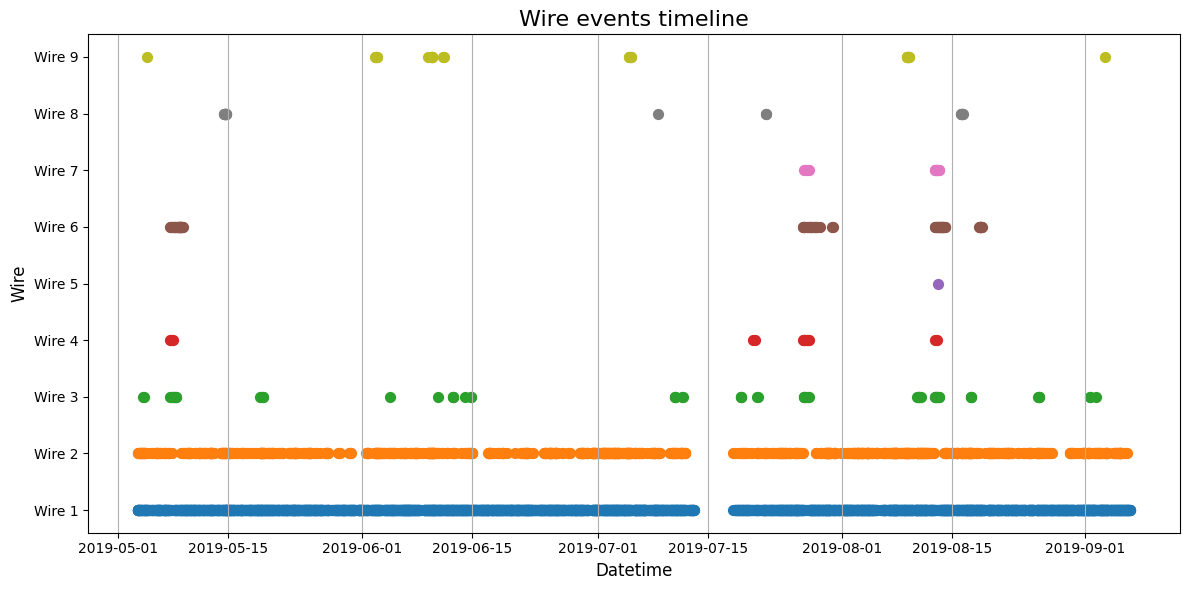

In [53]:
data_wire_time_graph = data_wire_time.drop('key', axis=1)

plt.figure(figsize=(12, 6))

for i, col in enumerate(data_wire_time_graph.columns):
    plt.scatter(
        data_wire_time_graph[col], 
        [col]*len(data_wire_time_graph),  # каждая серия на своей "строке"
        label=col,
        s=50
    )

plt.title('Wire events timeline', fontsize=16)
plt.xlabel('Datetime', fontsize=12)
plt.ylabel('Wire', fontsize=12)
plt.yticks(rotation=0)
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


Здесь тоже видно, что основная загрузка компонентов осуществлялась в первые минуты создания сплава.

### Вывод по исследованию
Почти везде имеется совпадающие между собой, и судя по всему, с реальностью значения. Суровых отклонений нет, за исключением некоторых аномалий в Bulk. И почти везде есть множество пустых значений. Что с ними делать - решим позже.

Исследование показало, что проволока и сырье засыпалось практически в первые минуты плавки. Газ подавался так же. Температура замеров имеет правильное распределение, как и практически все признаки. Аномалии устранены

# Объединение таблиц

Так как временные и общезагрузочные столбцы имеют одинаковые названим нам необходимо их разделить в названиях. Переименуем.

In [54]:
data_bulk_time = data_bulk_time.rename(columns={
    'Bulk 1': 'Bulk_time 1', 'Bulk 2': 'Bulk_time 2', 'Bulk 3': 'Bulk_time 3',
    'Bulk 4': 'Bulk_time 4', 'Bulk 5': 'Bulk_time 5', 'Bulk 6': 'Bulk_time 6',
    'Bulk 7': 'Bulk_time 7', 'Bulk 8': 'Bulk_time 8', 'Bulk 9': 'Bulk_time 9',
    'Bulk 10': 'Bulk_time 10', 'Bulk 11': 'Bulk_time 11', 'Bulk 12': 'Bulk_time 12',
    'Bulk 13': 'Bulk_time 13', 'Bulk 14': 'Bulk_time 14', 'Bulk 15': 'Bulk_time 15'
})

data_wire_time = data_wire_time.rename(columns={
    'Wire 1': 'Wire_time 1', 'Wire 2': 'Wire_time 2', 'Wire 3': 'Wire_time 3',
    'Wire 4': 'Wire_time 4', 'Wire 5': 'Wire_time 5', 'Wire 6': 'Wire_time 6',
    'Wire 7': 'Wire_time 7', 'Wire 8': 'Wire_time 8', 'Wire 9': 'Wire_time 9'
})


У нас задача взять для таргета последнее значение измеренной температуры. Значит, нам нужно найти партии состоящие из одной строки и удалить их.

In [55]:
key_counts = data_temp['key'].value_counts()
single_keys = key_counts[key_counts == 1]

num_single_keys = len(single_keys)

print(f'Ключей, у которых только 1 строка: {num_single_keys}')

key_counts = data_temp['key'].value_counts()
valid_keys = key_counts[key_counts >= 2].index
data_temp = data_temp[data_temp['key'].isin(valid_keys)].copy()

print(f'Удалено ключей с одной строкой: {len(key_counts) - len(valid_keys)}')
print(f'Осталось строк в data_temp: {len(data_temp)}')

Ключей, у которых только 1 строка: 2
Удалено ключей с одной строкой: 2
Осталось строк в data_temp: 18090


Теперь аккуратно объединим все датасеты. Для избежания утечки нам нужно взять тольно первую замеряемую температуру.

In [56]:
df_combined = data_arc.copy()
df_combined = df_combined.merge(data_gas, on='key', how='left')
df_combined = df_combined.merge(data_bulk, on='key', how='left')
df_combined = df_combined.merge(data_bulk_time, on='key', how='left', suffixes=('', '_time'))
df_combined = df_combined.merge(data_wire, on='key', how='left')
df_combined = df_combined.merge(data_wire_time, on='key', how='left', suffixes=('', '_time'))

data_temp_no_last = (
    data_temp.sort_values(['key', 'time_meas'])
    .groupby('key', group_keys=False)
    .apply(lambda x: x.iloc[:-1])
)

temp_stats = data_temp_no_last.groupby('key').agg({
    'temperature': ['first'],
    'time_meas': ['min', 'max']
}).reset_index()

final_temp = (
    data_temp.sort_values(['key', 'time_meas'])
    .groupby('key')
    .tail(1)[['key', 'temperature']]
    .rename(columns={'temperature': 'final_temp'})
)

temp_stats.columns = [
    'key', 'temp_first',
    'first_measure_time', 'last_measure_time'
]

temp_stats = temp_stats.merge(final_temp, on='key', how='left')

temp_stats['temp_monitoring_duration'] = (
    temp_stats['last_measure_time'] - temp_stats['first_measure_time']
).dt.total_seconds()

df_combined = df_combined.merge(temp_stats, on='key', how='left')

print(f"Размер объединенного датасета: {df_combined.shape}")
print(f"Количество уникальных партий: {df_combined['key'].nunique()}")

print("\nПропуски в данных:")
missing_data = df_combined.isnull().sum()
print(missing_data[missing_data > 0])

Размер объединенного датасета: (14876, 61)
Количество уникальных партий: 3214

Пропуски в данных:
gas                10
Bulk 1          13559
Bulk 2          14710
Bulk 3           8622
Bulk 4          10151
Bulk 5          14415
Bulk 6          11958
Bulk 7          14696
Bulk 8          14872
Bulk 9          14769
Bulk 10         14045
Bulk 11         14000
Bulk 12           275
Bulk 13         14753
Bulk 14          1541
Bulk 15          3975
Bulk_time 1     13559
Bulk_time 2     14710
Bulk_time 3      8622
Bulk_time 4     10151
Bulk_time 5     14415
Bulk_time 6     11958
Bulk_time 7     14696
Bulk_time 8     14872
Bulk_time 9     14769
Bulk_time 10    14045
Bulk_time 11    14000
Bulk_time 12     3076
Bulk_time 13    14753
Bulk_time 14     1541
Bulk_time 15     3975
Wire 1            493
Wire 2            493
Wire 3            493
Wire 4            493
Wire 5            493
Wire 6            493
Wire 7            493
Wire 8            493
Wire 9            493
Wire_time 1       621


C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3113486903.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[:-1])


Перед агрегацией создадим новые признаки к уже имеющимся и ранее созданными нами двум.

In [57]:
# Вычисление длительности нагрева
df_combined['heat_duration'] = (df_combined['end_heating'] - df_combined['start_heating']).dt.total_seconds() / 60

# Признаки из start_heating
df_combined['start_heating_minute'] = df_combined['start_heating'].dt.minute
df_combined['start_heating_hour'] = df_combined['start_heating'].dt.hour
df_combined['start_heating_day'] = df_combined['start_heating'].dt.day
df_combined['start_heating_month'] = df_combined['start_heating'].dt.month
df_combined['start_heating_dayofweek'] = df_combined['start_heating'].dt.dayofweek

#Соотношение активной мощности к реактивной
df_combined['power_ratio'] = df_combined['active_power'] / (df_combined['reactive_power'] + 1e-6)
df_combined['power_sum'] = df_combined['active_power'] + df_combined['reactive_power']
df_combined['power_difference'] = df_combined['active_power'] - df_combined['reactive_power']

# Суммарные объемы материалов
bulk_columns = [col for col in df_combined.columns if col.startswith('Bulk ') and not col.startswith('Bulk_time')]
wire_columns = [col for col in df_combined.columns if col.startswith('Wire ') and not col.startswith('Wire_time')]
df_combined['total_bulk'] = df_combined[bulk_columns].sum(axis=1, skipna=True)
df_combined['total_wire'] = df_combined[wire_columns].sum(axis=1, skipna=True)

# Считаем количество нагревательных циклов на партию
heating_counts = data_arc.groupby('key').size().reset_index(name='heating_cycles_count')
df_combined = df_combined.merge(heating_counts, on='key', how='left')

# Дополнительно: общая длительность всех нагревов для партии
total_heat_duration = data_arc.groupby('key')['total_heat'].sum().reset_index(name='total_heat_per_batch')
df_combined = df_combined.merge(total_heat_duration, on='key', how='left')

#Отношение газа к теплу
df_combined['gas_per_heat'] = df_combined['gas'] / (df_combined['total_heat'] + 1e-6)
df_combined['heat_per_gas'] = df_combined['total_heat'] / (df_combined['gas'] + 1e-6)

# Дополнительные энергетические соотношения
df_combined['gas_power_ratio'] = df_combined['gas'] / (df_combined['active_power'] + 1e-6)
df_combined['heat_efficiency'] = df_combined['total_heat'] / (df_combined['active_power'] + 1e-6)

# Время от начала нагрева до первого замера
df_combined['time_to_first_measure'] = (df_combined['first_measure_time'] - df_combined['start_heating']).dt.total_seconds() / 60

# Время от начала нагрева до последнего замера
df_combined['time_to_last_measure'] = (df_combined['last_measure_time'] - df_combined['start_heating']).dt.total_seconds() / 60

# Длительность всего температурного мониторинга
df_combined['temp_monitoring_duration'] = (df_combined['last_measure_time'] - df_combined['first_measure_time']).dt.total_seconds() / 60

# Общее количество подач материалов
bulk_columns = [f'Bulk {i}' for i in range(1, 16)]
wire_columns = [f'Wire {i}' for i in range(1, 10)]
df_combined['bulk_count'] = df_combined[bulk_columns].notna().sum(axis=1)
df_combined['wire_count'] = df_combined[wire_columns].notna().sum(axis=1)
df_combined['total_materials_count'] = df_combined['bulk_count'] + df_combined['wire_count']

# Суммарные объемы
df_combined['total_bulk_volume'] = df_combined[bulk_columns].sum(axis=1, skipna=True)
df_combined['total_wire_volume'] = df_combined[wire_columns].sum(axis=1, skipna=True)
df_combined['total_materials_volume'] = df_combined['total_bulk_volume'] + df_combined['total_wire_volume']

print(f"Всего признаков: {len(df_combined.columns)}")

Всего признаков: 86


Удалим календарные признаки и строки, в которых есть нулевые bulk и wire и при этом отсутсвует целевая переменная.

In [58]:
# Сохраним эти два признака в числах для дальнейшего снипета 4 итераций.
df_combined['start_heating_num'] = df_combined['start_heating'].astype('int64') // 10**9
df_combined['end_heating_num'] = df_combined['end_heating'].astype('int64') // 10**9

'''
columns_to_drop = [
    'start_heating', 'end_heating', 'first_measure_time', 'last_measure_time'
] + [f'Bulk_time {i}' for i in range(1, 16)] + [f'Wire_time {i}' for i in range(1, 10)]

existing_columns_to_drop = [col for col in columns_to_drop if col in df_combined.columns]
df_combined = df_combined.drop(columns=existing_columns_to_drop)

print(f"Новый размер датасета: {df_combined.shape}")
'''

columns_to_drop = [
    'start_heating', 'end_heating', 'first_measure_time', 'last_measure_time'
] + [f'Bulk_time {i}' for i in range(1, 16)] + [f'Wire_time {i}' for i in range(1, 10)]

existing_columns_to_drop = [col for col in columns_to_drop if col in df_combined.columns]
df_combined = df_combined.drop(columns=existing_columns_to_drop)

bulk_wire_cols = [c for c in df_combined.columns 
                  if c.startswith("Bulk ") or c.startswith("Wire ")]

mask_all_zero_or_nan = (df_combined[bulk_wire_cols].isna() | 
                        (df_combined[bulk_wire_cols] == 0)).all(axis=1)

mask_final_temp_nan = df_combined['final_temp'].isna()
rows_to_remove = mask_all_zero_or_nan | mask_final_temp_nan

df_combined = df_combined[~rows_to_remove]
print(f"Новый размер датасета: {df_combined.shape}")


Новый размер датасета: (11356, 60)


Теперь агрегируем датасеты по номеру партии. Возьмем везде среднее значение признаков.

In [59]:
numeric_columns = df_combined.select_dtypes(include=['float64', 'int64']).columns.tolist()
if 'key' in numeric_columns:
    numeric_columns.remove('key')

print(f"\nЧисловых столбцов для агрегации: {len(numeric_columns)}")

df_aggregated = (
    df_combined
    .groupby('key')
    .agg(
        {col: 'mean' for col in numeric_columns}
    )
    .reset_index()
)

print(f"\nРазмер после агрегации: {df_aggregated.shape}")
print(f"Уникальных ключей: {df_aggregated['key'].nunique()}")

print("\nПервые 5 строк после агрегации:")
print(df_aggregated.head())

print("\nПропуски после агрегации:")
missing_agg = df_aggregated.isnull().sum()
print(missing_agg[missing_agg > 0])



Числовых столбцов для агрегации: 54

Размер после агрегации: (2448, 55)
Уникальных ключей: 2448

Первые 5 строк после агрегации:
   key  active_power  reactive_power  full_power  total_heat        gas  \
0    1      0.607346        0.428564    0.743747      219.60  29.749986   
1    2      0.534852        0.363339    0.647087      202.75  12.555561   
2    3      0.812728        0.587491    1.003845      131.00  28.554793   
3    4      0.676622        0.514248    0.850009      185.25  18.841219   
4    5      0.563238        0.421998    0.704245      217.25   5.413692   

   Bulk 1  Bulk 2  Bulk 3  Bulk 4  ...  time_to_first_measure  \
0     NaN     NaN     NaN    43.0  ...             -11.096667   
1     NaN     NaN     NaN    73.0  ...              -8.229167   
2     NaN     NaN     NaN    34.0  ...             -12.596667   
3     NaN     NaN     NaN    81.0  ...              -7.008333   
4     NaN     NaN     NaN    78.0  ...             -10.408333   

   time_to_last_measure  bul

Заполняем пропуски в материалах нулями (что логично - не отгружали = 0)

In [60]:
for i in range(1, 16):
    bulk_col = f'Bulk {i}'
    if bulk_col in df_aggregated.columns:
        df_aggregated[bulk_col] = df_aggregated[bulk_col].fillna(0)

for i in range(1, 10):
    wire_col = f'Wire {i}'
    if wire_col in df_aggregated.columns:
        df_aggregated[wire_col] = df_aggregated[wire_col].fillna(0)

for col in df_aggregated.columns:
    if col != 'key' and df_aggregated[col].isnull().sum() > 0:
        if df_aggregated[col].dtype in ['float64', 'int64']:
            df_aggregated[col] = df_aggregated[col].fillna(df_aggregated[col].median())

print(f"Пропуски после обработки: {df_aggregated.isnull().sum().sum()}")


Пропуски после обработки: 0


В идеале, нужно делать флаги для более вменямеого понимания моделью что это не просто нули а именно отсутствие отгрузок. Сделаем аналог флагов. Создаем агрегированные признаки из материалов и количество ненулевых материалов.

In [61]:
df_aggregated['total_bulk_volume'] = df_aggregated[[f'Bulk {i}' for i in range(1, 16) if f'Bulk {i}' in df_aggregated.columns]].sum(axis=1)
df_aggregated['total_wire_volume'] = df_aggregated[[f'Wire {i}' for i in range(1, 10) if f'Wire {i}' in df_aggregated.columns]].sum(axis=1)
df_aggregated['bulk_types_count'] = (df_aggregated[[f'Bulk {i}' for i in range(1, 16) if f'Bulk {i}' in df_aggregated.columns]] > 0).sum(axis=1)
df_aggregated['wire_types_count'] = (df_aggregated[[f'Wire {i}' for i in range(1, 10) if f'Wire {i}' in df_aggregated.columns]] > 0).sum(axis=1)

Вспомним про партии где была замеряемая температура ниже 1500.

In [62]:
result = df_aggregated.copy()

Мы знаем что во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался. Сделаем маску из 4 признаков и найдем все эти партии

In [63]:
heating_ok = (
    result['start_heating_num'].notna() &
    (result['start_heating_num'] != 0) &
    result['end_heating_num'].notna() &
    (result['end_heating_num'] != 0) &
    result['active_power'].notna() &
    (result['active_power'] > 0) &
    result['temp_first'].notna()
)

gas_ok = result['gas'].notna() & (result['gas'] > 0)

bulk_cols = [c for c in result.columns if c.startswith('Bulk ')]
wire_cols = [c for c in result.columns if c.startswith('Wire ')]

bulk_ok = (result[bulk_cols] != 0).any(axis=1)
wire_ok = (result[wire_cols] != 0).any(axis=1)

result_check = result.assign(
    heating_ok=heating_ok,
    gas_ok=gas_ok,
    bulk_ok=bulk_ok,
    wire_ok=wire_ok
)

group_check = (
    result_check.groupby('key')[['heating_ok', 'gas_ok', 'bulk_ok', 'wire_ok']]
    .any()
    .reset_index()
)

group_check['all_ok'] = group_check[['heating_ok', 'gas_ok', 'bulk_ok', 'wire_ok']].all(axis=1)
good_keys = group_check.loc[group_check['all_ok'], 'key']
result_cleaned = result[result['key'].isin(good_keys)].copy()

print(f"Всего партий: {group_check.shape[0]}")
print(f"Полностью корректных партий: {len(good_keys)}")
print(f"Количество строк до очистки: {len(result)}")
print(f"Количество строк после очистки: {len(result_cleaned)}")


Всего партий: 2448
Полностью корректных партий: 2331
Количество строк до очистки: 2448
Количество строк после очистки: 2331


### Вывод по обработке данных

Определенные артефакты и аномалии присутствовали почти во всех датасетах. Нам необходимо было агрегировать таблицу по признаку партии. Перед этим мы создали новые признаки, которые помогут нам в работе с моделью. Затем произвели агрегацию по среднему значению столбцов. Мы проверили наличие партий, где имелись все итерации.

Основная обработка произведена, в итоге мы имеем 2331 строк или партий.

# Исследовательский анализ финального датасета

Теперь, имея общий датафрейм, можем осмотреть его перед построением моделей.

In [64]:
result_cleaned.describe()

key  active_power  reactive_power   full_power   total_heat  \
count  2331.000000   2331.000000     2331.000000  2331.000000  2331.000000   
mean   1250.952381      0.664101        0.488875     0.825528   172.034198   
std     715.087554      0.128319        0.097923     0.160267    43.723200   
min       1.000000      0.267676        0.196228     0.331897    57.000000   
25%     628.500000      0.576264        0.420028     0.714224   141.000000   
50%    1254.000000      0.656027        0.484690     0.818378   169.500000   
75%    1867.500000      0.741717        0.546474     0.921088   198.675000   
max    2499.000000      1.243889        0.960763     1.572238   378.000000   

               gas      Bulk 1       Bulk 2       Bulk 3       Bulk 4  ...  \
count  2331.000000  2331.00000  2331.000000  2331.000000  2331.000000  ...   
mean     11.374391     3.42471     1.421278    47.307593    37.353925  ...   
std       6.389430    12.40721    19.073973    75.290871    58.710671  ...   
min       0.008399     0.00000     0.000000     0.000000     0.000000  ...   
25%       7.285493     0.00000     0.000000     0.000000     0.000000  ...   
50%      10.100423     0.00000     0.000000     0.000000     0.000000  ...   
75%      14.215675     0.00000     0.000000    80.000000    77.500000  ...   
max      77.995040   185.00000   325.000000   454.000000   281.000000  ...   

        bulk_count  wire_count  total_materials_count  total_bulk_volume  \
count  2331.000000      2331.0            2331.000000        2331.000000   
mean      3.815101         9.0              12.815101         436.243458   
std       0.947848         0.0               0.947848         178.690261   
min       1.000000         9.0              10.000000          12.300000   
25%       3.000000         9.0              12.000000         329.850000   
50%       4.000000         9.0              13.000000         437.500000   
75%       4.000000         9.0              13.000000         543.250000   
max       7.000000         9.0              16.000000        1434.400000   

       total_wire_volume  total_materials_volume  start_heating_num  \
count        2331.000000             2331.000000       2.331000e+03   
mean          125.177124              561.420582       1.561076e+09   
std            63.672650              190.674343       2.454107e+06   
min             1.918800               32.305440       1.556882e+09   
25%            88.929355              438.933959       1.558946e+09   
50%           116.101440              559.494002       1.560979e+09   
75%           151.559715              679.959882       1.562867e+09   
max           568.777664             1649.345752       1.565445e+09   

       end_heating_num  bulk_types_count  wire_types_count  
count     2.331000e+03       2331.000000       2331.000000  
mean      1.561076e+09          3.815101          1.396825  
std       2.454107e+06          0.947848          0.564294  
min       1.556882e+09          1.000000          1.000000  
25%       1.558946e+09          3.000000          1.000000  
50%       1.560979e+09          4.000000          1.000000  
75%       1.562868e+09          4.000000          2.000000  
max       1.565445e+09          7.000000          5.000000  

[8 rows x 57 columns]

Построим графики и убедимся что нормальное распределение уже изученных признаков никуда не делось.

Числовые признаки.

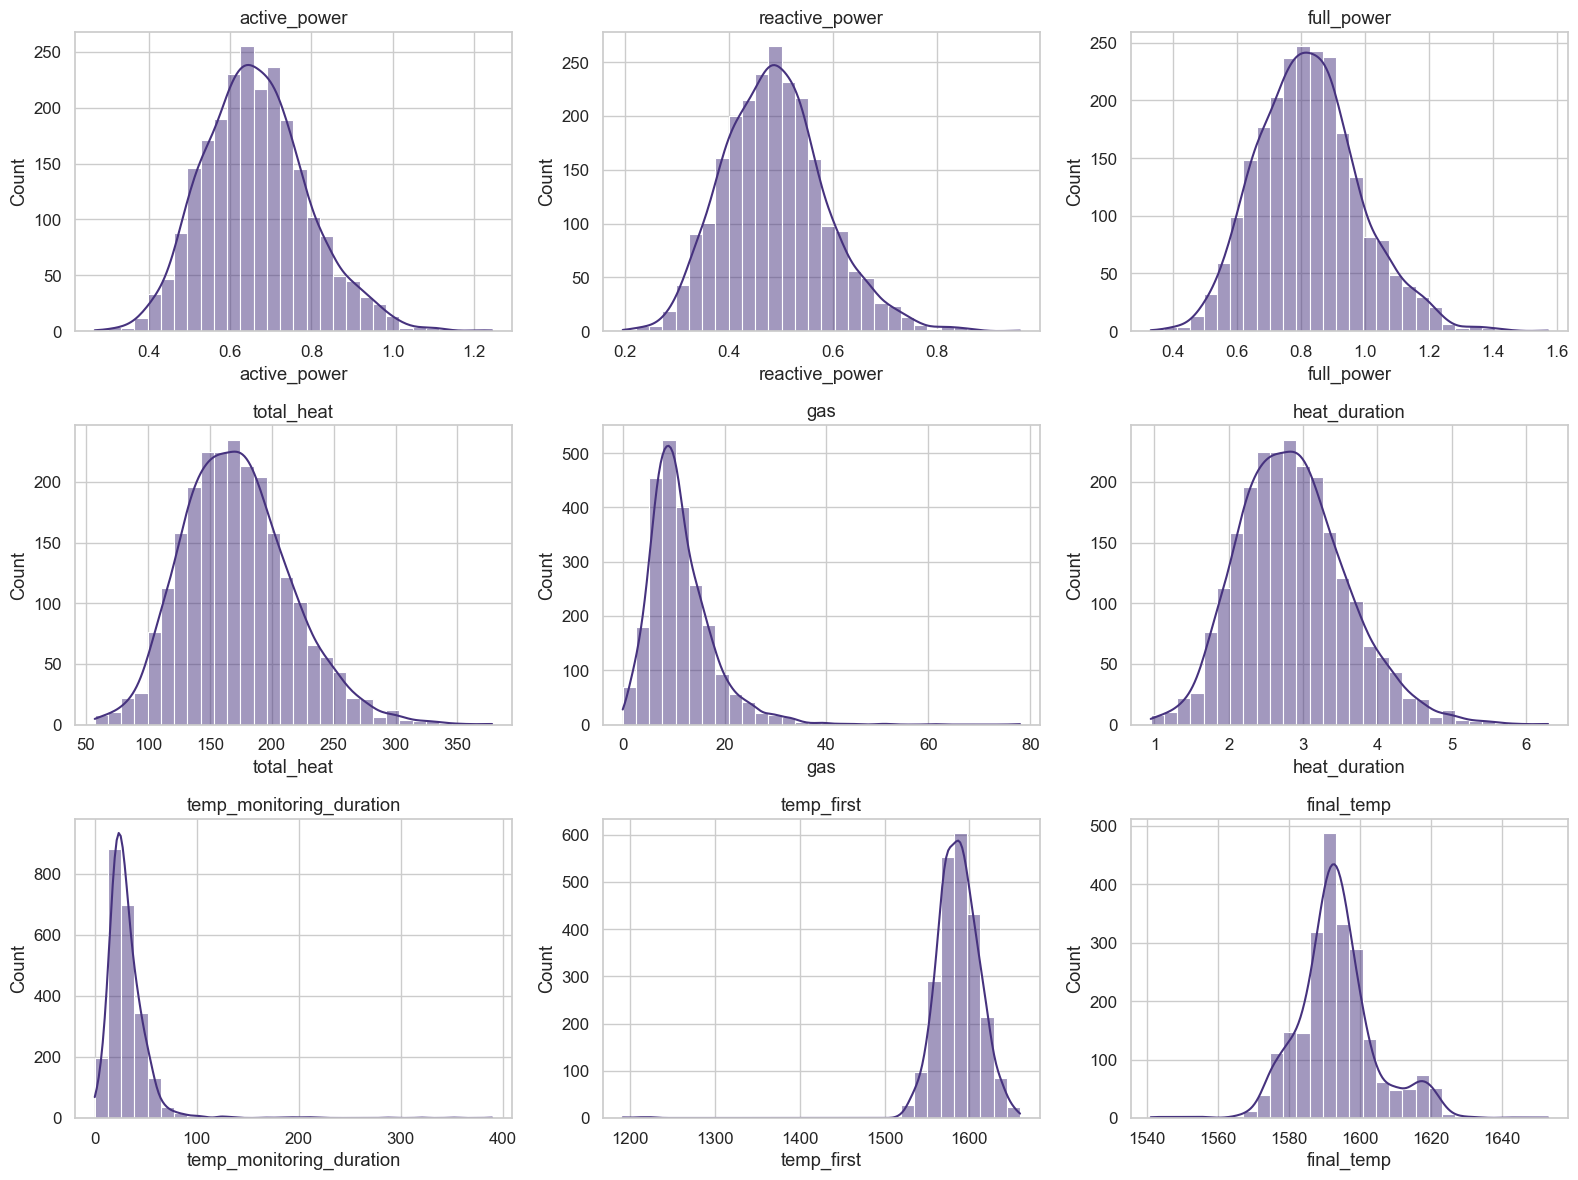

In [65]:
sns.set(style="whitegrid", palette="viridis", font_scale=1.1)

key_features = [
    'active_power', 'reactive_power', 'full_power',
    'total_heat', 'gas', 'heat_duration', 'temp_monitoring_duration',
    'temp_first', 'final_temp'
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(key_features):
    sns.histplot(result_cleaned[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


Все сохранилось, кроме того, можно увидеть как новые признаки имеют хорошее нормальное распределение без диких выбросов.

Построим корреляционную матрицу и выделим топ-10 признаков влияющих друг на друга.

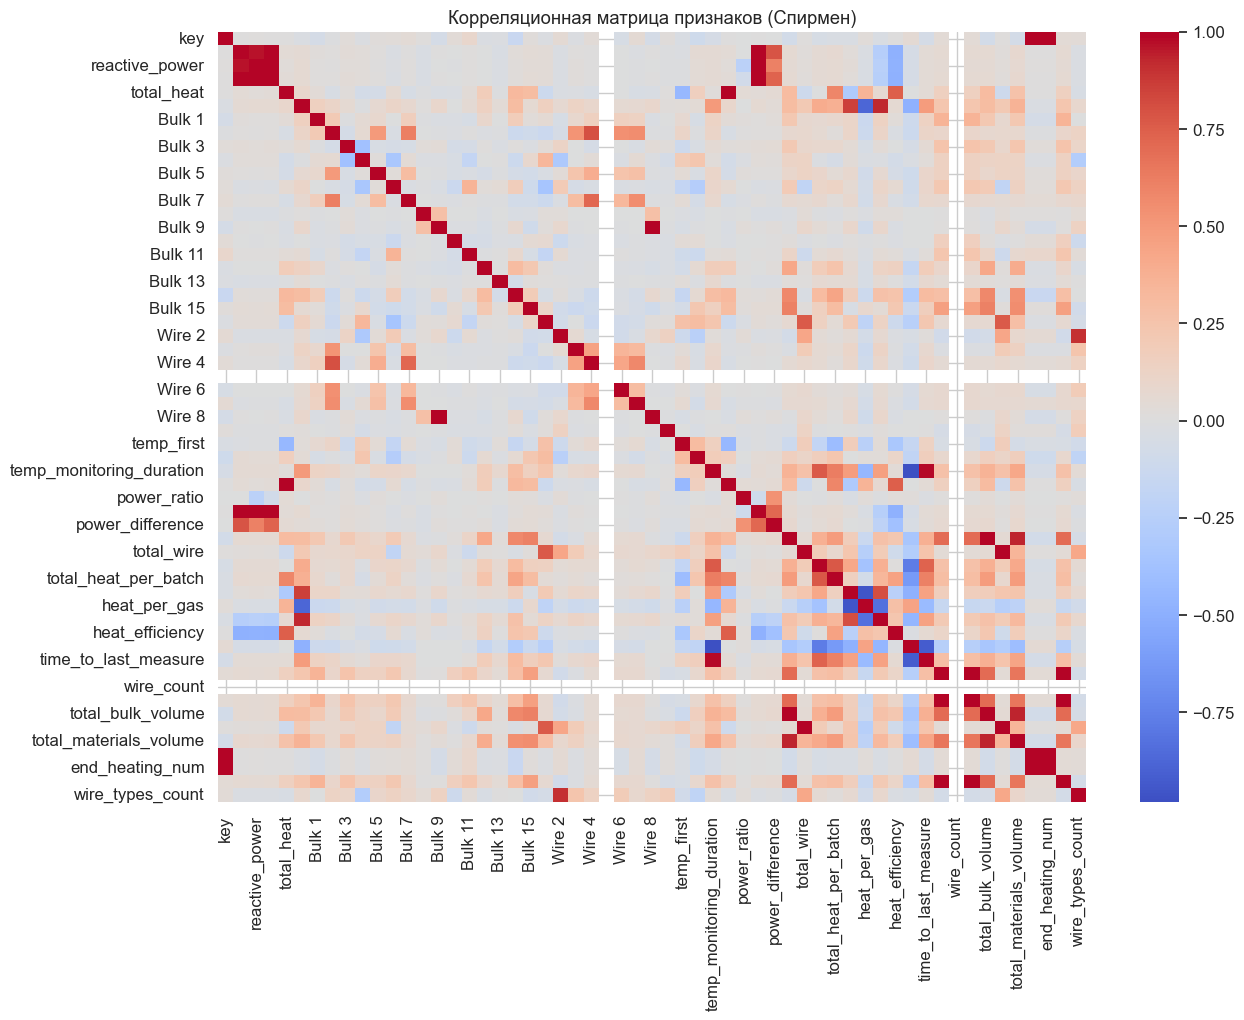

heat_efficiency         1.000000
total_heat              0.748615
heat_duration           0.748600
total_heat_per_batch    0.457794
heat_per_gas            0.275754
Bulk 14                 0.251159
gas_power_ratio         0.238521
total_bulk              0.226616
total_bulk_volume       0.226608
Bulk 15                 0.222819
Name: heat_efficiency, dtype: float64


In [66]:
plt.figure(figsize=(14, 10))
corr_spearman = result_cleaned.corr(method='spearman', numeric_only=True)

sns.heatmap(corr_spearman, cmap='coolwarm', center=0, annot=False)
plt.title("Корреляционная матрица признаков (Спирмен)")
plt.show()

print(corr_spearman['heat_efficiency'].sort_values(ascending=False).head(10))



Основной блок влияния находится в правом нижнем углу таблицы, где присутствуют новые признаки. Значит их создание было полезным.

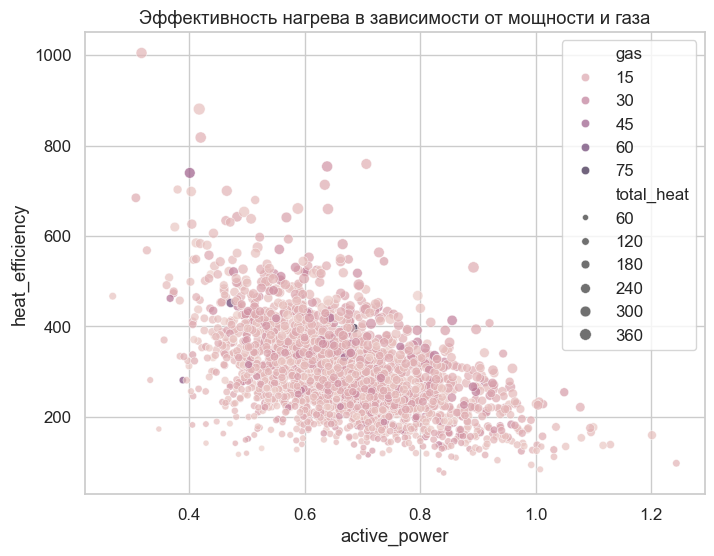

In [67]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=result_cleaned, x='active_power', y='heat_efficiency', hue='gas', size='total_heat', alpha=0.7)
plt.title("Эффективность нагрева в зависимости от мощности и газа")
plt.show()


Зависимость эффективности нагрева от мощности и газа показывает нечеткий график прямой корреляции, что тоже неплохо.

### Вывод по исследовательскому анализу общего датасета

Общий датасет получился достаточно стабильным по корреляционным признакам, нормальному распределению и выбросам. Обработка данных не прошла бесследно и теперь мы можем приступать к построению моделей.

# Обучение моделей

Нам необходимо попробовать разные модели, в основном из трех разновидностей:
- бустинги;
- леса;
- нейросети.
Создадим словарь параметров для каждой модели и будем перебирать их через RandomizedSearchCV. Для каждого обучения будем составлять ряд графиков для наглядной демонстрации результатов работы модели.
После того, как увидим результаты метрики MAE на кросс-валидации, применим лучшую модель к тестовым данным.

## Подготовка данных для обучения

In [68]:
df = result_cleaned.copy()

features = [col for col in df.columns if col not in ['key', 'final_temp']]
X = df[features]
y = df['final_temp']

print(f"Признаки: {len(features)}")

mask = y.notna()
X = X[mask]
y = y[mask]


RANDOM_STATE = 11025

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Признаки: 55
Train: (1748, 55), Test: (583, 55)


## Бустинги

Рассмотрим следующие модели бустингов:
- CatBoost;
- LGBM;
- HistGradient;

In [69]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [3, 5, 7, 9],
    'bagging_temperature': [0, 1, 2],
    'random_strength': [0.5, 1, 2],
    'grow_policy': ['SymmetricTree'],
    'leaf_estimation_iterations': [5, 10]
}

cat_model = CatBoostRegressor(verbose=0, random_state=RANDOM_STATE)
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2
)

random_search.fit(X_train, y_train)

best_params_cat = random_search.best_params_
best_model_cat = random_search.best_estimator_

print(f"\n ЛУЧШИЕ ПАРАМЕТРЫ:")
for param, value in best_params_cat.items():
    print(f"   {param}: {value}")

best_cv_mae = -random_search.best_score_
print(f"\n ЛУЧШИЙ MAE на кросс-валидации: {best_cv_mae:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits

 ЛУЧШИЕ ПАРАМЕТРЫ:
   random_strength: 0.5
   learning_rate: 0.03
   leaf_estimation_iterations: 10
   l2_leaf_reg: 3
   iterations: 1000
   grow_policy: SymmetricTree
   depth: 4
   bagging_temperature: 1

 ЛУЧШИЙ MAE на кросс-валидации: 5.8933


Построим графики для этого обучения:
- фактические и предсказанные значения;
- распределения ошибок;
- важность признаков;
- диаграмма остатков.

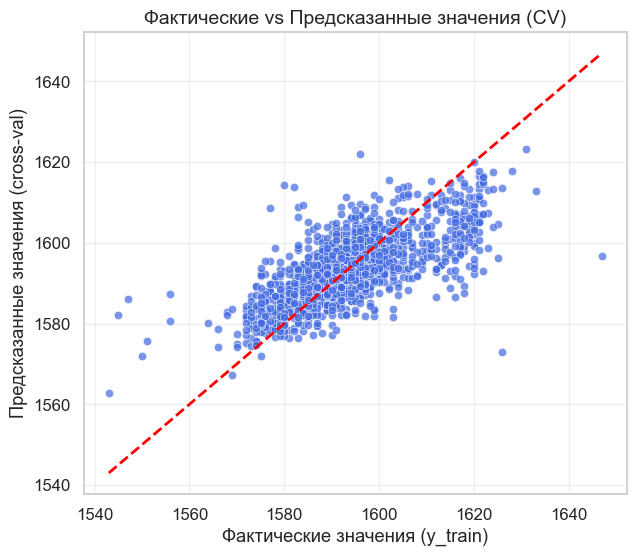

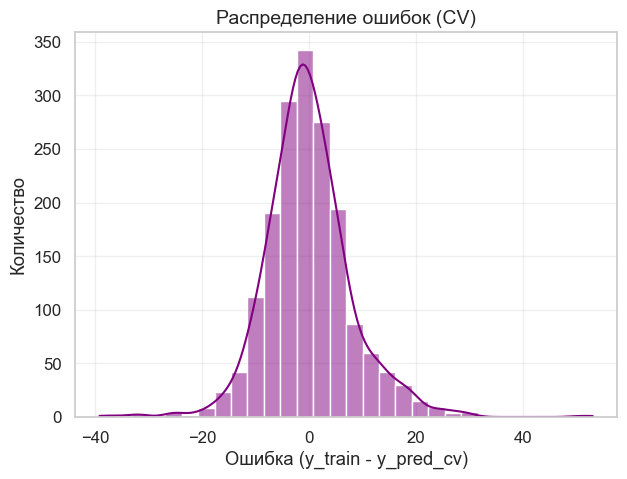

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3793498616.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


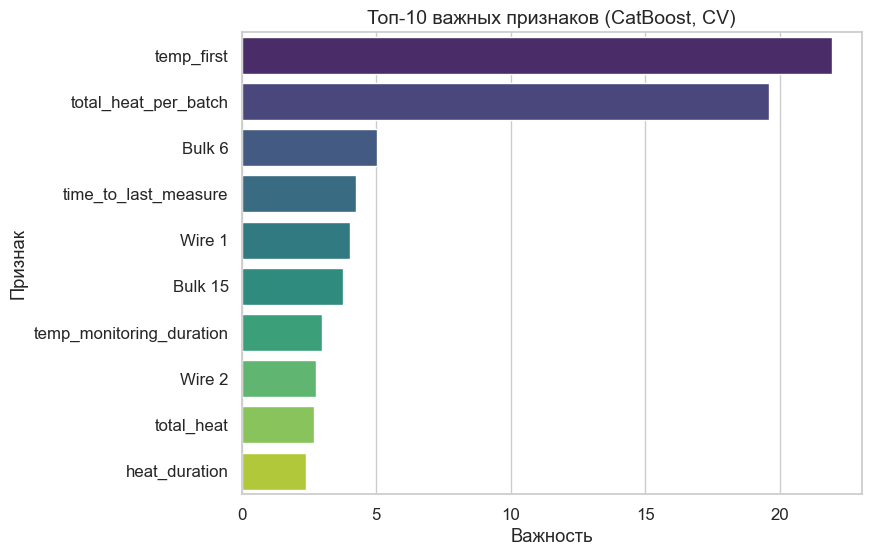

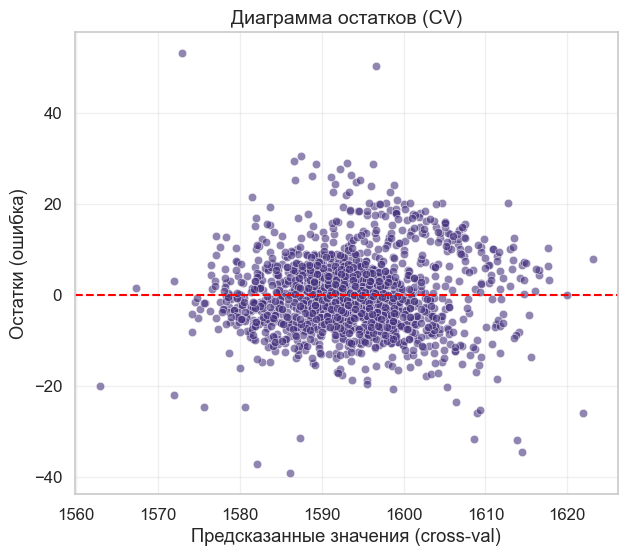

In [70]:
y_pred_cv = cross_val_predict(best_model_cat, X_train, y_train, cv=5, n_jobs=-1)
errors_cv = y_train - y_pred_cv

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_train, y=y_pred_cv, alpha=0.7, color='royalblue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         color='red', linestyle='--', linewidth=2)
plt.title("Фактические vs Предсказанные значения (CV)", fontsize=14)
plt.xlabel("Фактические значения (y_train)")
plt.ylabel("Предсказанные значения (cross-val)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7, 5))
sns.histplot(errors_cv, bins=30, kde=True, color='purple')
plt.title("Распределение ошибок (CV)", fontsize=14)
plt.xlabel("Ошибка (y_train - y_pred_cv)")
plt.ylabel("Количество")
plt.grid(True, alpha=0.3)
plt.show()

feature_importances = best_model_cat.get_feature_importance()
feature_names = X_train.columns

fi_df = (
    pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    .sort_values(by='Importance', ascending=False)
)

fi_top10 = fi_df.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=fi_top10,
    palette='viridis'
)
plt.title("Топ-10 важных признаков (CatBoost, CV)", fontsize=14)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.show()


plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_pred_cv, y=errors_cv, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Диаграмма остатков (CV)", fontsize=14)
plt.xlabel("Предсказанные значения (cross-val)")
plt.ylabel("Остатки (ошибка)")
plt.grid(True, alpha=0.3)
plt.show()


In [71]:
for col in X_train.select_dtypes(include=['datetime64[ns]']).columns:
    X_train[col] = X_train[col].astype('int64') // 10**9
    X_test[col] = X_test[col].astype('int64') // 10**9

lgbm = LGBMRegressor(random_state=RANDOM_STATE)

param_dist = {
    'num_leaves': np.arange(50, 200, 20),
    'max_depth': np.arange(6, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(100, 1200, 100),
    'min_child_samples': np.arange(5, 100, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 5),
    'reg_lambda': np.linspace(0, 1, 5)
}

random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='neg_mean_absolute_error', 
    cv=5, 
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1 
)

random_search_lgbm.fit(X_train, y_train)

print("\nЛУЧШИЕ ПАРАМЕТРЫ LGBM:")
for param, value in random_search_lgbm.best_params_.items():
    print(f"   {param}: {value}")

best_model_lgbm = random_search_lgbm.best_estimator_
best_cv_mae_lgbm = -random_search_lgbm.best_score_

print(f"\nЛУЧШИЙ MAE на кросс-валидации (CV): {best_cv_mae_lgbm:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7679
[LightGBM] [Info] Number of data points in the train set: 1748, number of used features: 41
[LightGBM] [Info] Start training from score 1593.491419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

Аналогичные графики и для LGBMRegressor.

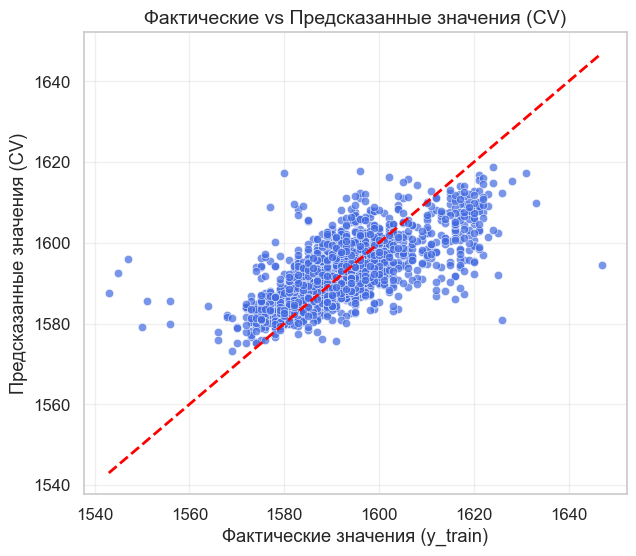

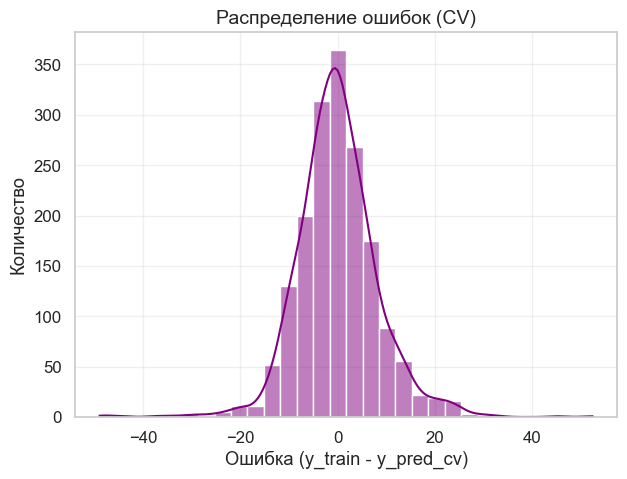

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3581288922.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')


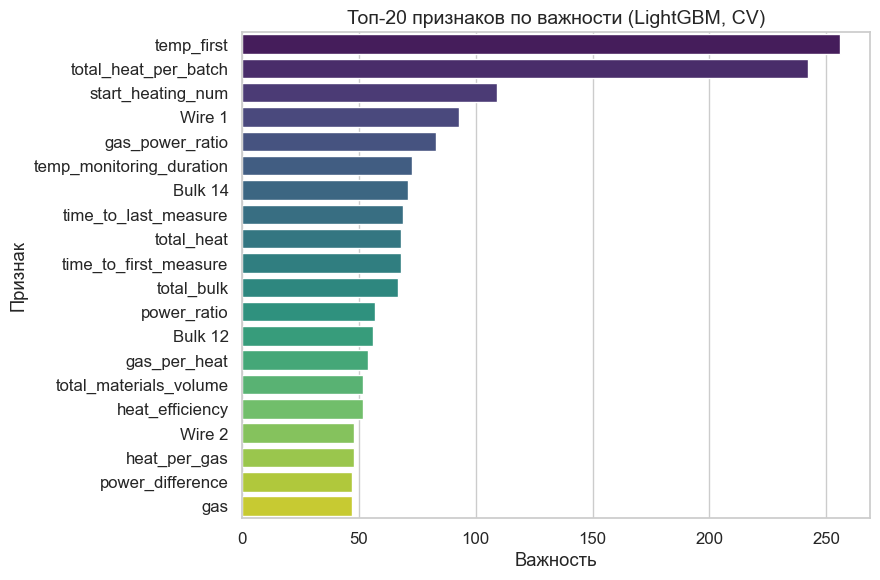

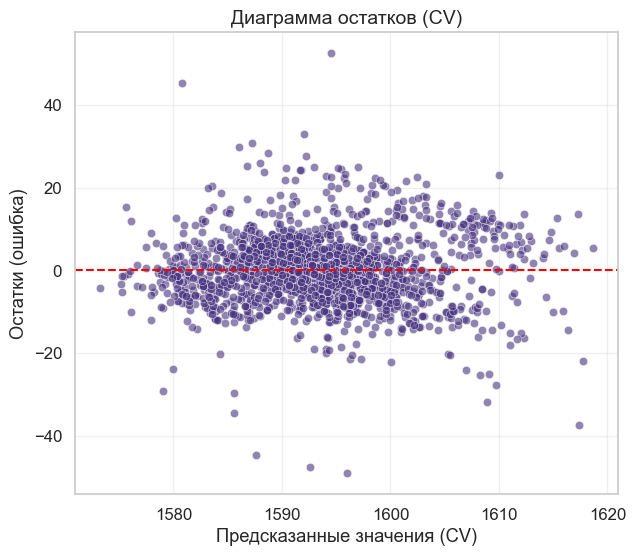

In [72]:
y_pred_cv = cross_val_predict(best_model_lgbm, X_train, y_train, cv=5, n_jobs=-1)

errors_cv = y_train - y_pred_cv

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_train, y=y_pred_cv, alpha=0.7, color='royalblue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         color='red', linestyle='--', linewidth=2)
plt.title("Фактические vs Предсказанные значения (CV)", fontsize=14)
plt.xlabel("Фактические значения (y_train)")
plt.ylabel("Предсказанные значения (CV)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(errors_cv, bins=30, kde=True, color='purple')
plt.title("Распределение ошибок (CV)", fontsize=14)
plt.xlabel("Ошибка (y_train - y_pred_cv)")
plt.ylabel("Количество")
plt.grid(True, alpha=0.3)
plt.show()

importances = best_model_lgbm.feature_importances_
feature_names = X_train.columns

fi_df = (pd.DataFrame({'Feature': feature_names, 'Importance': importances})
         .sort_values(by='Importance', ascending=False))

plt.figure(figsize=(9,6))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title("Топ-20 признаков по важности (LightGBM, CV)", fontsize=14)
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_pred_cv, y=errors_cv, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Диаграмма остатков (CV)", fontsize=14)
plt.xlabel("Предсказанные значения (CV)")
plt.ylabel("Остатки (ошибка)")
plt.grid(True, alpha=0.3)
plt.show()


In [73]:
hgb = HistGradientBoostingRegressor(random_state=RANDOM_STATE)
param_dist = {
    'learning_rate': np.logspace(-3, -1, 10),    
    'max_depth': [3, 5, 7, 9, None],            
    'max_leaf_nodes': [15, 31, 63, 127, 255],    
    'min_samples_leaf': [5, 10, 20, 30, 50],     
    'l2_regularization': np.logspace(-4, 1, 6), 
    'max_bins': [64, 128, 255],
    'learning_rate': np.logspace(-3, -1, 10),
    'max_iter': [100, 200, 400, 800]
}

random_search = RandomizedSearchCV(
    estimator=hgb,
    param_distributions=param_dist,
    n_iter=50,                       
    scoring='neg_mean_absolute_error', 
    cv=5,                            
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший MAE (CV):", -random_search.best_score_)

best_param_hgb = random_search.best_params_
best_score_hgb = -random_search.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'min_samples_leaf': 10, 'max_leaf_nodes': 15, 'max_iter': 100, 'max_depth': None, 'max_bins': 255, 'learning_rate': 0.05994842503189409, 'l2_regularization': 0.01}
Лучший MAE (CV): 6.018888687912842


C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='mean_MAE', y=top10.index, palette='viridis')


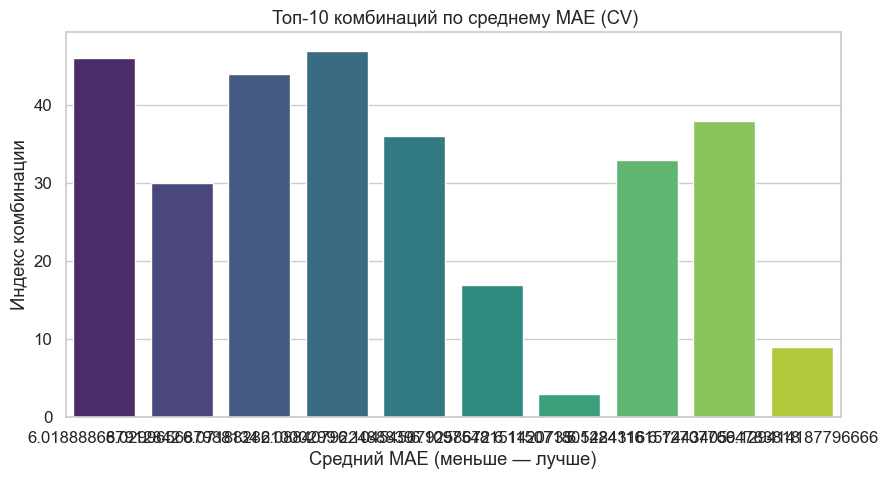

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


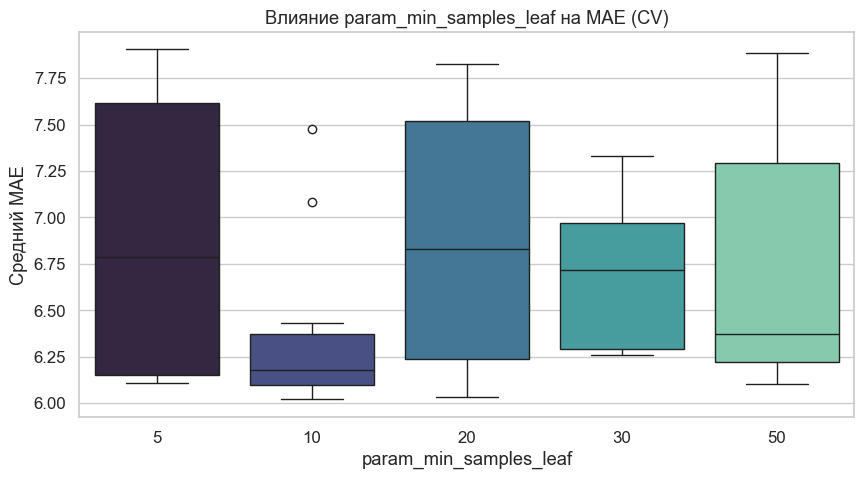

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


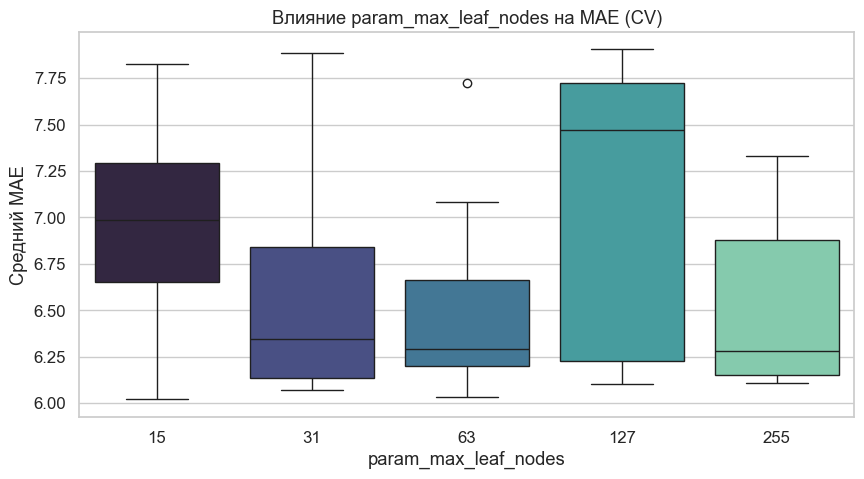

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


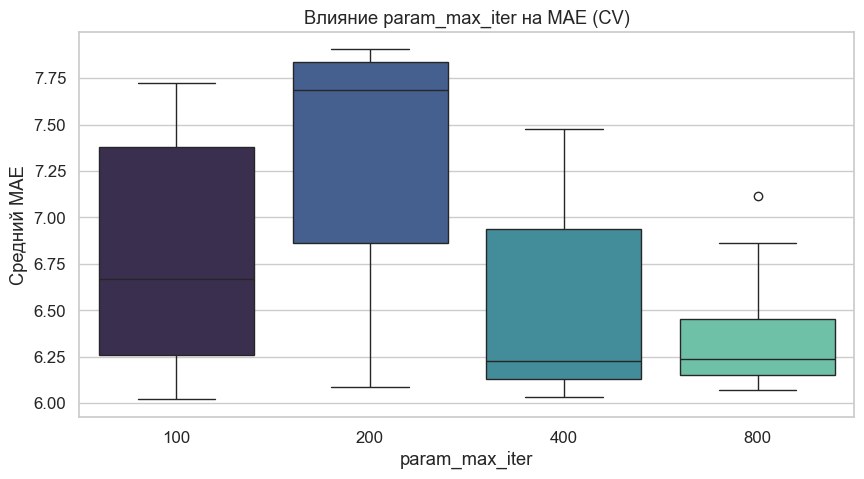

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


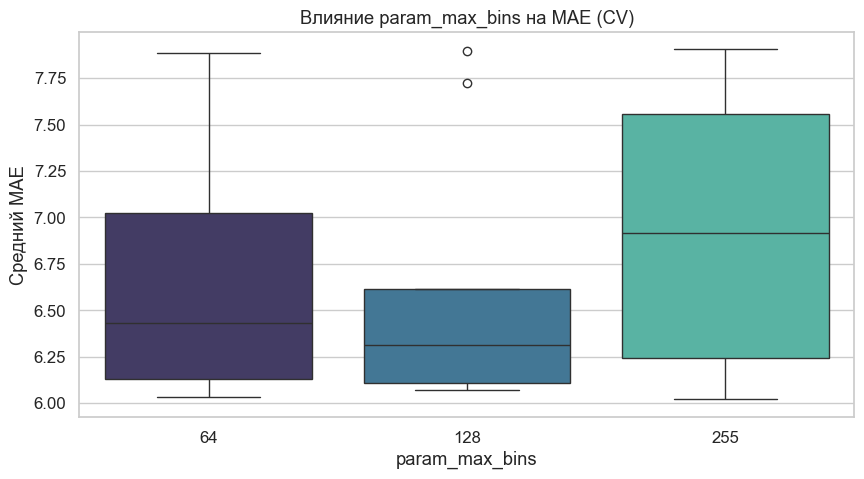

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


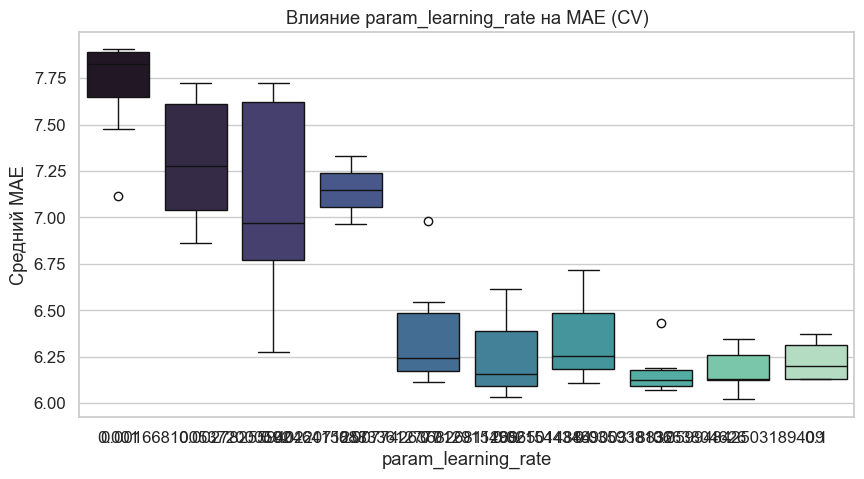

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


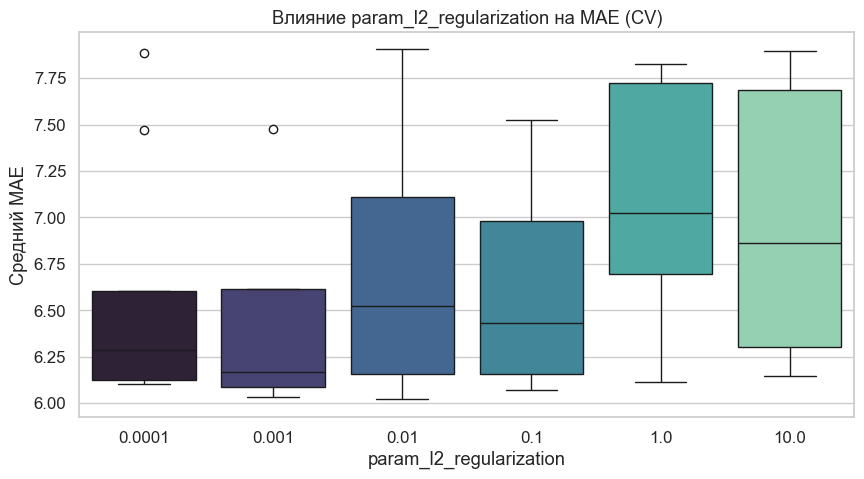

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


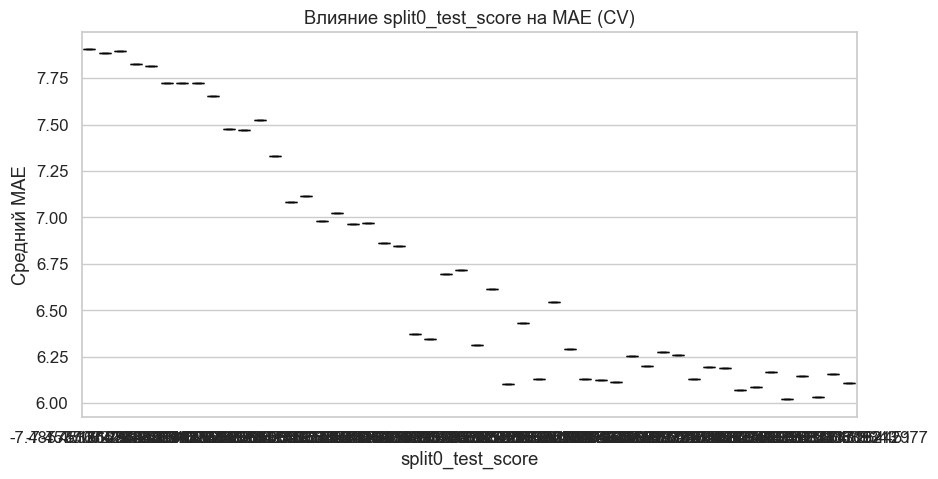

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


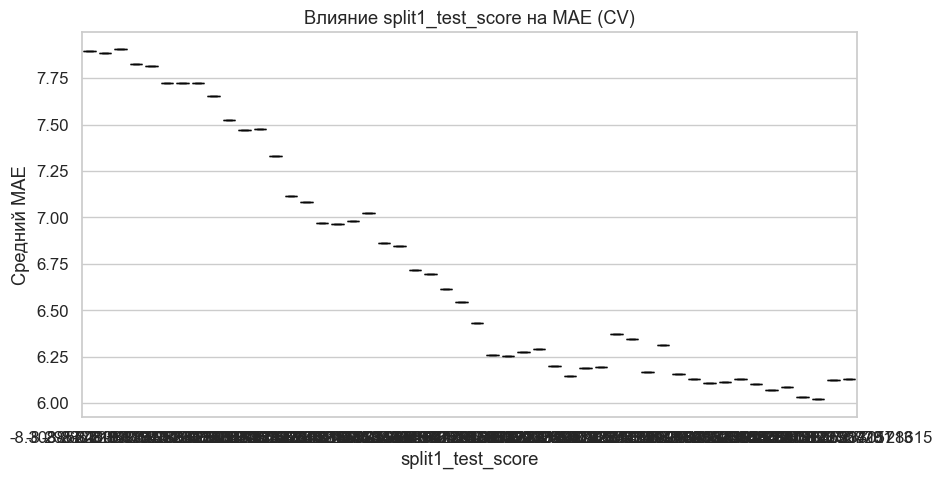

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


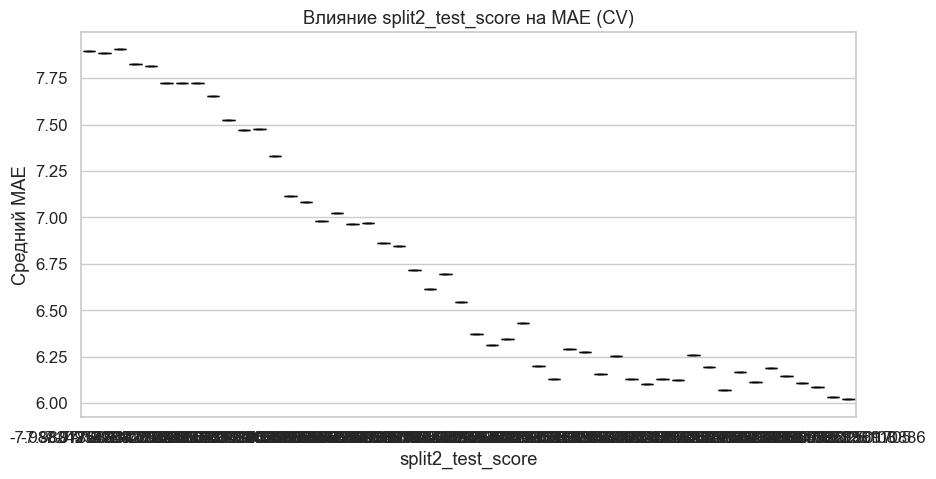

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


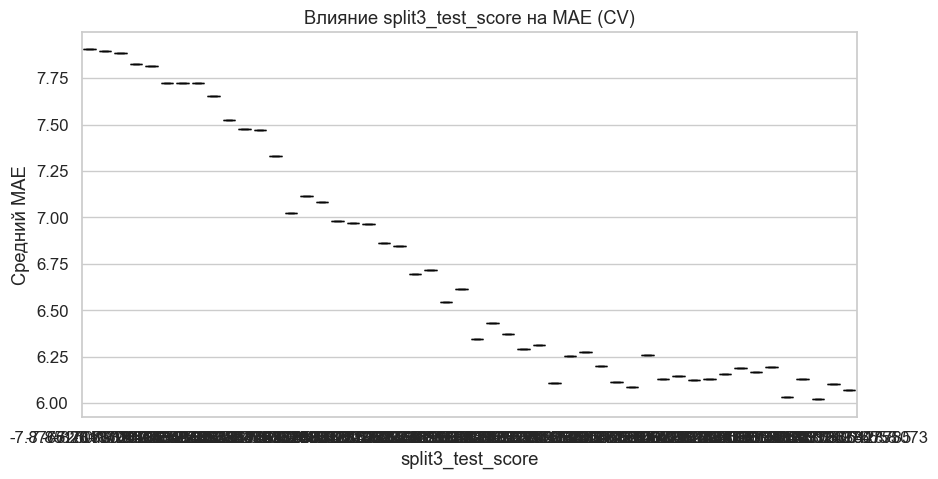

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


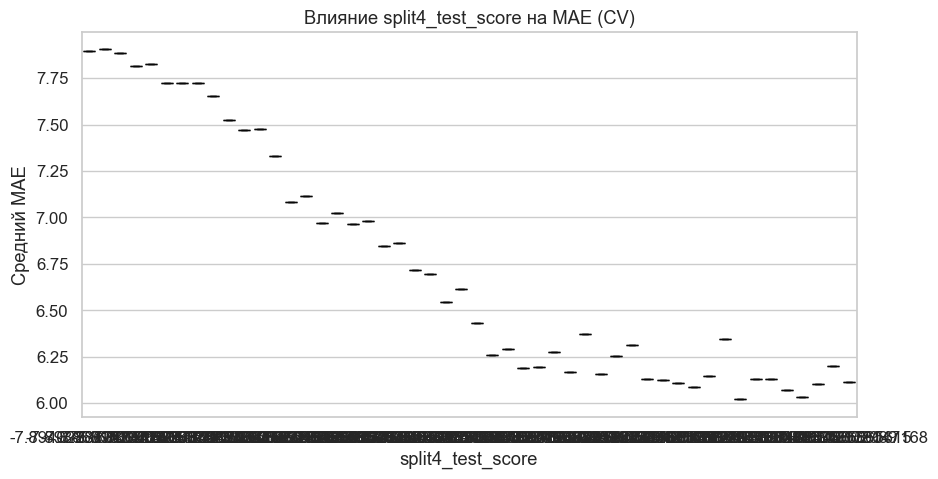

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


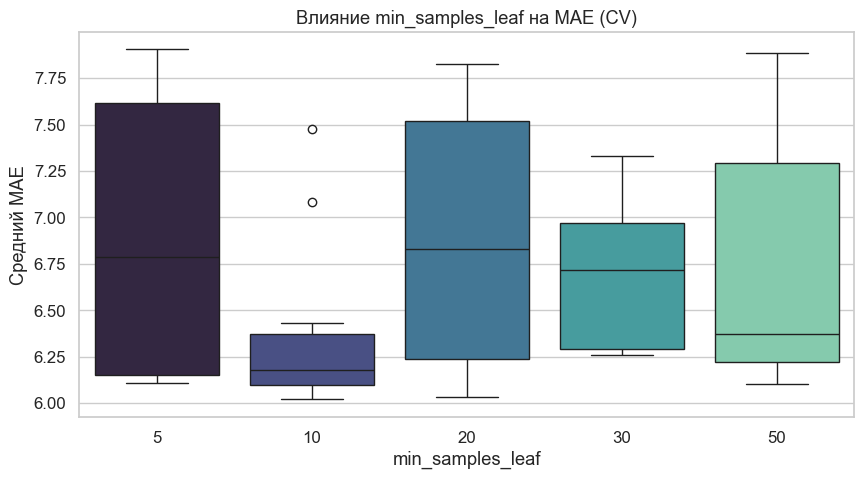

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


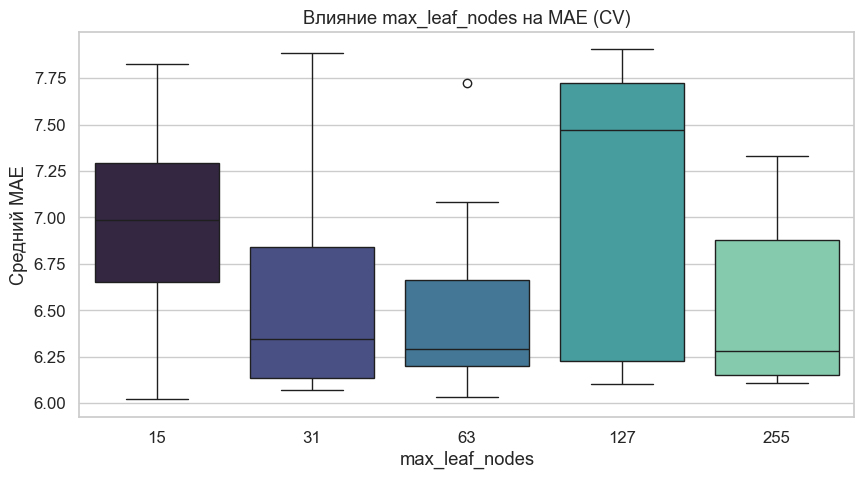

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


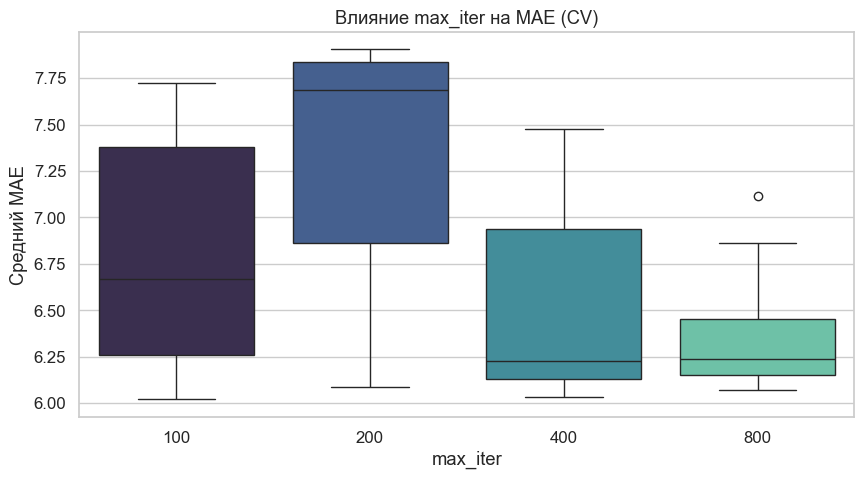

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


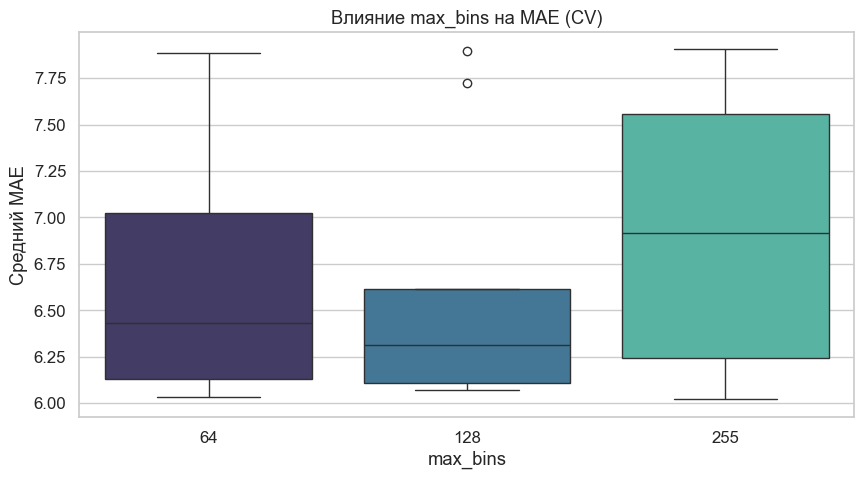

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


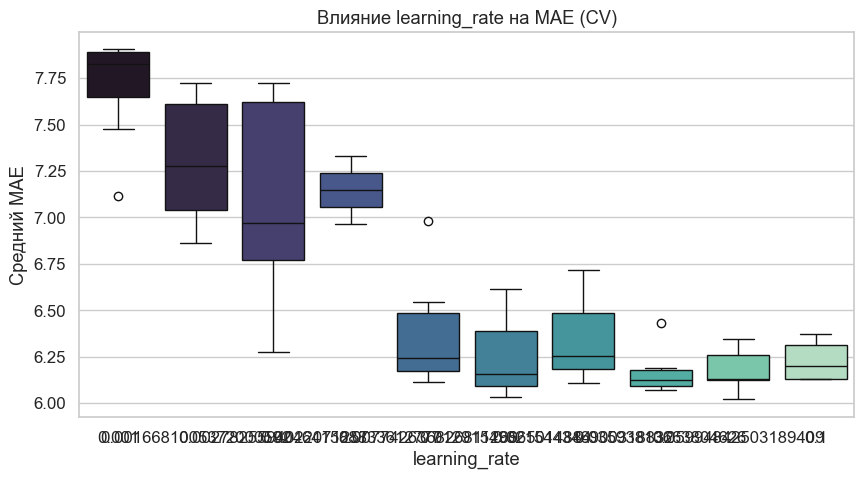

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\356920459.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')


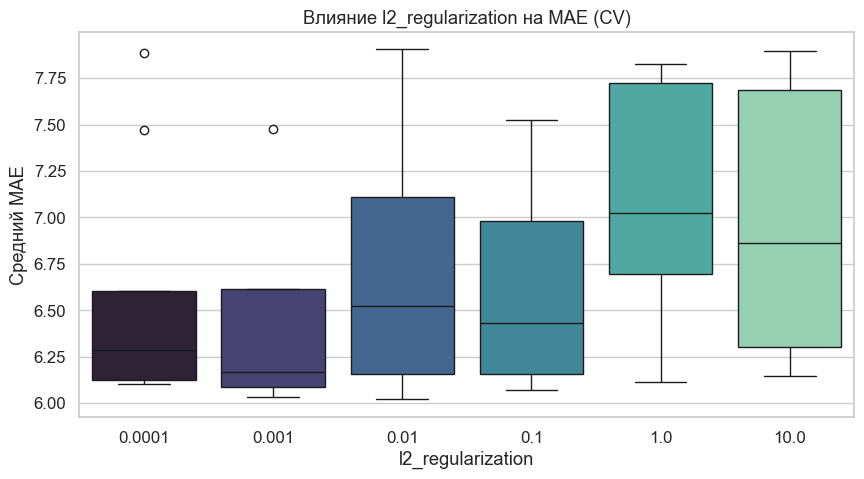

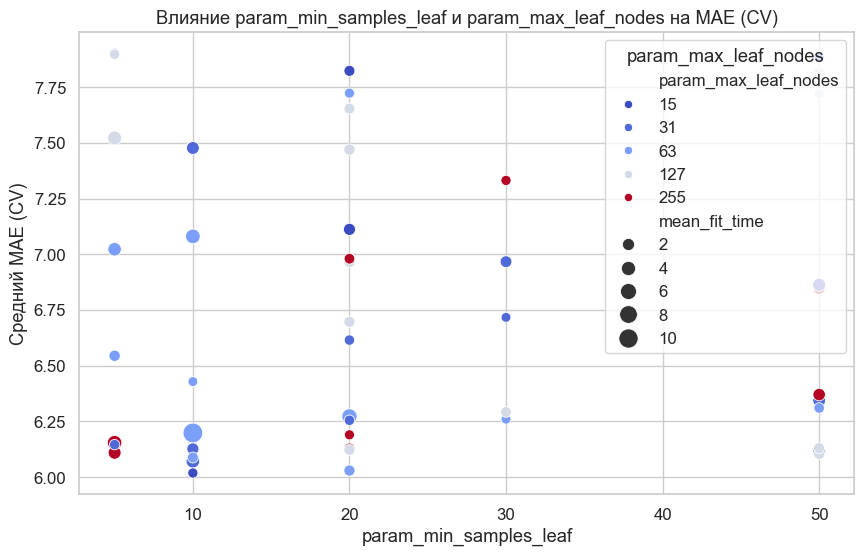

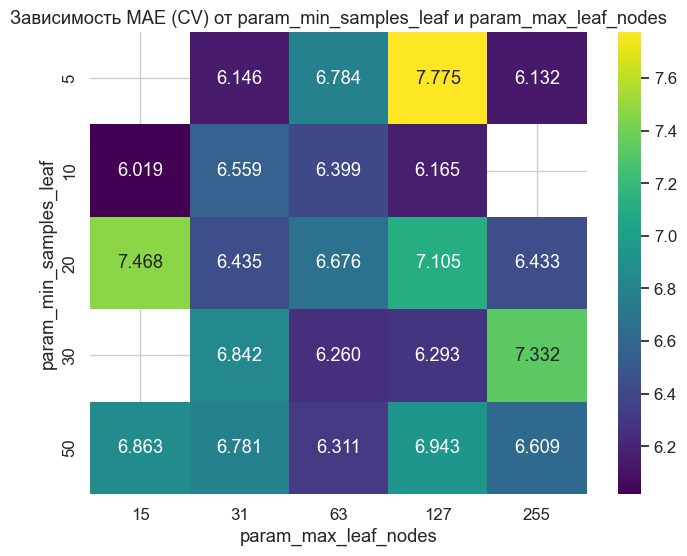

In [74]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['mean_MAE'] = -cv_results['mean_test_score']
cv_results['std_MAE'] = cv_results['std_test_score']

param_cols = [c for c in cv_results.columns if c.startswith('param_')]
for col in param_cols:
    cv_results[col.replace('param_', '')] = cv_results[col]

top10 = cv_results.nsmallest(10, 'mean_MAE')

plt.figure(figsize=(10, 5))
sns.barplot(data=top10, x='mean_MAE', y=top10.index, palette='viridis')
plt.title(" Топ-10 комбинаций по среднему MAE (CV)")
plt.xlabel("Средний MAE (меньше — лучше)")
plt.ylabel("Индекс комбинации")
plt.show()

numeric_params = [c for c in cv_results.columns if c not in [
    'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time', 'std_fit_time',
    'mean_score_time', 'std_score_time', 'params', 'mean_MAE', 'std_MAE'
] and pd.api.types.is_numeric_dtype(cv_results[c])]

for param in numeric_params:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=cv_results, x=param, y='mean_MAE', palette='mako')
    plt.title(f"Влияние {param} на MAE (CV)")
    plt.xlabel(param)
    plt.ylabel("Средний MAE")
    plt.show()

if len(numeric_params) >= 2:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=cv_results,
        x=numeric_params[0],
        y='mean_MAE',
        hue=numeric_params[1],
        size='mean_fit_time',
        sizes=(50, 200),
        palette='coolwarm'
    )
    plt.title(f"Влияние {numeric_params[0]} и {numeric_params[1]} на MAE (CV)")
    plt.xlabel(numeric_params[0])
    plt.ylabel("Средний MAE (CV)")
    plt.legend(title=numeric_params[1])
    plt.show()

if len(numeric_params) >= 2:
    pivot = cv_results.pivot_table(
        values='mean_MAE',
        index=numeric_params[0],
        columns=numeric_params[1],
        aggfunc='mean'
    )
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
    plt.title(f"Зависимость MAE (CV) от {numeric_params[0]} и {numeric_params[1]}")
    plt.xlabel(numeric_params[1])
    plt.ylabel(numeric_params[0])
    plt.show()

## Леса

Возьмем:
- RandomForestRegressor;
- DecisionTreeRegressor;

In [75]:
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

param_dist = {
    'n_estimators': np.arange(100, 1001, 100),     
    'max_depth': [None, 5, 10, 15, 20, 30, 50],    
    'min_samples_split': [2, 5, 10, 20],           
    'min_samples_leaf': [1, 2, 4, 8, 16],          
    'max_features': ['sqrt', 'log2', 0.5, 0.7, 1.0], 
    'bootstrap': [True, False]                     
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                        
    scoring='neg_mean_absolute_error',
    cv=5,                             
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший MAE (CV):", -random_search.best_score_)

best_score_rf = -random_search.best_score_
best_param_rf = random_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'n_estimators': 700, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 1.0, 'max_depth': 20, 'bootstrap': True}
Лучший MAE (CV): 6.200637584323616


C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


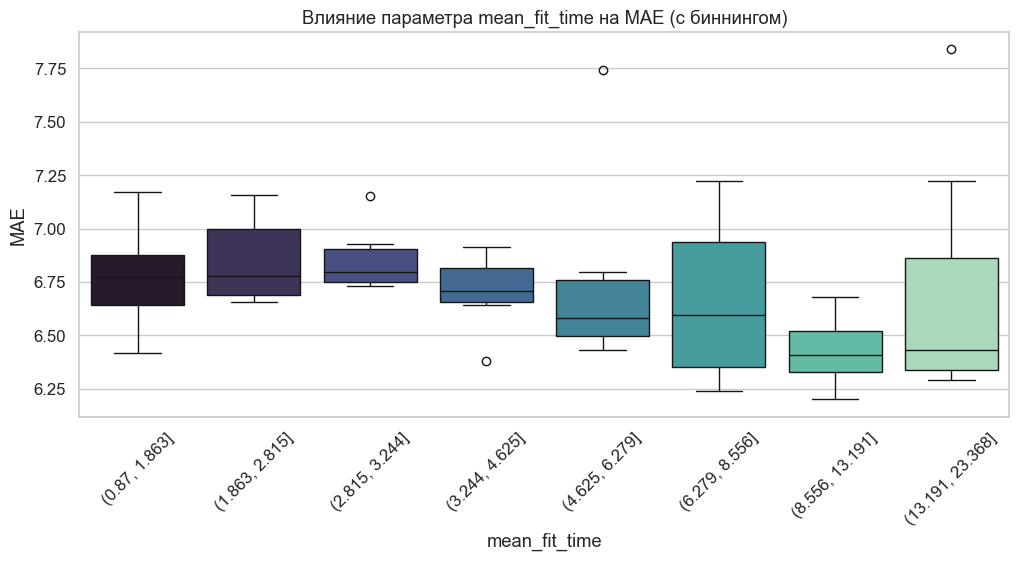

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


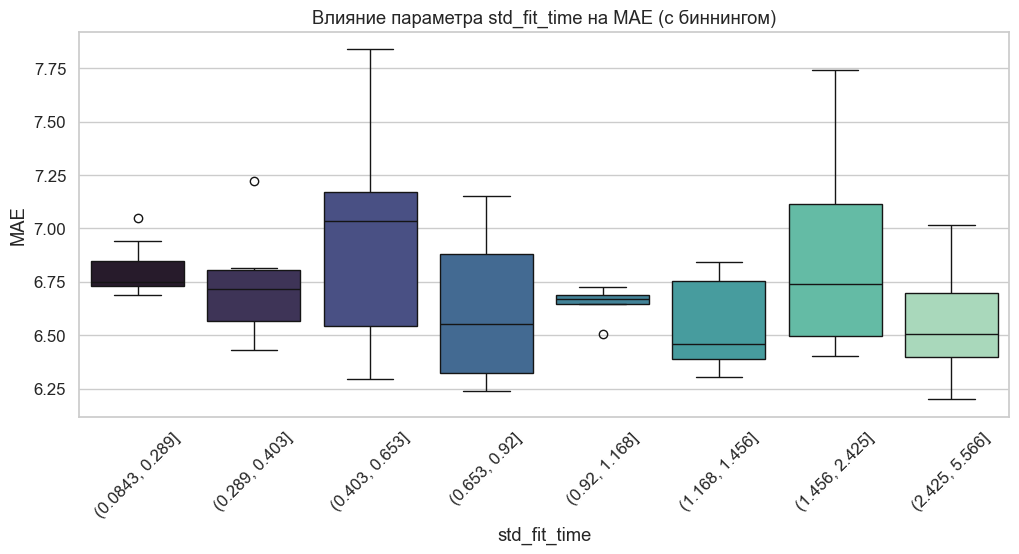

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


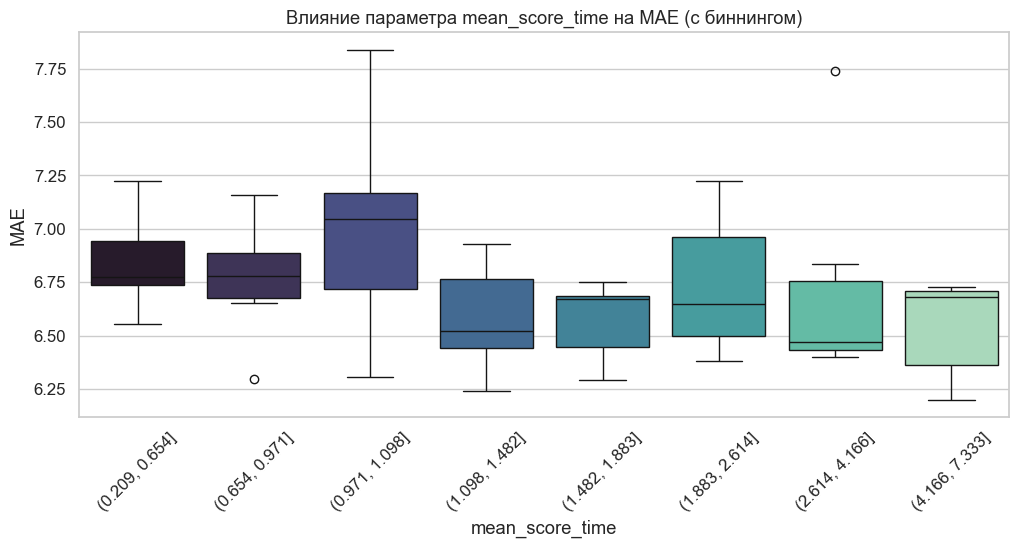

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


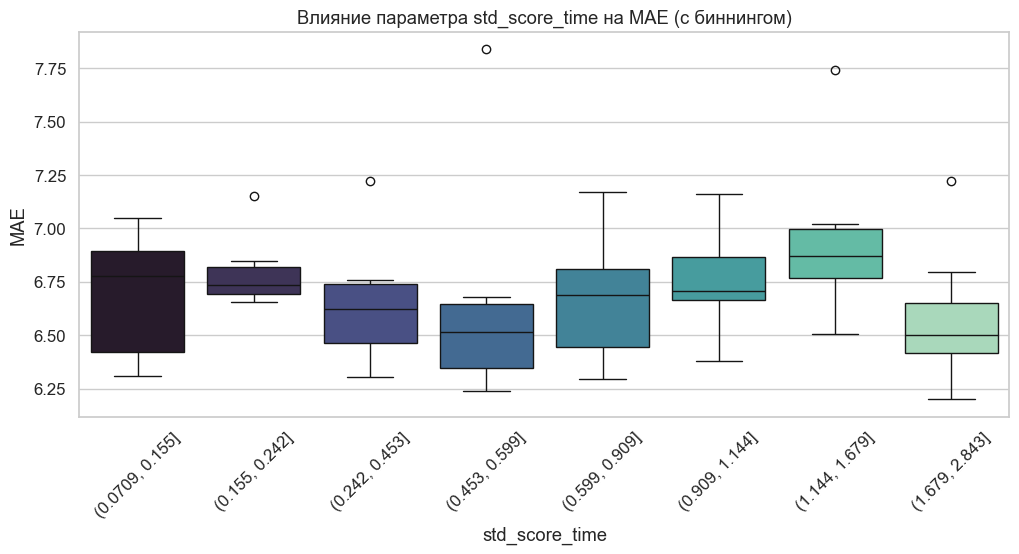

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


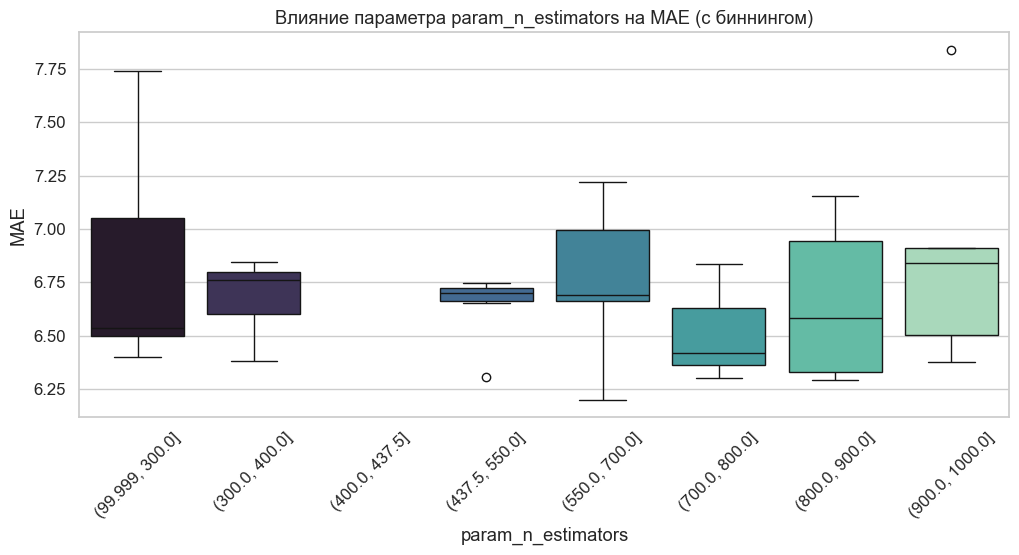

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


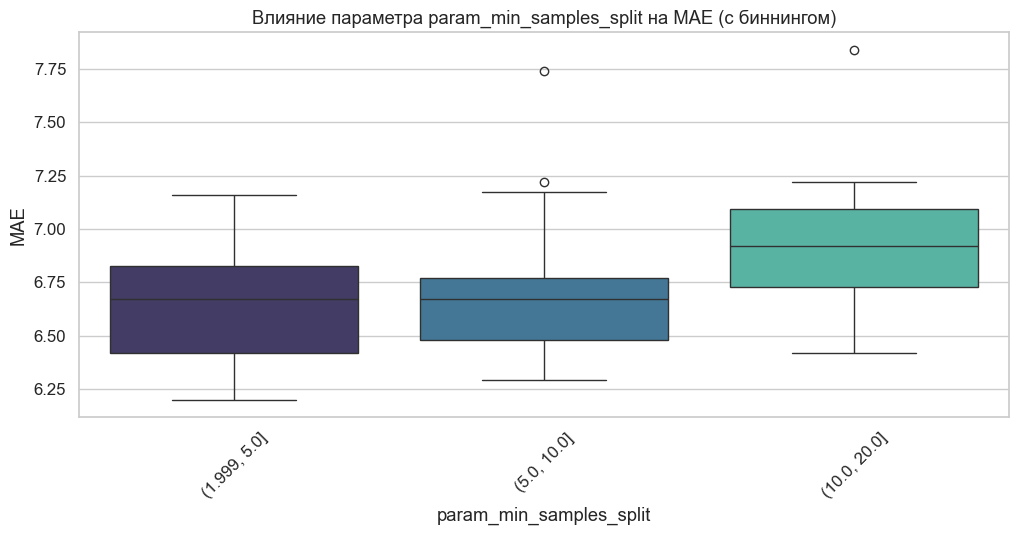

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


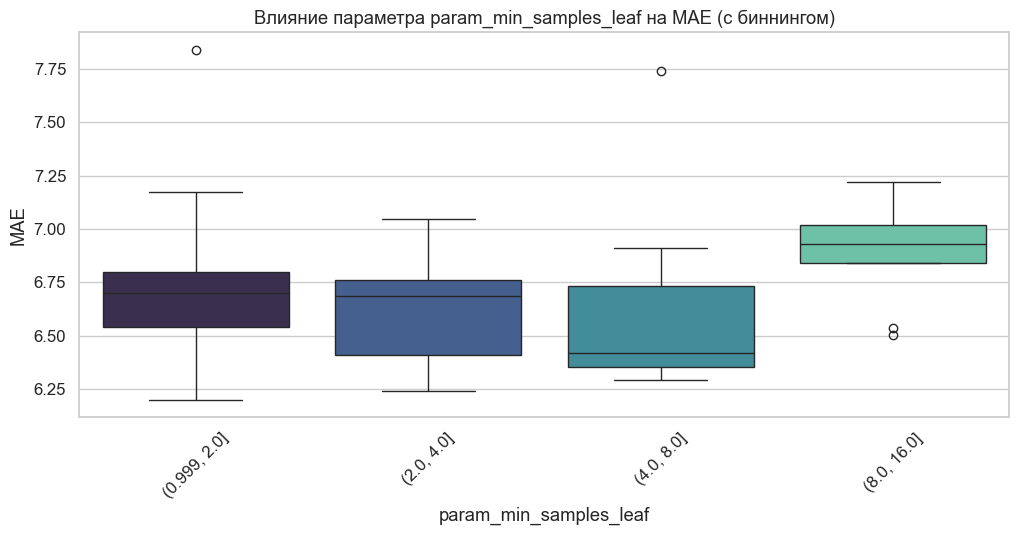

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


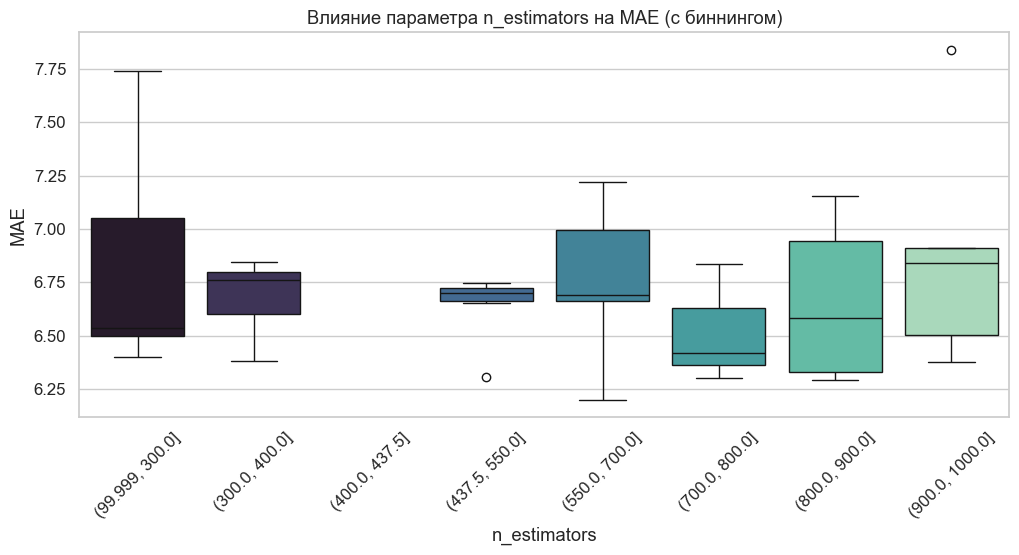

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


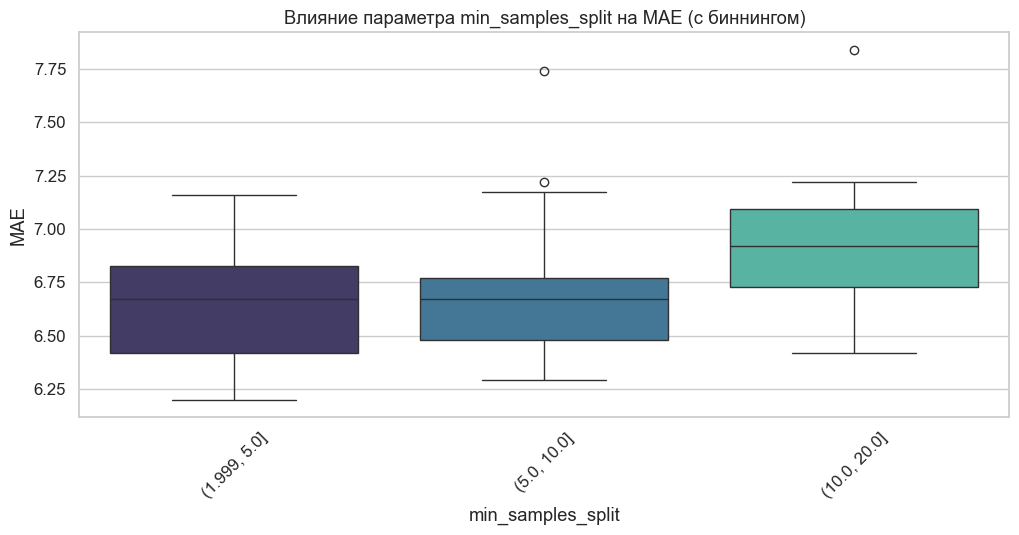

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


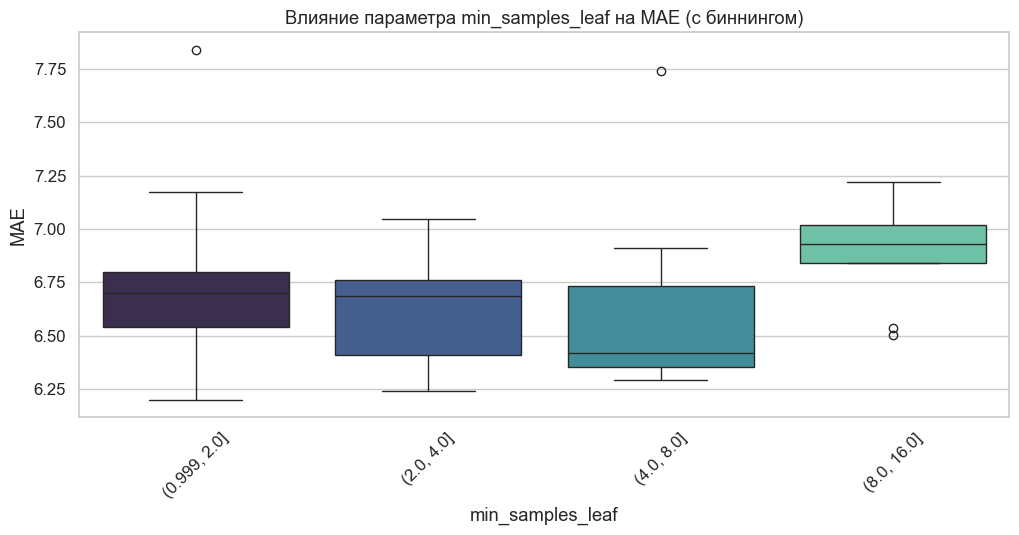

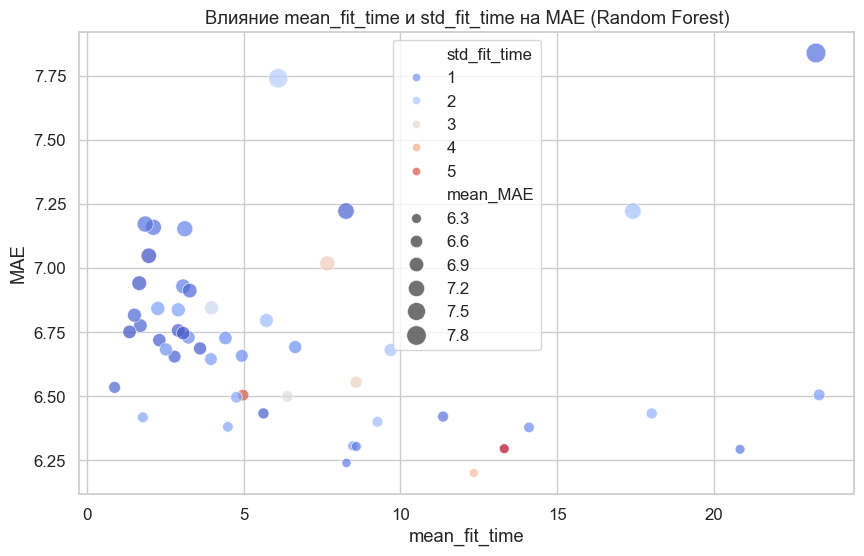

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\4156826807.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi, x="Importance", y="Feature", palette="viridis")


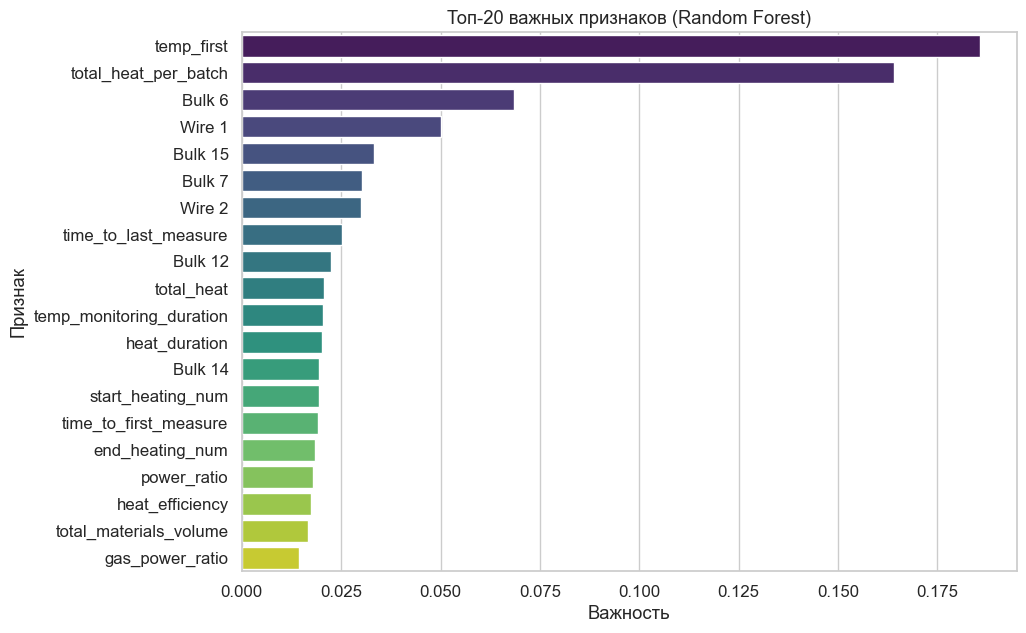

In [76]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results["mean_MAE"] = -cv_results["mean_test_score"]
cv_results["std_MAE"] = cv_results["std_test_score"]
param_cols = [c for c in cv_results.columns if c.startswith("param_")]

for col in param_cols:
    clean = col.split('__')[-1].replace("param_", "")
    cv_results[clean] = cv_results[col]

exclude_cols = {
    "mean_test_score", "std_test_score", "rank_test_score",
    "mean_MAE", "std_MAE",
    "split0_test_score", "split1_test_score",
    "split2_test_score", "split3_test_score", "split4_test_score"
}

num_params = [
    c for c in cv_results.columns
    if c not in exclude_cols and cv_results[c].dtype in [int, float]
]

for param in num_params:
    cv_results[param + "_bin"] = pd.qcut(cv_results[param], q=8, duplicates="drop")

    plt.figure(figsize=(12, 5))
    sns.boxplot(
        data=cv_results,
        x=param + "_bin",
        y="mean_MAE",
        palette="mako"
    )
    plt.xticks(rotation=45)
    plt.title(f"Влияние параметра {param} на MAE (с биннингом)")
    plt.xlabel(param)
    plt.ylabel("MAE")
    plt.show()

if len(num_params) >= 2:
    p1, p2 = num_params[:2]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=cv_results,
        x=p1,
        y="mean_MAE",
        hue=p2,
        palette="coolwarm",
        size="mean_MAE",
        sizes=(40, 200),
        alpha=0.7
    )
    plt.title(f"Влияние {p1} и {p2} на MAE (Random Forest)")
    plt.xlabel(p1)
    plt.ylabel("MAE")
    plt.show()

rf_best = random_search.best_estimator_

importances = rf_best.feature_importances_
fi = pd.DataFrame({"Feature": X_train.columns, "Importance": importances})
fi = fi.sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(data=fi, x="Importance", y="Feature", palette="viridis")
plt.title("Топ-20 важных признаков (Random Forest)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.show()


In [77]:
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

param_dist = {
    'max_depth': np.arange(2, 30, 2),          
    'min_samples_split': np.arange(2, 21, 2),  
    'min_samples_leaf': np.arange(1, 21, 2),   
    'max_features': ['auto', 'sqrt', 'log2', None],  
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
}

random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_dist,
    n_iter=50,                         
    scoring='neg_mean_absolute_error', 
    cv=5,                              
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший MAE (CV):", -random_search.best_score_)

best_param_dt = random_search.best_params_
best_score_dt = -random_search.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 10, 'criterion': 'friedman_mse'}
Лучший MAE (CV): 7.456974957688507


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
55 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
29 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


Числовые параметры: ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'min_samples_split', 'min_samples_leaf', 'max_depth']


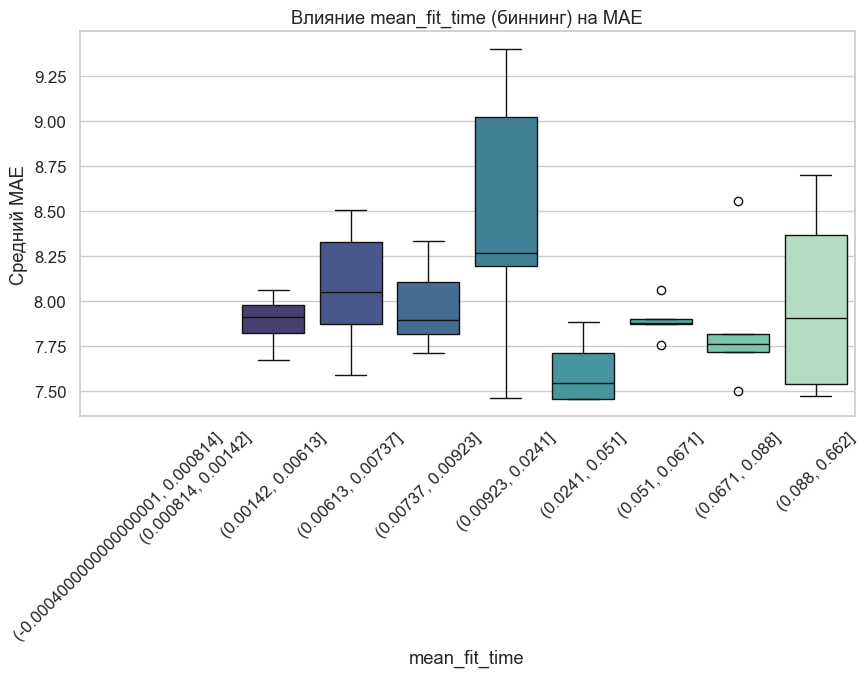

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


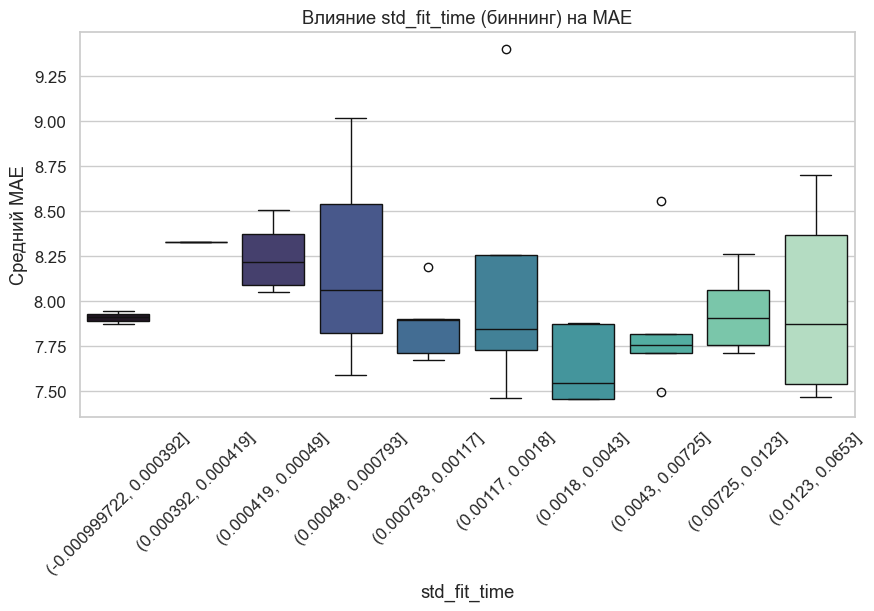

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


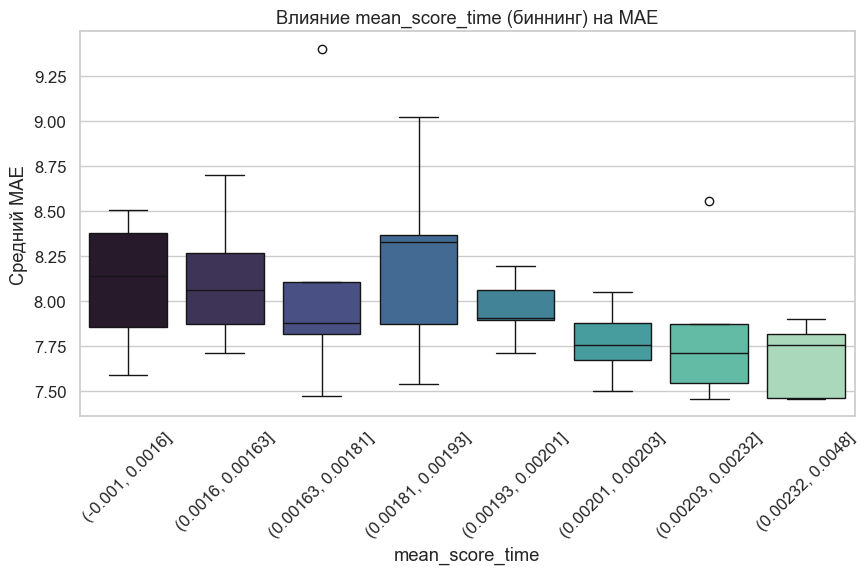

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


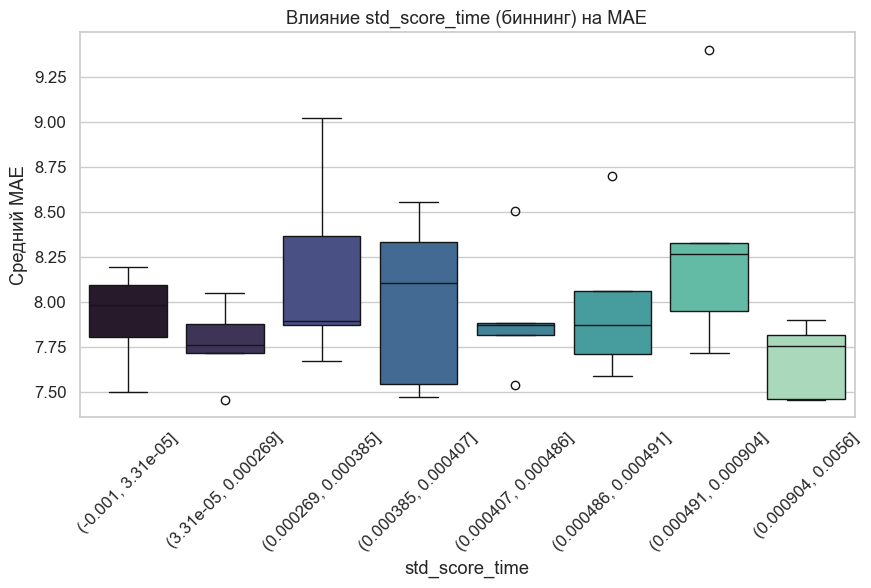

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


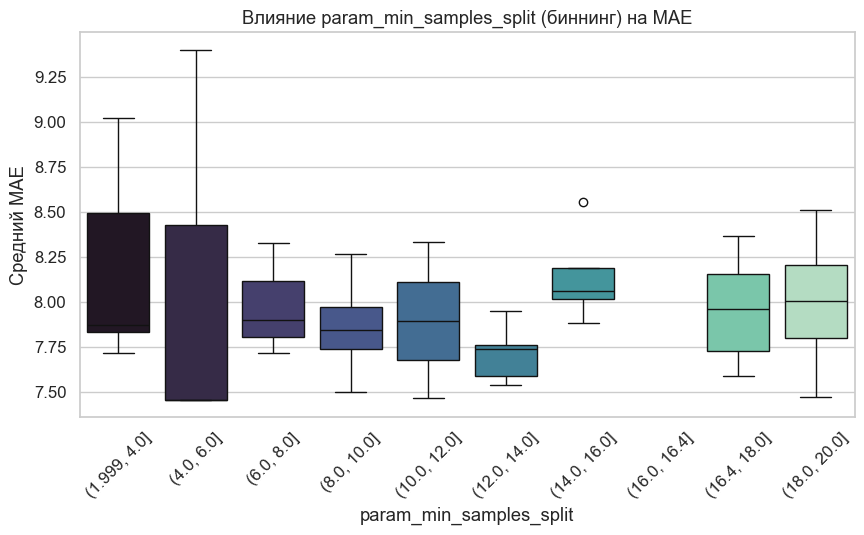

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


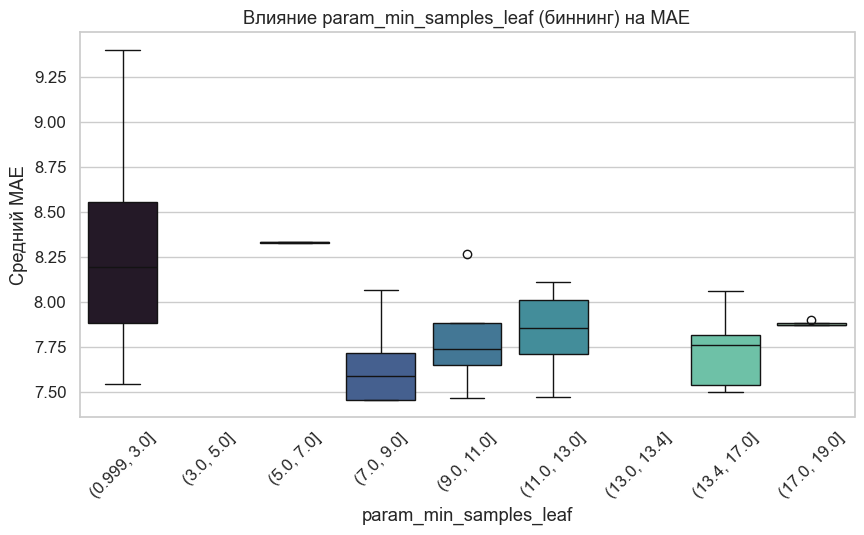

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


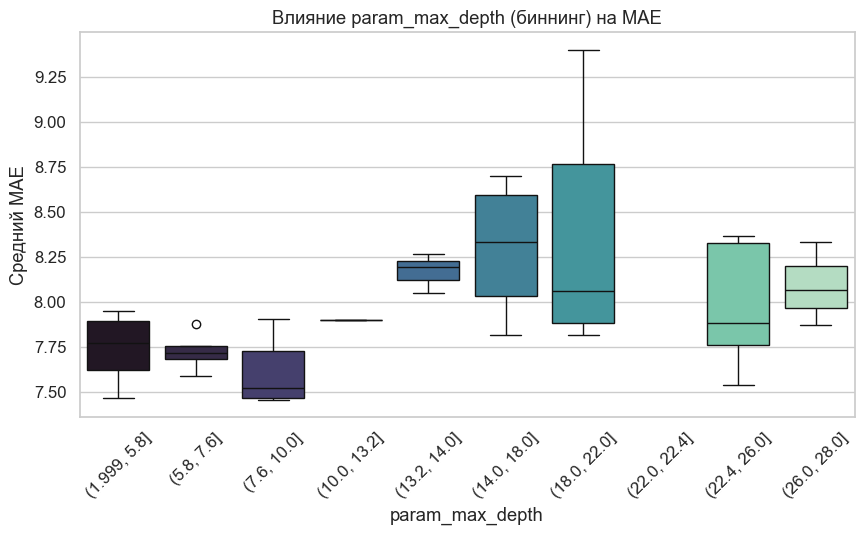

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


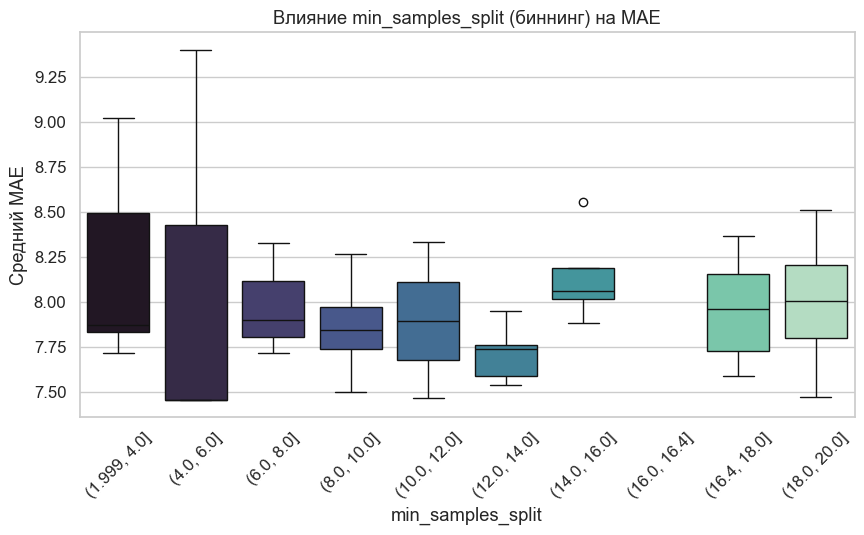

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


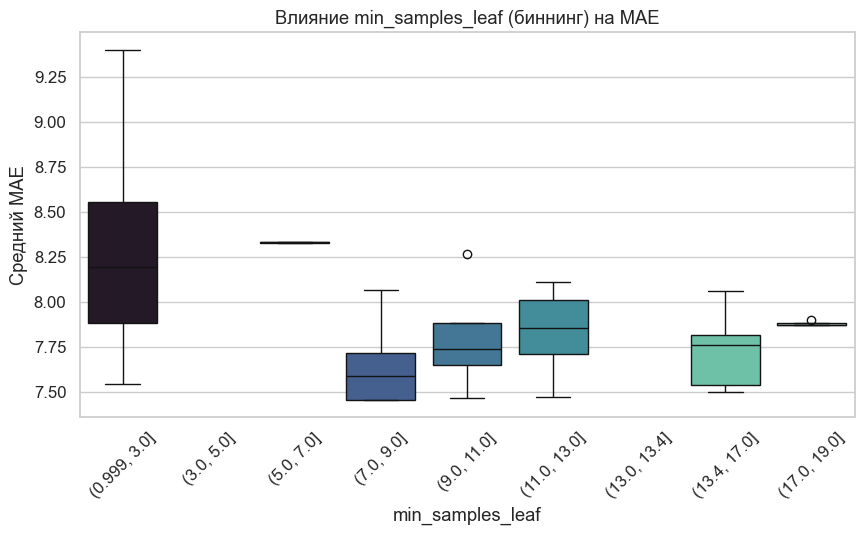

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\3822091825.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")


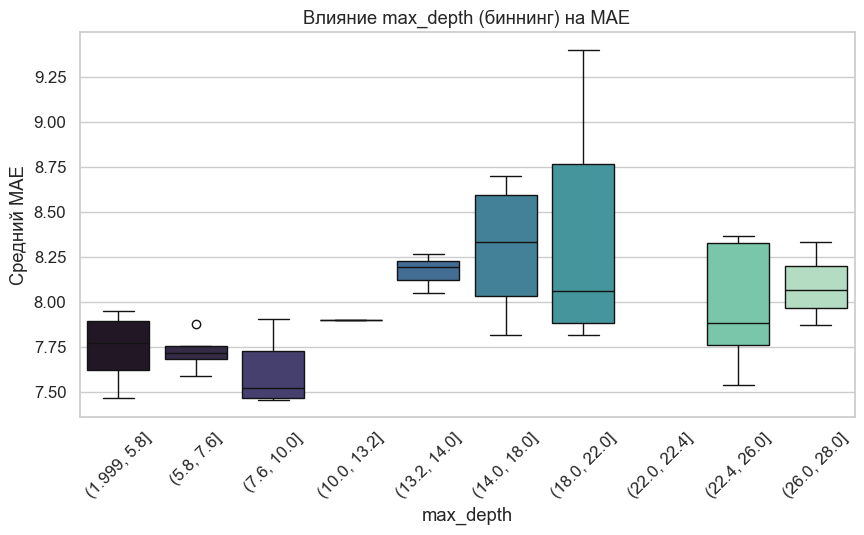

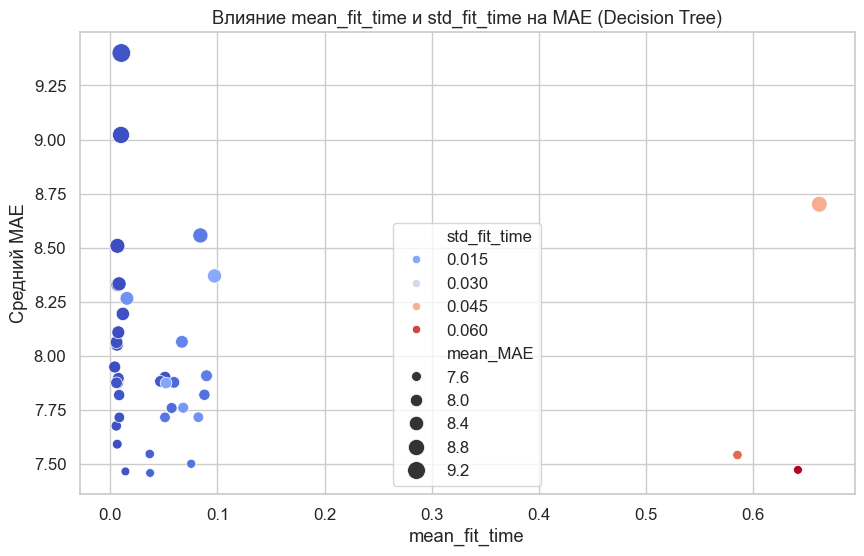

In [78]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results['mean_MAE'] = -cv_results['mean_test_score']
cv_results['std_MAE'] = cv_results['std_test_score']
param_cols = [c for c in cv_results.columns if c.startswith('param_')]
for col in param_cols:
    clean = col.split('__')[-1].replace("param_", "")
    cv_results[clean] = cv_results[col]
exclude_cols = {
    'mean_test_score', 'std_test_score', 'rank_test_score',
    'mean_MAE', 'std_MAE',
    'split0_test_score', 'split1_test_score',
    'split2_test_score', 'split3_test_score', 'split4_test_score'
}
num_params = [
    c for c in cv_results.columns
    if c not in exclude_cols and cv_results[c].dtype in [int, float]
]

print("Числовые параметры:", num_params)

for param in num_params:
    cv_results[param + "_bin"] = pd.qcut(cv_results[param], q=10, duplicates='drop')

    plt.figure(figsize=(10, 5))
    sns.boxplot(data=cv_results, x=param + "_bin", y="mean_MAE", palette="mako")
    plt.xticks(rotation=45)
    plt.title(f"Влияние {param} (биннинг) на MAE")
    plt.xlabel(param)
    plt.ylabel("Средний MAE")
    plt.show()

if len(num_params) >= 2:
    p1, p2 = num_params[:2]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=cv_results,
        x=p1,
        y='mean_MAE',
        hue=p2,
        palette='coolwarm',
        size='mean_MAE',
        sizes=(40, 180)
    )
    plt.title(f"Влияние {p1} и {p2} на MAE (Decision Tree)")
    plt.xlabel(p1)
    plt.ylabel("Средний MAE")
    plt.show()


## Нейросети

Из нейросетей попробуем следующие модели:
- TabNetRegressor;
- Keras DNN;
- SimpleLSTMRegressor;
- PyTorch Transformer;

In [79]:
y_train_tnet = np.array(y_train).reshape(-1, 1)
y_test_tnet = np.array(y_test).reshape(-1, 1)

scaler_tnet = StandardScaler()
X_train_tnet = scaler_tnet.fit_transform(X_train)
X_test_tnet = scaler_tnet.transform(X_test)

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_d=8, n_a=8, n_steps=3, gamma=1.3, lr=2e-2, batch_size=256, max_epochs=100):
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.max_epochs = max_epochs
        self.model = None
    
    def fit(self, X, y):
        self.model = TabNetRegressor(
            n_d=self.n_d,
            n_a=self.n_a,
            n_steps=self.n_steps,
            gamma=self.gamma,
            optimizer_params=dict(lr=self.lr),
            mask_type='entmax',
            verbose=0,
            device_name='cuda' if torch.cuda.is_available() else 'cpu'
        )
        self.model.fit(
            X, y,
            batch_size=self.batch_size,
            max_epochs=self.max_epochs,
            patience=20,
            eval_metric=['mae'],
            eval_set=[(X, y)]
        )
        return self
    
    def predict(self, X):
        return self.model.predict(X)

param_dist = {
    'n_d': [8, 16, 24],
    'n_a': [8, 16, 24],
    'n_steps': [3, 5],
    'gamma': [1.0, 1.3],
    'lr': [1e-3, 1e-2],
    'batch_size': [128, 256],
    'max_epochs': [50, 100]
}

random_search = RandomizedSearchCV(
    estimator=TabNetWrapper(),
    param_distributions=param_dist,
    n_iter=5,  
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=1,  
    random_state=RANDOM_STATE
)

random_search.fit(X_train_tnet, y_train_tnet)

best_model_tabnet = random_search.best_estimator_

best_param_tabnet = random_search.best_params_
best_score = -random_search.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 1581.85334
[CV] END batch_size=256, gamma=1.0, lr=0.001, max_epochs=100, n_a=16, n_d=8, n_steps=3; total time=  14.7s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 1580.90877
[CV] END batch_size=256, gamma=1.0, lr=0.001, max_epochs=100, n_a=16, n_d=8, n_steps=3; total time=  12.9s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 1581.1779
[CV] END batch_size=256, gamma=1.0, lr=0.001, max_epochs=100, n_a=16, n_d=8, n_steps=3; total time=  12.9s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_mae = 1189.53634
[CV] END batch_size=256, gamma=1.3, lr=0.01, max_epochs=50, n_a=8, n_d=16, n_steps=3; total time=   6.4s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_mae = 1179.49462
[CV] END batch_size=256, gamma=1.3, lr=0.01, max_epochs=50, n_a=8, n_d=16, n_steps=3; total time=   6.3s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_mae = 1164.39791
[CV] END batch_size=256, gamma=1.3, lr=0.01, max_epochs=50, n_a=8, n_d=16, n_steps=3; total time=   6.4s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 78 with best_epoch = 58 and best_val_0_mae = 83.29119
[CV] END batch_size=256, gamma=1.3, lr=0.01, max_epochs=100, n_a=16, n_d=24, n_steps=5; total time=  15.7s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 79 with best_epoch = 59 and best_val_0_mae = 50.40737
[CV] END batch_size=256, gamma=1.3, lr=0.01, max_epochs=100, n_a=16, n_d=24, n_steps=5; total time=  15.9s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 100 with best_epoch = 99 and best_val_0_mae = 35.75962
[CV] END batch_size=256, gamma=1.3, lr=0.01, max_epochs=100, n_a=16, n_d=24, n_steps=5; total time=  20.0s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_mae = 1588.8543
[CV] END batch_size=256, gamma=1.0, lr=0.001, max_epochs=50, n_a=8, n_d=8, n_steps=5; total time=   9.0s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_mae = 1588.34695
[CV] END batch_size=256, gamma=1.0, lr=0.001, max_epochs=50, n_a=8, n_d=8, n_steps=5; total time=   9.0s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_mae = 1588.70862
[CV] END batch_size=256, gamma=1.0, lr=0.001, max_epochs=50, n_a=8, n_d=8, n_steps=5; total time=   9.1s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_mae = 45.70027
[CV] END batch_size=128, gamma=1.3, lr=0.01, max_epochs=100, n_a=16, n_d=24, n_steps=3; total time=  11.7s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 56 with best_epoch = 36 and best_val_0_mae = 69.61475
[CV] END batch_size=128, gamma=1.3, lr=0.01, max_epochs=100, n_a=16, n_d=24, n_steps=3; total time=  12.1s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_mae = 68.18108
[CV] END batch_size=128, gamma=1.3, lr=0.01, max_epochs=100, n_a=16, n_d=24, n_steps=3; total time=  11.0s


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_mae = 78.51822


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


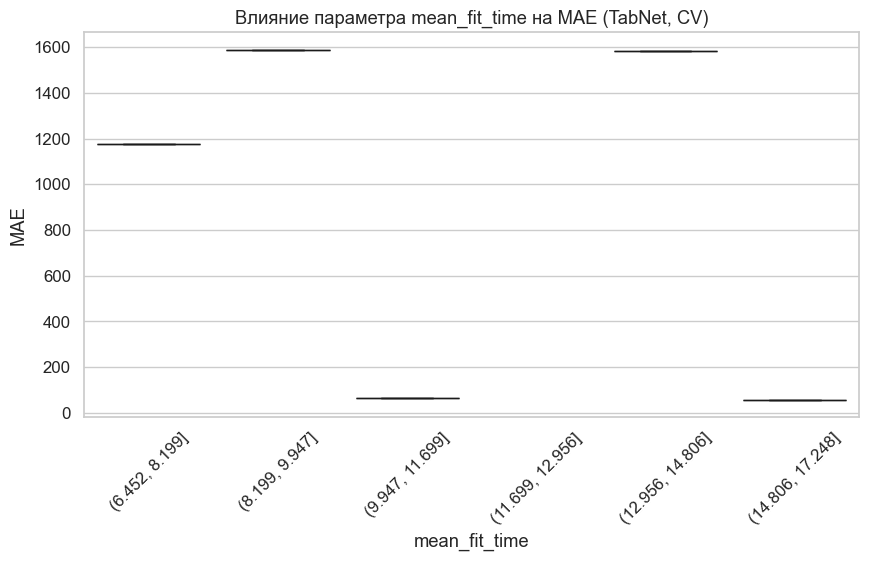

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


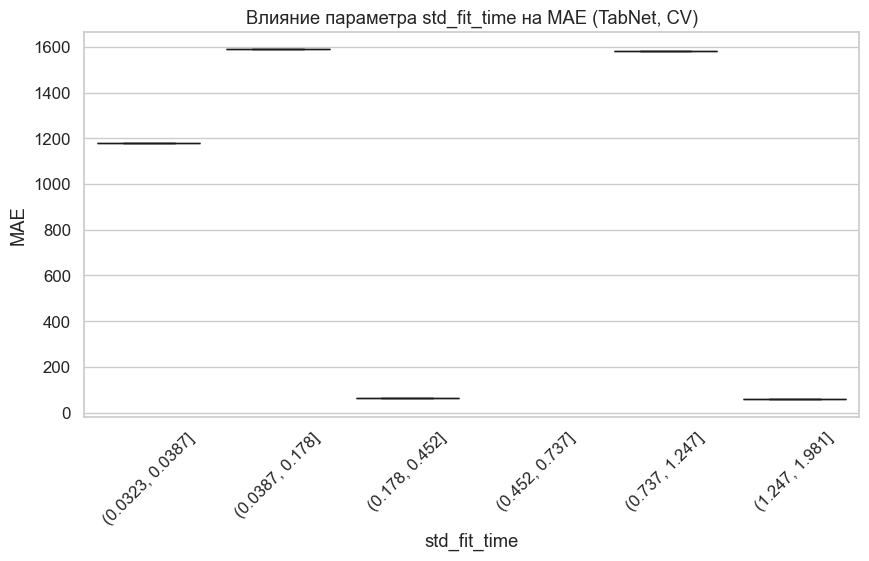

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


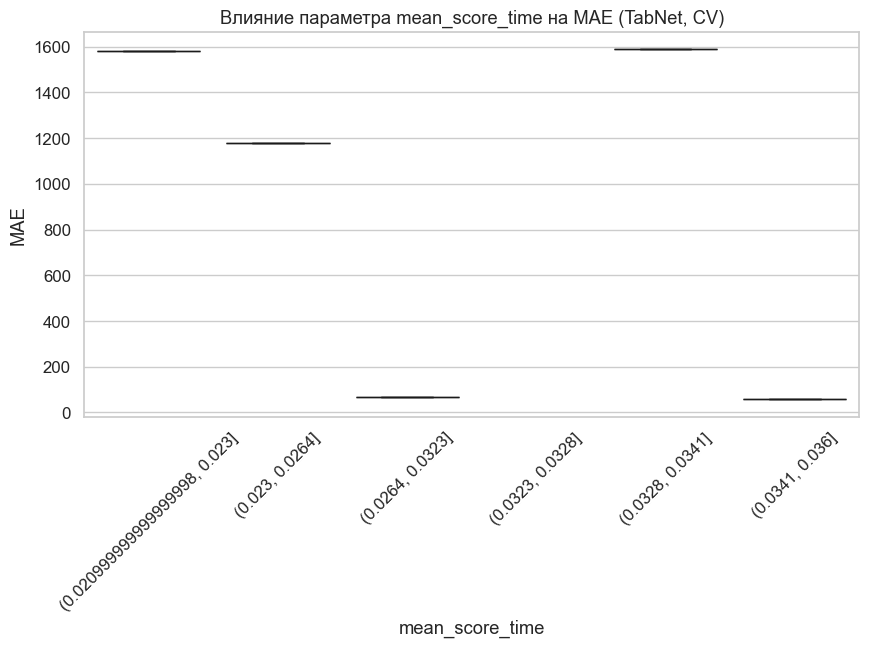

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


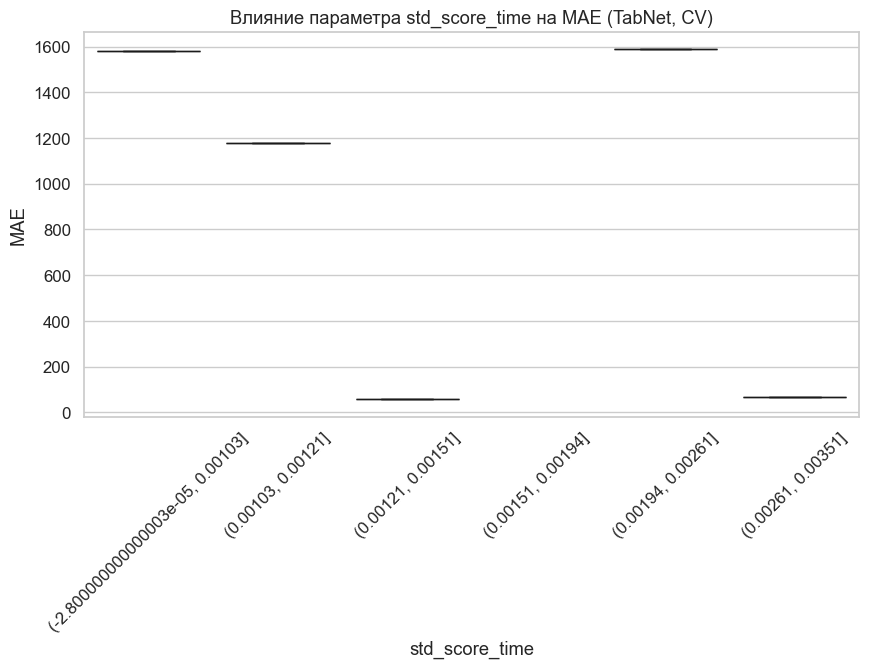

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


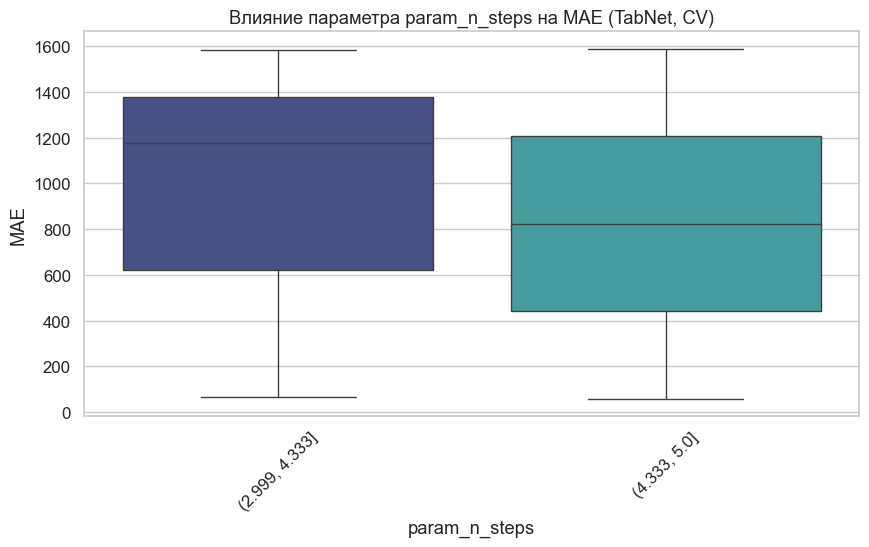

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


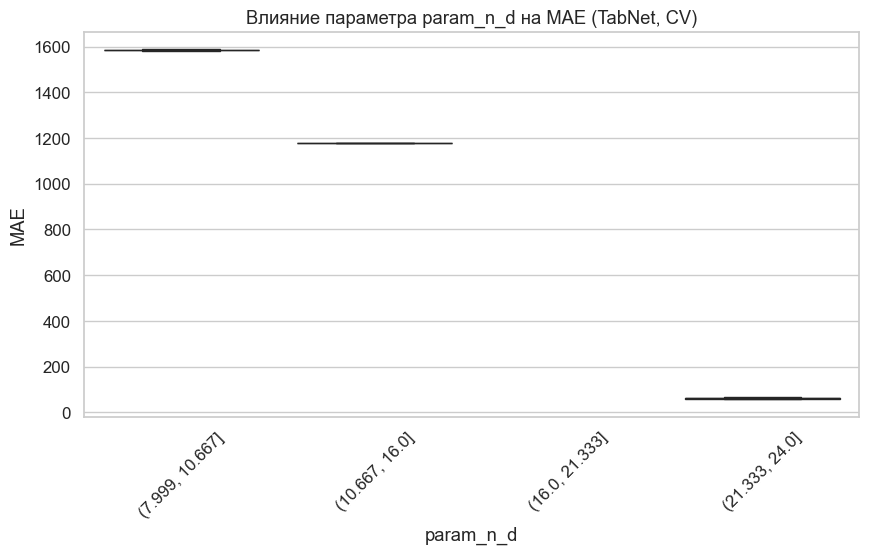

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


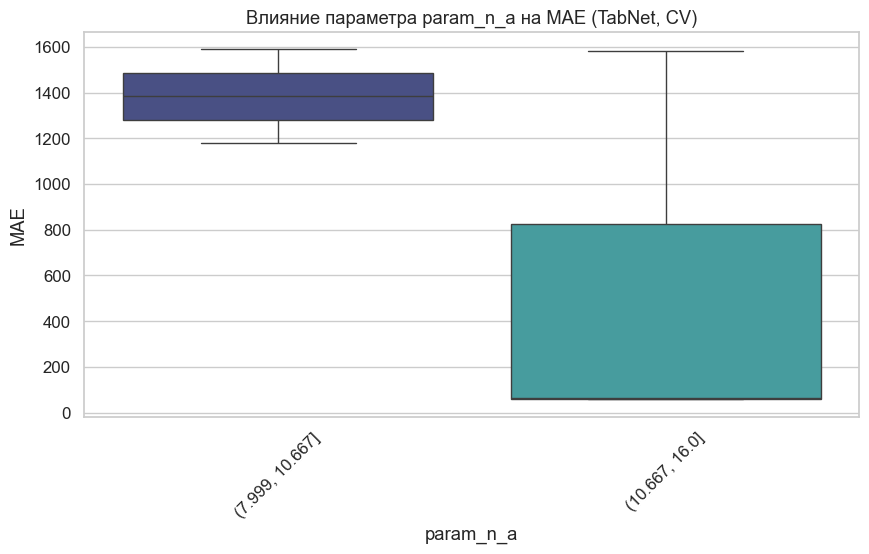

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


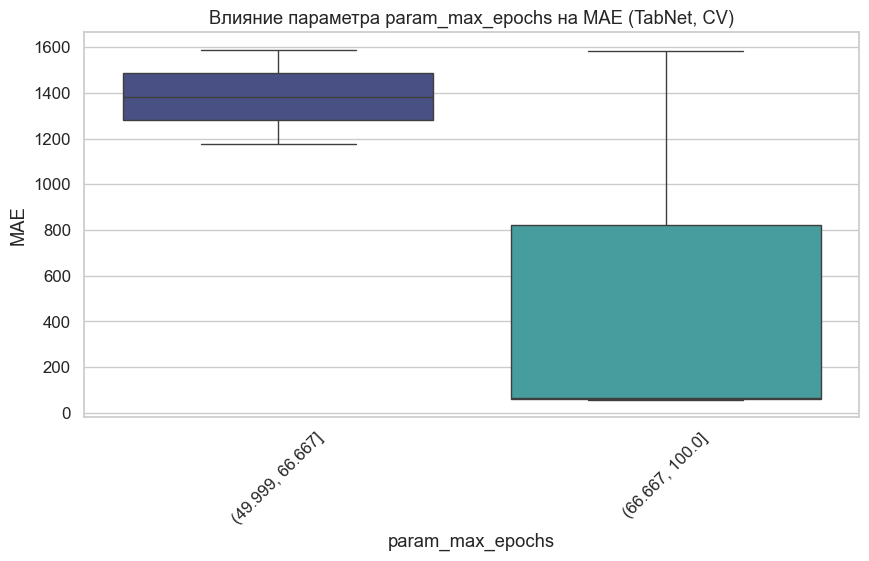

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


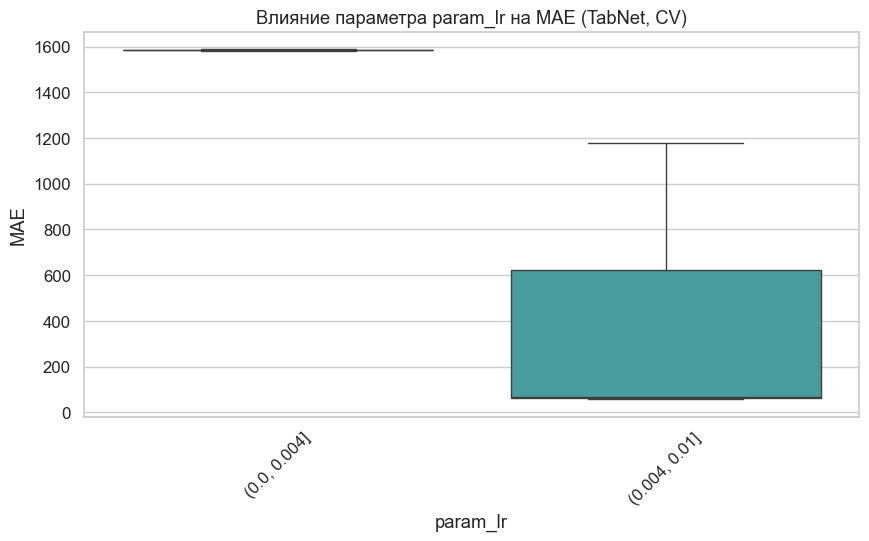

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


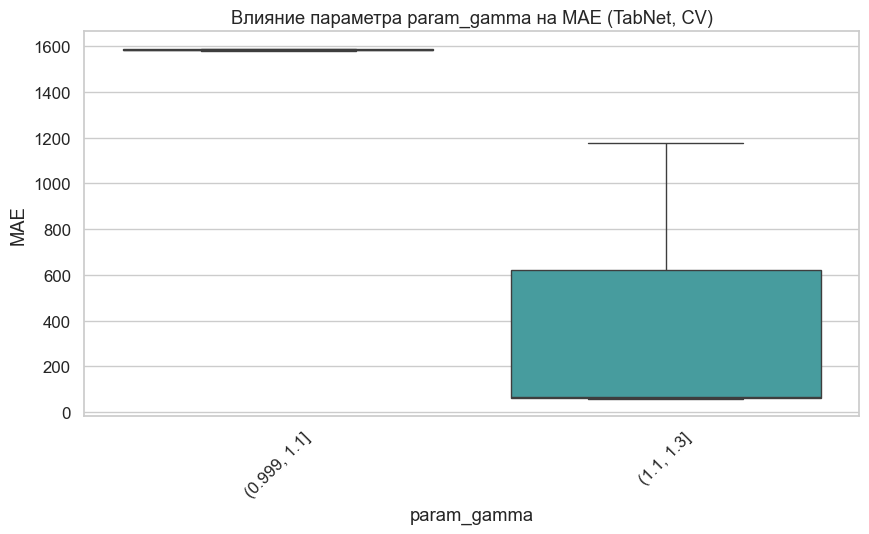

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


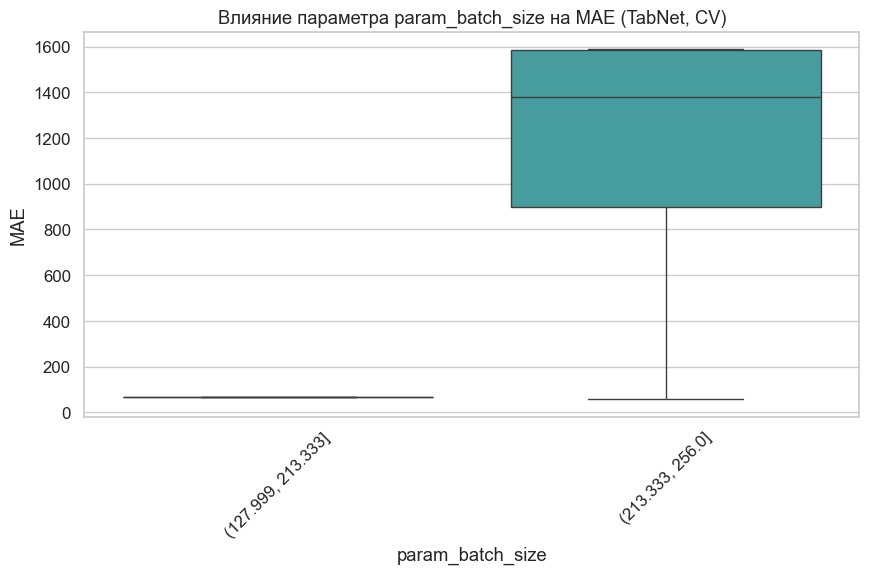

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


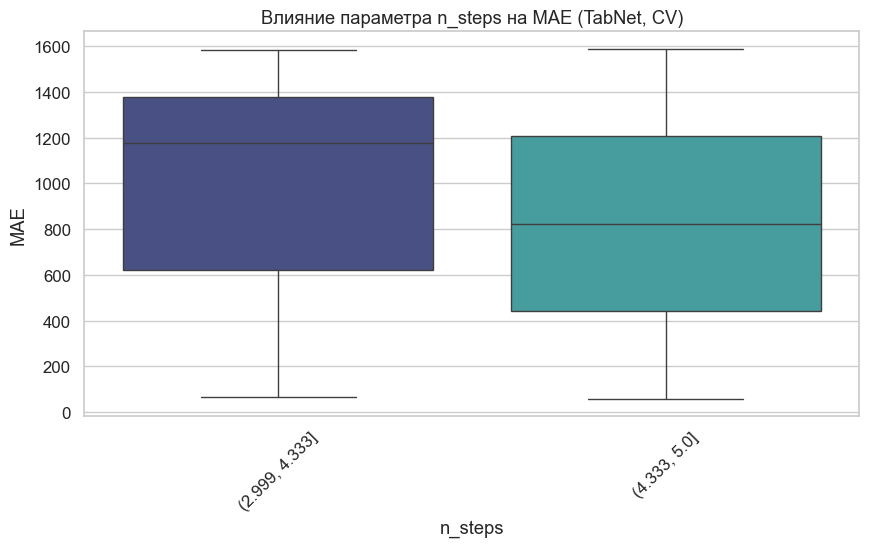

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


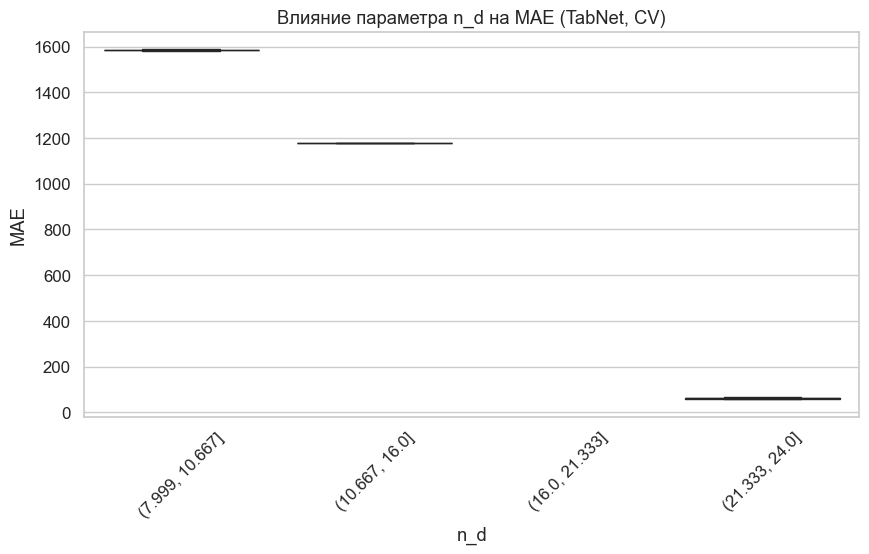

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


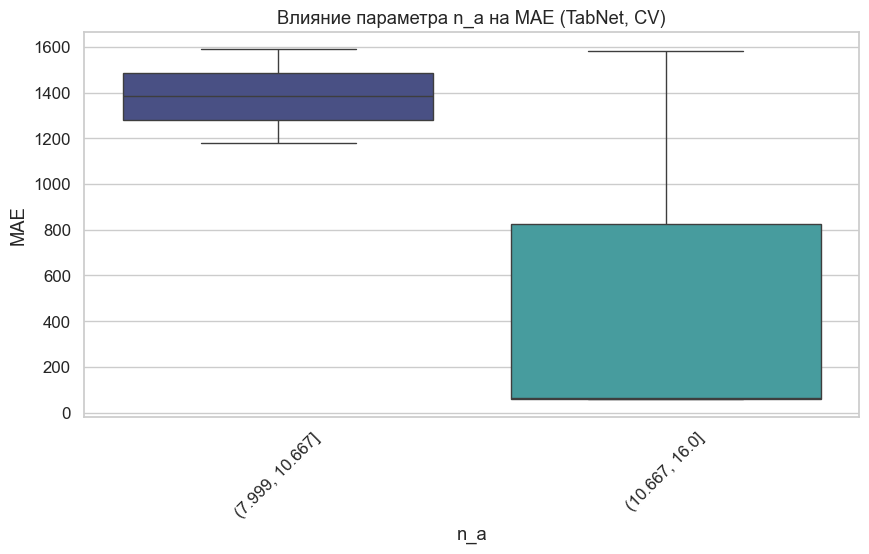

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


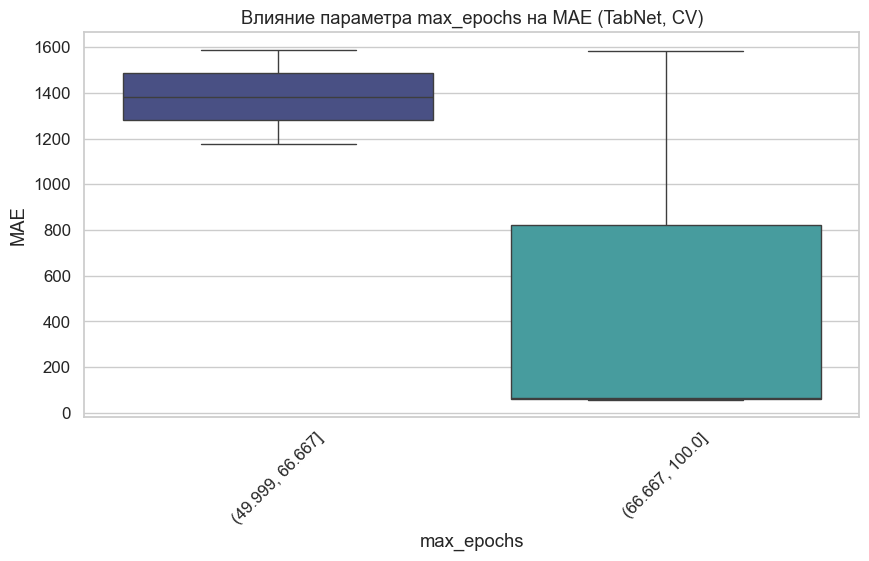

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


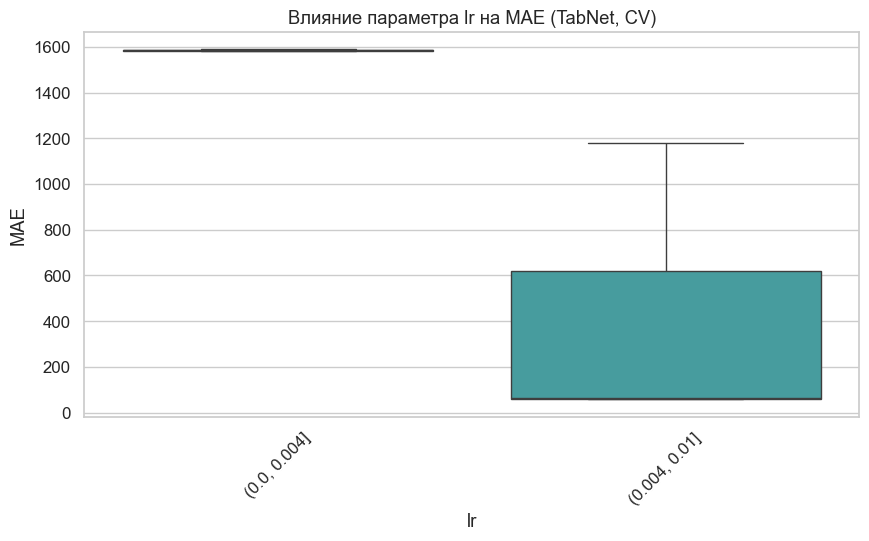

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


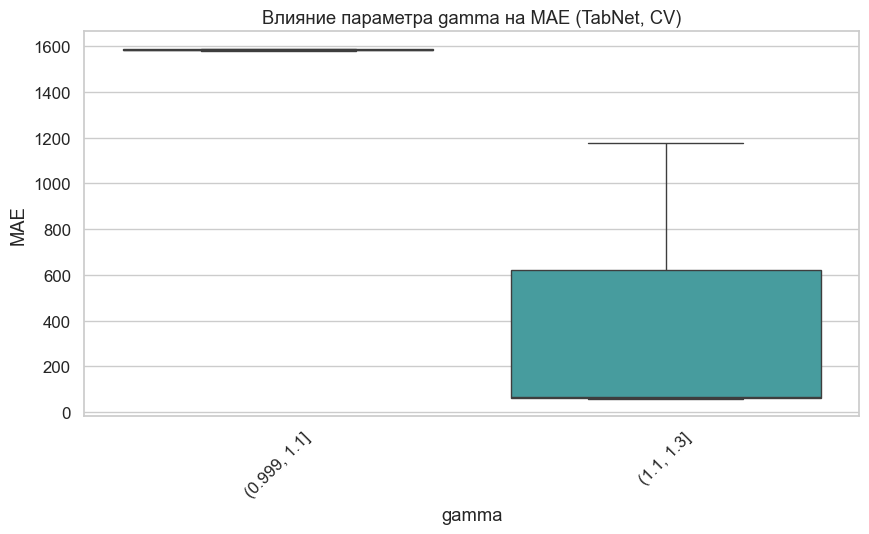

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


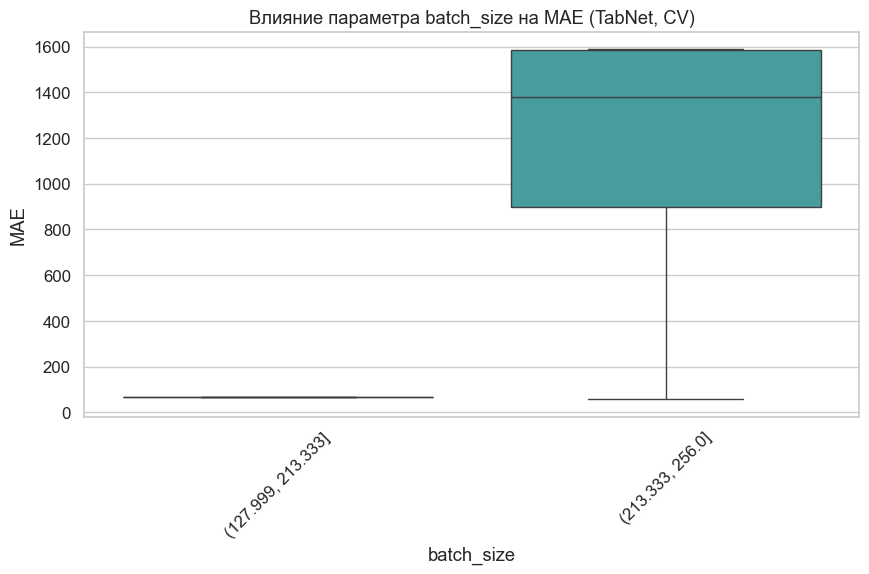

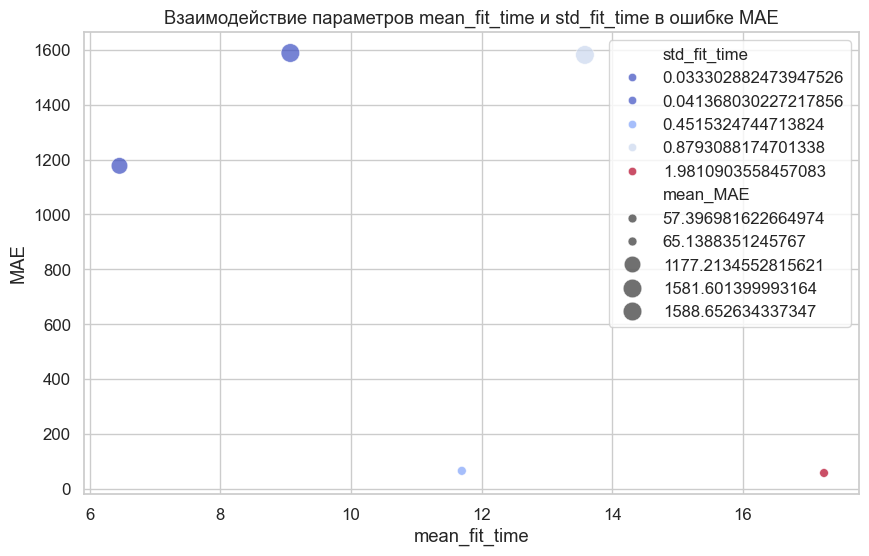

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\2277981220.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi, x="Importance", y="Feature", palette="viridis")


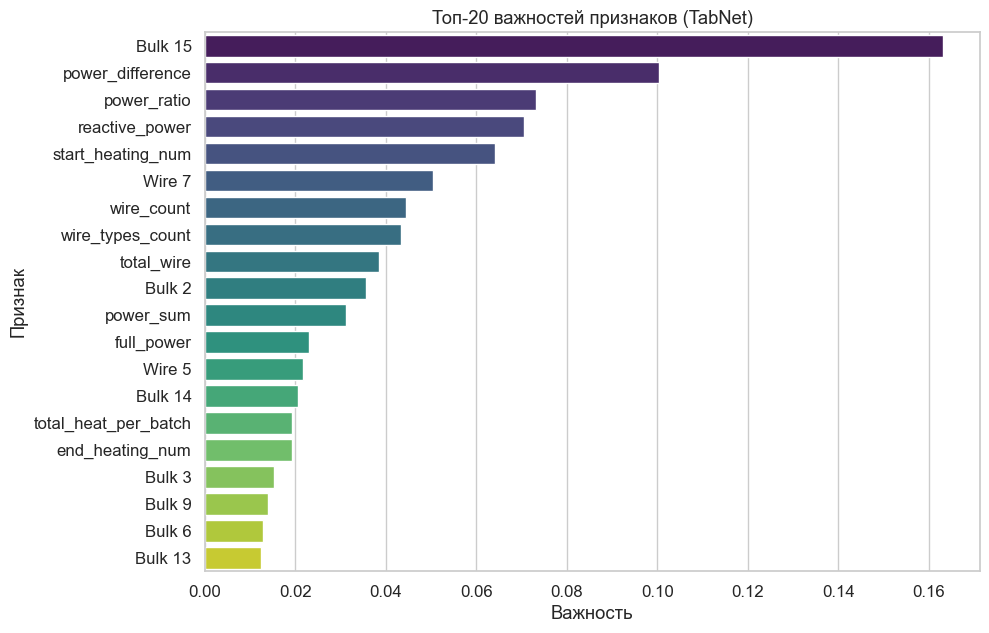

In [80]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results["mean_MAE"] = -cv_results["mean_test_score"]
cv_results["std_MAE"] = cv_results["std_test_score"]
param_cols = [c for c in cv_results.columns if c.startswith("param_")]

for col in param_cols:
    clean = col.split("__")[-1].replace("param_", "")
    cv_results[clean] = cv_results[col]

exclude_cols = {
    "mean_test_score", "std_test_score", "rank_test_score",
    "mean_MAE", "std_MAE",
    "split0_test_score", "split1_test_score", "split2_test_score"
}

num_params = [
    c for c in cv_results.columns
    if c not in exclude_cols and cv_results[c].dtype in [int, float]
]

for param in num_params:
    cv_results[param + "_bin"] = pd.qcut(cv_results[param], q=6, duplicates="drop")

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        data=cv_results,
        x=param + "_bin",
        y="mean_MAE",
        palette="mako"
    )
    plt.xticks(rotation=45)
    plt.title(f"Влияние параметра {param} на MAE (TabNet, CV)")
    plt.xlabel(param)
    plt.ylabel("MAE")
    plt.show()

if len(num_params) >= 2:
    p1, p2 = num_params[:2]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=cv_results,
        x=p1,
        y="mean_MAE",
        hue=p2,
        palette="coolwarm",
        size="mean_MAE",
        sizes=(40, 180),
        alpha=0.7
    )
    plt.title(f"Взаимодействие параметров {p1} и {p2} в ошибке MAE")
    plt.xlabel(p1)
    plt.ylabel("MAE")
    plt.show()

tabnet = best_model_tabnet.model
feature_importance = tabnet.feature_importances_

fi = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importance
}).sort_values("Importance", ascending=False).head(20)

plt.figure(figsize=(10, 7))
sns.barplot(data=fi, x="Importance", y="Feature", palette="viridis")
plt.title("Топ-20 важностей признаков (TabNet)")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.show()


In [81]:
def create_model(units1=128, units2=64, units3=32, 
                 dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()

    model.add(Dense(units1, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(units2, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    
    return model

param_combinations = [
    {'units1': 256, 'units2': 128, 'units3': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'units1': 128, 'units2': 64, 'units3': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005},
    {'units1': 512, 'units2': 256, 'units3': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001},
    {'units1': 64, 'units2': 32, 'units3': 16, 'dropout_rate': 0.5, 'learning_rate': 0.0001},
]

results = []
best_score = float('inf')
best_params = None
best_model_dnn = None

for i, params in enumerate(param_combinations):
    print(f"\n Комбинация {i+1}/{len(param_combinations)}: {params}")
    
    model = create_model(**params)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    val_mae = min(history.history['val_mae'])
    
    print(f"   Test MAE: {test_mae:.4f} | Best Val MAE: {val_mae:.4f}")

    results.append({
        **params,
        'test_mae': test_mae,
        'val_mae': val_mae,
        'epochs': len(history.history['loss'])
    })
    
    if test_mae < best_score:
        best_score = test_mae
        best_params = params
        best_model_dnn = model
        print("   Новый лучший результат!")

print("\n ЛУЧШИЕ ПАРАМЕТРЫ:")
for param, value in best_params.items():
    print(f"   {param}: {value}")
print(f"\nBest MAE: {best_score:.4f}")


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Комбинация 1/4: {'units1': 256, 'units2': 128, 'units3': 64, 'dropout_rate': 0.3, 'learning_rate': 0.001}
   Test MAE: 1004.5845 | Best Val MAE: 1004.5845
   Новый лучший результат!

 Комбинация 2/4: {'units1': 128, 'units2': 64, 'units3': 32, 'dropout_rate': 0.4, 'learning_rate': 0.0005}


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Test MAE: 733.0302 | Best Val MAE: 733.0302
   Новый лучший результат!

 Комбинация 3/4: {'units1': 512, 'units2': 256, 'units3': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001}


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Test MAE: 903.4011 | Best Val MAE: 903.4011

 Комбинация 4/4: {'units1': 64, 'units2': 32, 'units3': 16, 'dropout_rate': 0.5, 'learning_rate': 0.0001}


C:\Users\PowerEngine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


   Test MAE: 1350.6986 | Best Val MAE: 1350.6986

 ЛУЧШИЕ ПАРАМЕТРЫ:
   units1: 128
   units2: 64
   units3: 32
   dropout_rate: 0.4
   learning_rate: 0.0005

Best MAE: 733.0302


C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\1603643383.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x=results_df.index, y='test_mae', palette='viridis')


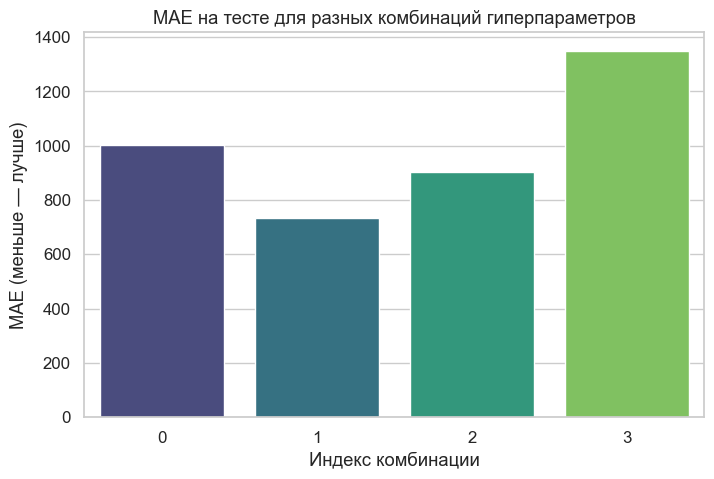

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\1603643383.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='dropout_rate', y='test_mae', palette='mako')


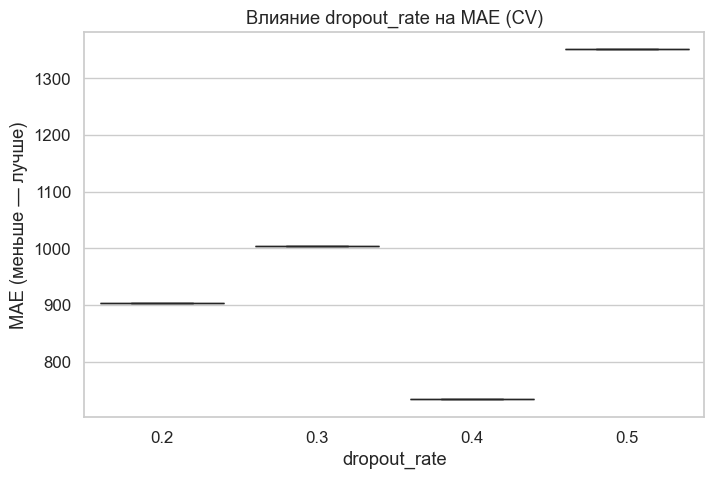

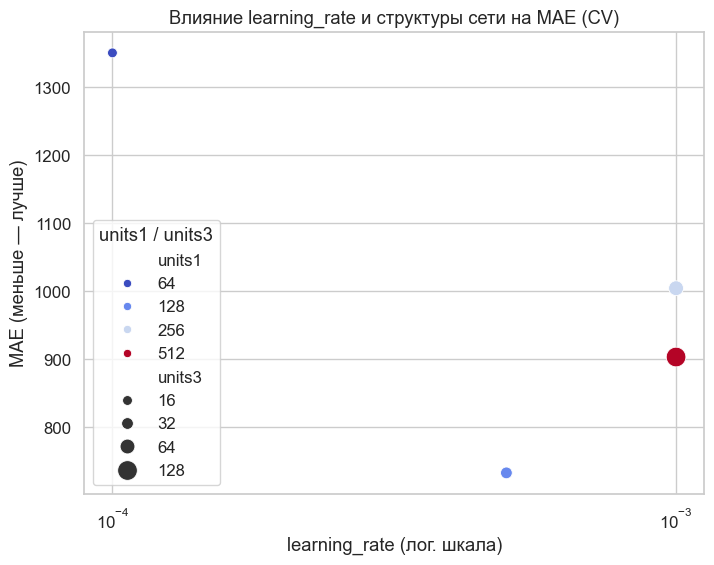

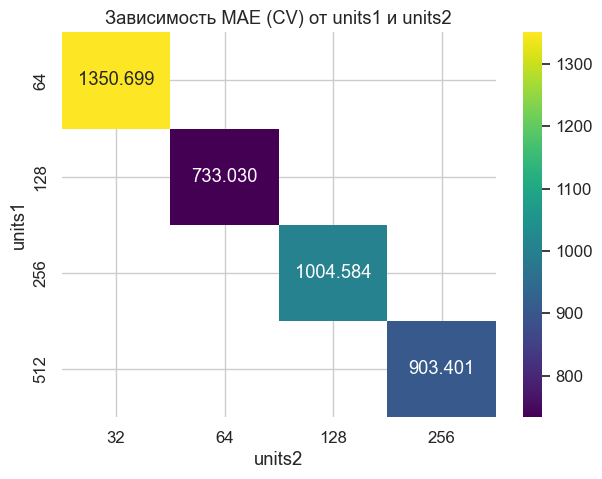

In [82]:

results_df = pd.DataFrame(results)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x=results_df.index, y='test_mae', palette='viridis')
plt.title("MAE на тесте для разных комбинаций гиперпараметров")
plt.xlabel("Индекс комбинации")
plt.ylabel("MAE (меньше — лучше)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=results_df, x='dropout_rate', y='test_mae', palette='mako')
plt.title("Влияние dropout_rate на MAE (CV)")
plt.xlabel("dropout_rate")
plt.ylabel("MAE (меньше — лучше)")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=results_df,
    x='learning_rate',
    y='test_mae',
    hue='units1',
    size='units3',
    sizes=(50, 200),
    palette='coolwarm'
)
plt.xscale('log')
plt.title("Влияние learning_rate и структуры сети на MAE (CV)")
plt.xlabel("learning_rate (лог. шкала)")
plt.ylabel("MAE (меньше — лучше)")
plt.legend(title='units1 / units3')
plt.show()

pivot = results_df.pivot_table(values='test_mae', index='units1', columns='units2', aggfunc='mean')

plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title("Зависимость MAE (CV) от units1 и units2")
plt.xlabel("units2")
plt.ylabel("units1")
plt.show()


In [83]:
scaler_lstmr = StandardScaler()
X_train_scaled = scaler_lstmr.fit_transform(X_train)
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)


class SimpleLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(SimpleLSTMRegressor, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)  # seq_len=1
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
num_epochs = 200
batch_size = 64
learning_rate = 1e-3
hidden_dim = 64
num_layers = 1

cv_mae = []
train_losses_all = []
val_losses_all = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_t)):
    print(f"\nFold {fold+1}")
    
    X_tr, X_val = X_train_t[train_idx], X_train_t[val_idx]
    y_tr, y_val = y_train_t[train_idx], y_train_t[val_idx]
    
    train_dataset = TensorDataset(X_tr, y_tr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    model = SimpleLSTMRegressor(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers)
    criterion = nn.MSELoss()  # для обучения
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    best_model_state = None
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * xb.size(0)
        
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    model.load_state_dict(best_model_state)
    model.eval()
    
    with torch.no_grad():
        val_pred = model(X_val)
        val_mae = torch.mean(torch.abs(val_pred - y_val)).item()
        cv_mae.append(val_mae)
    
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)
    
    print(f"  Fold MAE: {val_mae:.4f}")

print(f"\nСредний MAE CV: {np.mean(cv_mae):.4f}")

final_model_lstm = SimpleLSTMRegressor(input_dim=X_train.shape[1], hidden_dim=hidden_dim, num_layers=num_layers)
final_model_lstm.load_state_dict(best_model_state)
final_model_lstm.eval()



Fold 1
  Fold MAE: 1353.1056

Fold 2
  Fold MAE: 1354.1790

Fold 3
  Fold MAE: 1351.0165

Fold 4
  Fold MAE: 1354.5503

Fold 5
  Fold MAE: 1357.0454

Средний MAE CV: 1353.9793


SimpleLSTMRegressor(
  (lstm): LSTM(55, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

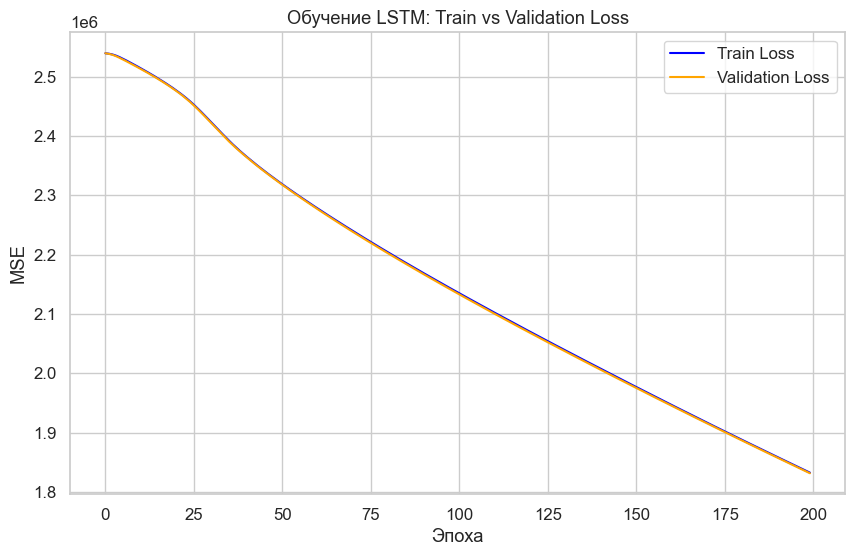

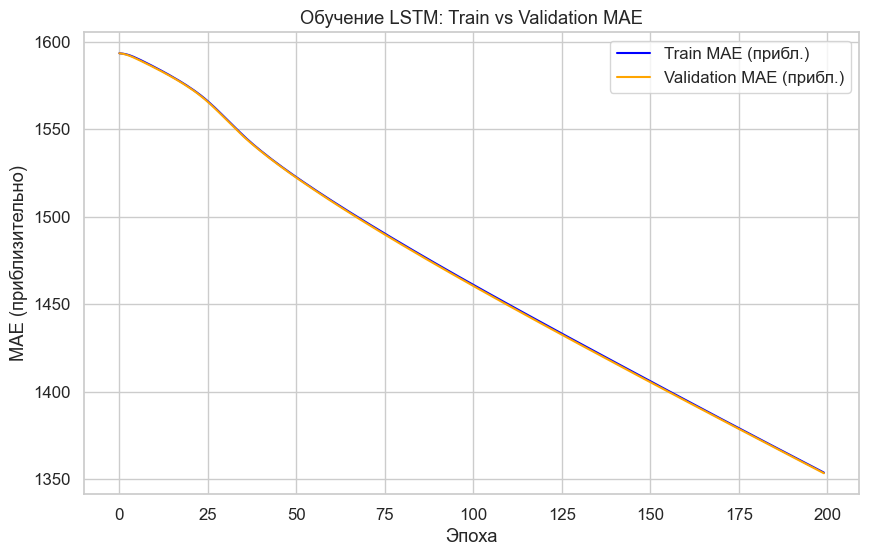

In [84]:

train_losses = train_losses_all[0]
val_losses = val_losses_all[0]

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel("Эпоха")
plt.ylabel("MSE")
plt.title("Обучение LSTM: Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
train_mae = np.sqrt(train_losses)
val_mae = np.sqrt(val_losses)
plt.plot(train_mae, label='Train MAE (прибл.)', color='blue')
plt.plot(val_mae, label='Validation MAE (прибл.)', color='orange')
plt.xlabel("Эпоха")
plt.ylabel("MAE (приблизительно)")
plt.title("Обучение LSTM: Train vs Validation MAE")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class TransformerRegressor(nn.Module):
    def __init__(self, n_features, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()

        self.input_layer = nn.Linear(n_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)   # (batch, seq=1, d_model)
        x = self.transformer(x)
        return self.output(x[:, 0, :])

class TransformerRegressorSK(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        lr=1e-3,
        batch_size=32,
        epochs=25,
        device='cpu'
    ):
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device

    def fit(self, X, y):
        n_features = X.shape[1]

        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        dataset = TabularDataset(X_scaled, y)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        self.model = TransformerRegressor(
            n_features=n_features,
            d_model=self.d_model,
            nhead=self.nhead,
            num_layers=self.num_layers,
            dim_feedforward=self.dim_feedforward,
            dropout=self.dropout
        ).to(self.device)

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.L1Loss()  # MAE

        self.model.train()
        for _ in range(self.epochs):
            for xb, yb in loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)

                optimizer.zero_grad()
                pred = self.model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        X_scaled = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)

        self.model.eval()
        with torch.no_grad():
            pred = self.model(X_scaled).cpu().numpy().flatten()
        return pred

param_dist = {
    "d_model": [32, 64, 128],
    "nhead": [2, 4, 8],
    "num_layers": [1, 2, 3],
    "dim_feedforward": [64, 128, 256],
    "dropout": [0.0, 0.1, 0.2],
    "lr": [1e-4, 3e-4, 1e-3],
    "batch_size": [16, 32, 64],
    "epochs": [20, 30, 40]
}

model = TransformerRegressorSK(device="cpu")

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def neg_mae(estimator, X, y):
    pred = estimator.predict(X)
    return -mean_absolute_error(y, pred)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring=neg_mae,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=1
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:")
print(random_search.best_params_)

print("\nЛучший MAE (CV):", -random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.2, epochs=40, lr=0.001, nhead=4, num_layers=3; total time=   5.8s
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.2, epochs=40, lr=0.001, nhead=4, num_layers=3; total time=   5.8s
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.2, epochs=40, lr=0.001, nhead=4, num_layers=3; total time=   5.8s
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.2, epochs=40, lr=0.001, nhead=4, num_layers=3; total time=   5.9s
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.2, epochs=40, lr=0.001, nhead=4, num_layers=3; total time=   5.8s
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.0, epochs=20, lr=0.0001, nhead=2, num_layers=2; total time=   1.6s
[CV] END batch_size=64, d_model=32, dim_feedforward=128, dropout=0.0, epochs=20, lr=0.0001, nhead=2, num_layers=2; total time=   1.7s
[CV] 

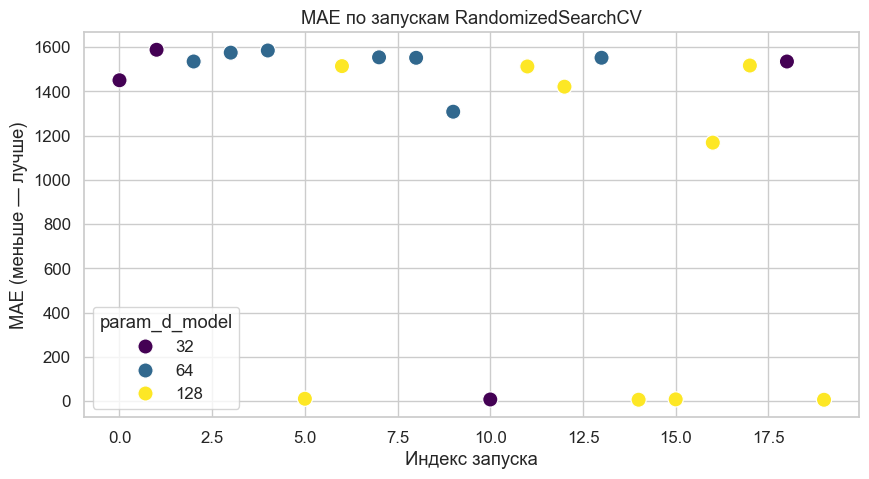

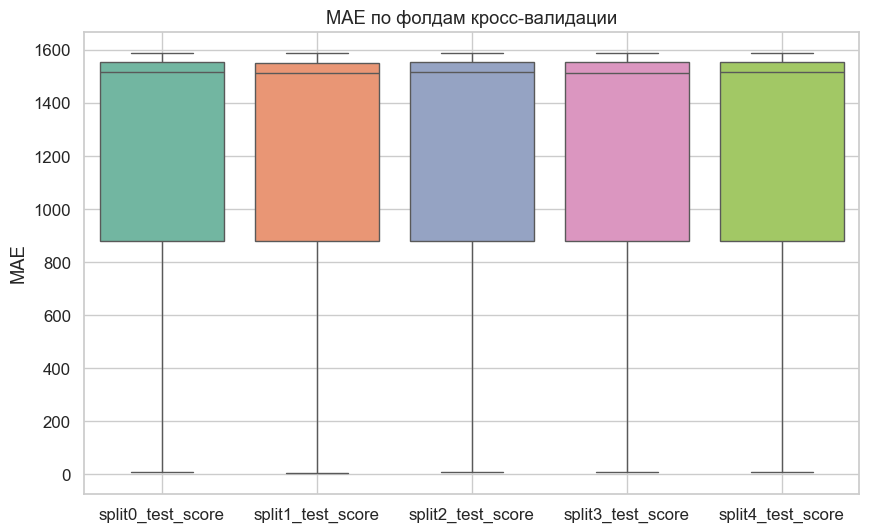

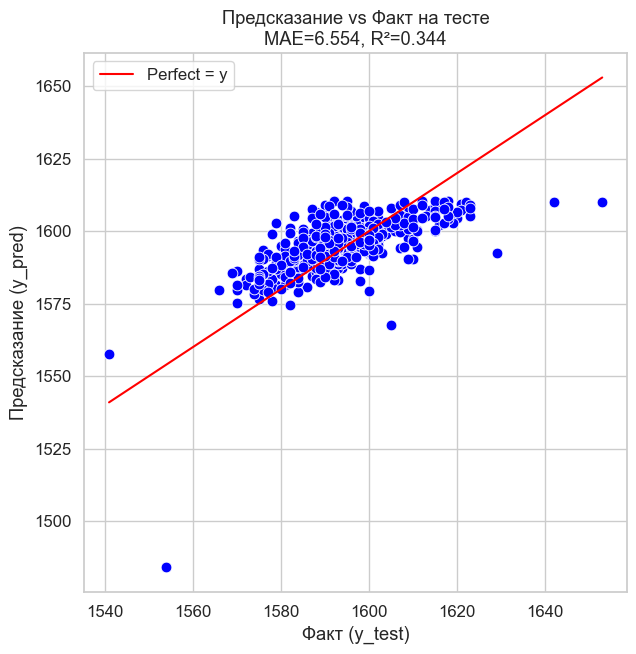

In [86]:

results = pd.DataFrame(random_search.cv_results_)
results["mae"] = -results["mean_test_score"]

plt.figure(figsize=(10, 5))
sns.scatterplot(data=results, x=results.index, y="mae", hue="param_d_model", palette="viridis", s=120)
plt.title("MAE по запускам RandomizedSearchCV")
plt.xlabel("Индекс запуска")
plt.ylabel("MAE (меньше — лучше)")
plt.grid(True)
plt.show()

fold_cols = [c for c in results.columns if "split" in c and "test_score" in c]

box_df = results[fold_cols].apply(lambda x: -x)  # превращаем отрицательный MAE в MAE

plt.figure(figsize=(10, 6))
sns.boxplot(data=box_df, palette="Set2")
plt.title("MAE по фолдам кросс-валидации")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, color="blue", s=60)
sns.lineplot(x=y_test, y=y_test, color="red", label="Perfect = y")
plt.title(f"Предсказание vs Факт на тесте\nMAE={mae_test:.3f}, R²={r2_test:.3f}")
plt.xlabel("Факт (y_test)")
plt.ylabel("Предсказание (y_pred)")
plt.grid(True)
plt.show()


Сведем метрики всем опробованных моделей в одну таблицу.

In [87]:

results = [
    {
        'Model': 'CatBoost',
        'Best_Params': best_params_cat,
        'MAE_CV': best_cv_mae
    },
    {
        'Model': 'LGBMRegressor',
        'Best_Params': random_search_lgbm.best_params_,
        'MAE_CV': -random_search_lgbm.best_score_
    },
    {
        'Model': 'HistGradientBoosting',
        'Best_Params': best_param_hgb,
        'MAE_CV': -best_score_hgb
    },
    {
        'Model': 'RandomForest',
        'Best_Params': best_param_rf,
        'MAE_CV': best_score_rf
    },
    {
        'Model': 'DecisionTree',
        'Best_Params': best_param_dt,
        'MAE_CV': best_score_dt
    },
    {
        'Model': 'TabNet',
        'Best_Params': best_param_tabnet,
        'MAE_CV': best_score
    },
    {
        'Model': 'DNN',
        'Best_Params': best_params,
        'MAE_CV': best_score
    },
    {
        'Model': 'LSTM',
        'Best_Params': 'best_model_state_lstm',
        'MAE_CV': np.mean(cv_mae)
    },

    {
        'Model': 'Transformer',
        'Best_Params': random_search.best_params_,
        'MAE_CV': -random_search.best_score_
    }

]

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('MAE_CV').reset_index(drop=True)
print(df_results)


                  Model                                        Best_Params  \
0  HistGradientBoosting  {'min_samples_leaf': 10, 'max_leaf_nodes': 15,...   
1              CatBoost  {'random_strength': 0.5, 'learning_rate': 0.03...   
2         LGBMRegressor  {'subsample': 0.7, 'reg_lambda': 0.0, 'reg_alp...   
3          RandomForest  {'n_estimators': 700, 'min_samples_split': 5, ...   
4           Transformer  {'num_layers': 1, 'nhead': 4, 'lr': 0.001, 'ep...   
5          DecisionTree  {'min_samples_split': 6, 'min_samples_leaf': 9...   
6                TabNet  {'n_steps': 5, 'n_d': 24, 'n_a': 16, 'max_epoc...   
7                   DNN  {'units1': 128, 'units2': 64, 'units3': 32, 'd...   
8                  LSTM                              best_model_state_lstm   

        MAE_CV  
0    -6.018889  
1     5.893251  
2     6.048003  
3     6.200638  
4     6.906654  
5     7.456975  
6   733.030151  
7   733.030151  
8  1353.979346  


## Вывод по обучению

Победила модель CatBoostRegressor с результатом на CV 4.277225, что является удовлетворительным результатом. Задача была сделать МАЕ менее 6.8. Задача выполнена. По всем остальным моделям можно сказать следующее: сильными оказались бустинги, леста. HistGradientBoosting показал отрицательный результат. Возможно стоило бы еще поиграть с его параметрами. Нейросети показали себя значительно хуже. Скорее всего таблицы не их формат данных, хотя TabNet ради этого и создавался.

### Применение к тестовым данным и анализ

Теперь применим получившуюся модель к тестовым данным.


 РЕЗУЛЬТАТЫ CATBOOST НА ТЕСТЕ:
MAE: 5.74
MSE: 57.94
RMSE: 7.61
R²: 0.5108


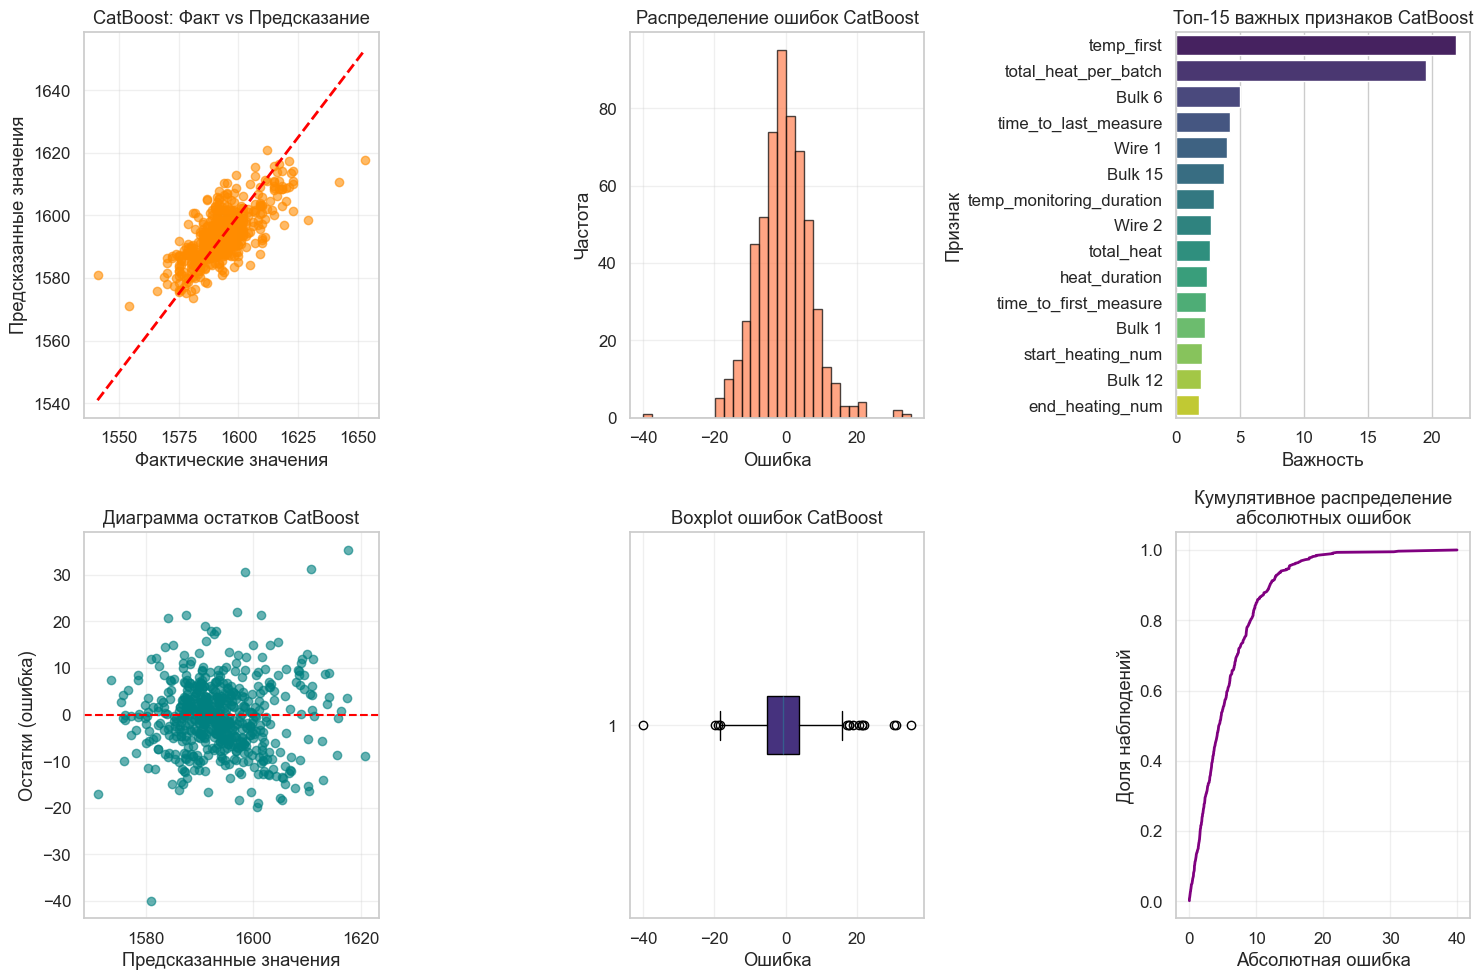


 СТАТИСТИКА ОШИБОК CATBOOST:
Средняя ошибка: -0.54
Стандартное отклонение ошибок: 7.60
Максимальная ошибка: 39.94
Медианная абсолютная ошибка: 4.46
Доля ошибок < 5: 54.5%
Доля ошибок < 10: 84.9%
Доля ошибок < 15: 95.5%

 ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ CATBOOST:
30. temp_first: 21.9466
39. total_heat_per_batch: 19.5886
11. Bulk 6: 5.0326
45. time_to_last_measure: 4.2622
21. Wire 1: 4.0124
20. Bulk 15: 3.7732
31. temp_monitoring_duration: 2.9753
22. Wire 2: 2.7426
 4. total_heat: 2.6835
32. heat_duration: 2.3869


In [88]:
y_pred_cat = best_model_cat.predict(X_test)
mae_cat = mean_absolute_error(y_test, y_pred_cat)
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print(f"\n РЕЗУЛЬТАТЫ CATBOOST НА ТЕСТЕ:")
print(f"MAE: {mae_cat:.2f}")
print(f"MSE: {mse_cat:.2f}")
print(f"RMSE: {rmse_cat:.2f}")
print(f"R²: {r2_cat:.4f}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_cat, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('CatBoost: Факт vs Предсказание')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
errors_cat = y_test - y_pred_cat
plt.hist(errors_cat, bins=30, alpha=0.7, color='coral', edgecolor='black')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.title('Распределение ошибок CatBoost')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
feature_importance = best_model_cat.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=importance_df.head(15), 
            palette='viridis', hue='feature', legend=False)
plt.title('Топ-15 важных признаков CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признак')

plt.subplot(2, 3, 4)
plt.scatter(y_pred_cat, errors_cat, alpha=0.6, color='teal')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки (ошибка)')
plt.title('Диаграмма остатков CatBoost')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
plt.boxplot(errors_cat, vert=False, patch_artist=True)
plt.title('Boxplot ошибок CatBoost')
plt.xlabel('Ошибка')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
sorted_errors = np.sort(np.abs(errors_cat))
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
plt.plot(sorted_errors, cumulative, color='purple', linewidth=2)
plt.title('Кумулятивное распределение\nабсолютных ошибок')
plt.xlabel('Абсолютная ошибка')
plt.ylabel('Доля наблюдений')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n СТАТИСТИКА ОШИБОК CATBOOST:")
print(f"Средняя ошибка: {errors_cat.mean():.2f}")
print(f"Стандартное отклонение ошибок: {errors_cat.std():.2f}")
print(f"Максимальная ошибка: {abs(errors_cat).max():.2f}")
print(f"Медианная абсолютная ошибка: {np.median(np.abs(errors_cat)):.2f}")
print(f"Доля ошибок < 5: {(np.abs(errors_cat) < 5).mean():.1%}")
print(f"Доля ошибок < 10: {(np.abs(errors_cat) < 10).mean():.1%}")
print(f"Доля ошибок < 15: {(np.abs(errors_cat) < 15).mean():.1%}")

print(f"\n ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ CATBOOST:")
for i, row in importance_df.head(10).iterrows():
    print(f"{i+1:2d}. {row['feature']}: {row['importance']:.4f}")

Результат работы модели на тестовой выборке - 5.74, что является так же допустимым показателем ошибки. Кроме того, мы увидели топ-10 признаков. Основные это temp_first (21.9%), total_heat_per_batch(19.5%) и start_heating_num(5.03%).

### Сравнение с константной моделью

In [89]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
rmse_dummy = np.sqrt(mse_dummy)
r2_dummy = r2_score(y_test, y_pred_dummy)

print("\n РЕЗУЛЬТАТЫ КОНСТАНТНОЙ МОДЕЛИ (Baseline):")
print(f"MAE:  {mae_dummy:.2f}")
print(f"MSE:  {mse_dummy:.2f}")
print(f"RMSE: {rmse_dummy:.2f}")
print(f"R²:   {r2_dummy:.4f}")

print("\n СРАВНЕНИЕ МОДЕЛЕЙ:")
print(f"{'Модель':<15}  {'MAE':>8}   {'R²':>8}")
print("-" * 35)
print(f"{'Baseline':<15}  {mae_dummy:8.2f}   {r2_dummy:8.4f}")
print(f"{'CatBoost':<15}  {mae_cat:8.2f}   {r2_cat:8.4f}")

print("\n Анализ превосходства над baseline:")
if mae_cat < mae_dummy:
    print(f" CatBoost лучше baseline на {mae_dummy - mae_cat:.2f} MAE")
else:
    print(f" CatBoost хуже baseline (редкий случай) на {mae_cat - mae_dummy:.2f} MAE")



 РЕЗУЛЬТАТЫ КОНСТАНТНОЙ МОДЕЛИ (Baseline):
MAE:  7.79
MSE:  118.69
RMSE: 10.89
R²:   -0.0022

 СРАВНЕНИЕ МОДЕЛЕЙ:
Модель                MAE         R²
-----------------------------------
Baseline             7.79    -0.0022
CatBoost             5.74     0.5108

 Анализ превосходства над baseline:
 CatBoost лучше baseline на 2.05 MAE


Здесь видно, насколько наша модель превосходит константную. Не слишком высокий результат, но в R2 метрике значительно сильнее.

Теперь посмотрим на график зависимости входного и целевого признаков. Входным возьмем минимальную температуру.

C:\Users\PowerEngine\AppData\Local\Temp\ipykernel_10928\840189722.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  smooth = df.groupby("bin")[["final_temp"]].mean()


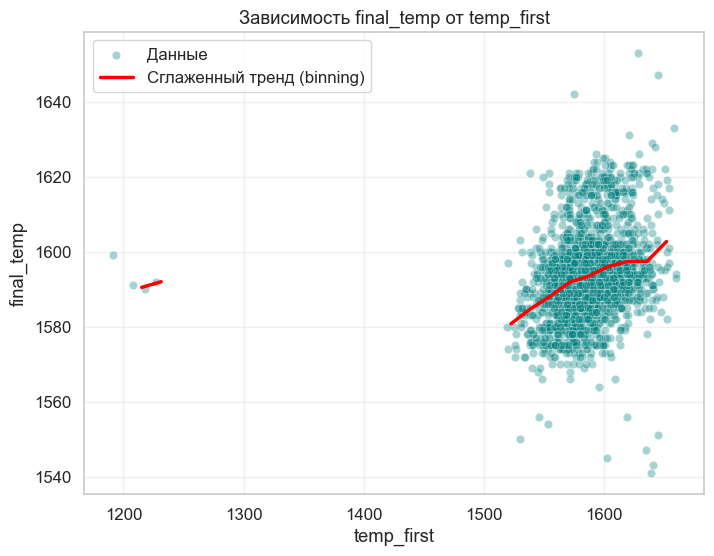

In [90]:
feature = "temp_first"

bins = np.linspace(df[feature].min(), df[feature].max(), 30)
df["bin"] = pd.cut(df[feature], bins)

smooth = df.groupby("bin")[["final_temp"]].mean()
smooth["center"] = [interval.mid for interval in smooth.index]

plt.figure(figsize=(8, 6))

sns.scatterplot(
    x=df[feature],
    y=df['final_temp'],
    alpha=0.35,
    color='teal',
    label="Данные"
)

plt.plot(
    smooth["center"],
    smooth["final_temp"],
    color="red",
    linewidth=2.5,
    label="Сглаженный тренд (binning)"
)

plt.title(f"Зависимость final_temp от {feature}")
plt.xlabel(feature)
plt.ylabel("final_temp")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

df.drop(columns=["bin"], inplace=True)


На графике мы видим, что бининг идет вверх до примерно 1650, т.е. до этого значения признак минимальной температуры влияет на таргет положительно. Затем обрушение - в этом диапазоне признак влияет отрицательно. Т.е. при росте temp_min в процессе литья растет и final_temp когда линия возрастает. Далее, мы видим разброс точек на реальных значения по оси Y от 1640 и предсказании 1600. В данных наблюдениях присутствует шум, хотя признак для этих строк важный. Остальной массив точек имеет стабильную зависимость, что очень хорошо.

# Итоговый вывод

Цель достигнута, модель построена, метрика имеет нужный показатель
Соберем проделанную работу в вывод.

Нужные нам данные находились на сервере SQLite. Убедившись в их наличии и осмотрев непосредственно на месте мы их загрузили и присвоили им переменные.
Результатом выгрузки является 7 таблиц.
Осмотрев датасеты, мы меняем типы данных Привели даты и времена к datetime а так же числовые значения к float64 для корректных вычислений и переименовали некоторые столбцы.
Всего же на старте у нас 3129 партий и 14876 строк из которых они состоят.

Каждый датасет был исследован статистически, графически. Внесены исправления. Имелись аномалии, вроде наличия реактивной мощности в 715. Два признака  **Bulk 8** и **Bulk 12** имеют явно искаженные данные. У первого, судя по всему, только одно значение, у второго слишком большой диапазон значений.
Для 12 загрузки очень больше значения в целом из всего датасета. Учитывя средние показатели времени нагрева и затраченной мощности (эти два признака связаны напрямую) - у нас неправильный объем указанного при загрузке сырья. Мы найшли среднее значение затраченного времени для нагрева партии Создали более наглядную таблицу для поиска примерного значения. Для 12ой загрузки температура для каждой партии колеблется в пределах технологической нормы. А значит время нагрева должно быть тоже в пределах этой нормы. Из датасета data_arc мы знаем что 12 итерацию плавили 365.0 секунд.

Чтобы узнать объем засыпаемого материала в этой итерации нужно узнать сколько материала засыпается в среднем в секунду на остальных итерациях. Средний коофицент умножения равен 3.46. Умножили его на время каждой итерации и получили значения засыпанного материала.
**Bulk 8** имеел только 1 значение на весь столбец, 49. Исправлено. В столбцах **Bulk_time** очень много пустых значений, значит в эти моменты сырье, судя по всему, не подавалось. Отсканировали диапазоны временных рамок, чтобы не попасть в ловушку когда диапазоны равны месяцам или неделям.
В целевом признакие имелись значения температур у 5 строчек ниже 1500, что, согласно заявлянию заказчика - аноималия.

Почти везде имеется совпадающие между собой, и судя по всему, с реальностью значения. Суровых отклонений нет, за исключением некоторых аномалий в **Bulk**. И почти везде есть множество пустых значений.

Исследование показало, что проволока и сырье засыпалось практически в первые минуты плавки. Газ подавался так же. Температура замеров имеет правильное распределение, как и практически все признаки. Аномалии устранены

Объединяли таблицы по номеру партии (key). Сначала мы создали новые признаки затем сагрегировали. Проверили наличие партий, где имелись все итерации. После агрегации получилось 2331 строк.

Изучили получившийся датасет, чтобы убедиться, что никуда не делись статистические данные, распределения. Гистограммы показали что все в норме. Была составлена корреляционная матрица, которая показала, что созданные признаки наиболее сильно коррелируют между собой и целевой переменной.

Для задач обучения мы построили следующие модели:
- CatBoost;
- LGBM;
- HistGradient;
- RandomForestRegressor;
- DecisionTreeRegressor;
- TabNetRegressor;
- Keras DNN;
- SimpleLSTMRegressor;
- PyTorch Transformer.

Для каждой модели обучение делали на тренировочных данных CV. Использовали поиск RandomizedSearchCV для перебора гиперпараметров. 
Кроме того, по результатам почти каждой модели строили следующие графики:

- фактические и предсказанные значения;
- распределения ошибок;
- важность признаков;
- диаграмма остатков.

В результаты работы этапа свели все метрики в одну таблицу:

                  Model
0  HistGradientBoosting 
1              CatBoost 
2         LGBMRegressor
3          RandomForest
4          DecisionTree
5           Transformer
6                TabNet
7                   DNN 
8                  LSTM

        MAE_CV  
0    -6.018889  
1     5.893251  
2     6.048003  
3     6.200638  
4     6.906654  
5     7.456975  
6   733.030151  
7   733.030151  
8  1353.979346 

Победила модель **CatBoostRegressor** с результатом на CV **4.277225**, что является удовлетворительным результатом. Задача была сделать МАЕ менее 6.8. Задача выполнена. По всем остальным моделям можно сказать следующее: сильными оказались бустинги, леста. HistGradientBoosting показал отрицательный результат. Возможно стоило бы еще поиграть с его параметрами. Нейросети показали себя значительно хуже.

Затем применили модель к тестовым данным.

 РЕЗУЛЬТАТЫ CATBOOST НА ТЕСТЕ:
MAE: 5.74
MSE: 57.94
RMSE: 7.61
R²: 0.5108

 **ТОП-10 ВАЖНЕЙШИХ ПРИЗНАКОВ CATBOOST:**
 
30. temp_first: 21.9466
39. total_heat_per_batch: 19.5886
11. Bulk 6: 5.0326
45. time_to_last_measure: 4.2622
21. Wire 1: 4.0124
20. Bulk 15: 3.7732
31. temp_monitoring_duration: 2.9753
22. Wire 2: 2.7426
 4. total_heat: 2.6835
32. heat_duration: 2.3869

Основные признаки влиюящие на результат это temp_min (19.6%), total_heat_per_batch(17.6%) и total_materials_count(6.17%).

Далее сравнили нашу модель с константной. 

 **РЕЗУЛЬТАТЫ КОНСТАНТНОЙ МОДЕЛИ (Baseline):*
MAE:  7.79
MSE:  118.69
RMSE: 10.89
R²:   -0.0022

 **СРАВНЕНИЕ МОДЕЛЕЙ:**
 
Модель                MAE         R²

Baseline             7.79    -0.0022
CatBoost             5.74     0.5108

 Анализ превосходства над baseline:
 CatBoost лучше baseline на 2.05 MAE Наша модель превосходит лишь ненамного в метрике MAE, но значительно в R².

Последним важным этапом работы является анализ влияния самого полезного признака (temp_min) на целевую переменную (final_temp).

На графике мы видим, что бининг идет вверх до примерно 1650, т.е. до этого значения признак минимальной температуры влияет на таргет положительно. Затем обрушение - в этом диапазоне признак влияет отрицательно. Т.е. при росте temp_min в процессе литья растет и final_temp когда линия возрастает. Далее, мы видим разброс точек на реальных значения по оси Y от 1640 и предсказании 1600.

**Полезные советы для улучшения моделей**

Возможно стоило больше повозиться с регулязирацией, так как очень часто в работе приосходило перебоучение. HistGradientBoosting показал отрицательное значение метрики, неплохо было бы понять, в чем дело.

**Советы для заказчика**

Для улучшения работы и точности моделей лучше избавляться от ненужных данных и собирать полезные. Множество ненужных данных содержалось в связках сырья-времени. Более полезными являлись все те, что напрямую были связаны с температурй - длительность нагрева, минимальная температура и т.д. 

Кроме того, при продувке газом не было учтена та энергия что затрачивалась на данный процесс. Этих входных данных у нас нет, а они значительно влияют на денежный результат. По итогу работы можно сказать что наличие новых признаков даст понять заказчику, что сэкономить в этом процессе где-то вряд ли получиться. Все итерации нужны, необходимы и их тайминги. Все доведено до совершенства еще самой наукой металургией. Тем не менее, различные эксперименты со временем загрузок возможны, даже полезны.